## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. Compute the camera calibration using chessboard images

The images for camera calibration are stored in the folder called camera_cal.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
# objp = np.zeros((6*9,3), np.float32)
# objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

In [2]:
images

['camera_cal/calibration1.jpg',
 'camera_cal/calibration10.jpg',
 'camera_cal/calibration11.jpg',
 'camera_cal/calibration12.jpg',
 'camera_cal/calibration13.jpg',
 'camera_cal/calibration14.jpg',
 'camera_cal/calibration15.jpg',
 'camera_cal/calibration16.jpg',
 'camera_cal/calibration17.jpg',
 'camera_cal/calibration18.jpg',
 'camera_cal/calibration19.jpg',
 'camera_cal/calibration2.jpg',
 'camera_cal/calibration20.jpg',
 'camera_cal/calibration3.jpg',
 'camera_cal/calibration4.jpg',
 'camera_cal/calibration5.jpg',
 'camera_cal/calibration6.jpg',
 'camera_cal/calibration7.jpg',
 'camera_cal/calibration8.jpg',
 'camera_cal/calibration9.jpg']

In [3]:
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)

# cv2.destroyAllWindows()

## 2. Apply a distortion correction to raw images.

In [4]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    # undist = np.copy(img)  # Delete this line
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    return dst,mtx,dist


OpenCV functions were used to calculate the correct camera matrix and distortion coefficients using the calibration chessboard images provided in the repository (calibration2.jpg).

The distortion matrix **(mtx)** is used to un-distort the calibration image. It can be seen in the undistorted image that the processing worked, as observed in the lack of a curvature in the top edge of the chessboard.

undistorting sample image:  camera_cal/calibration2.jpg


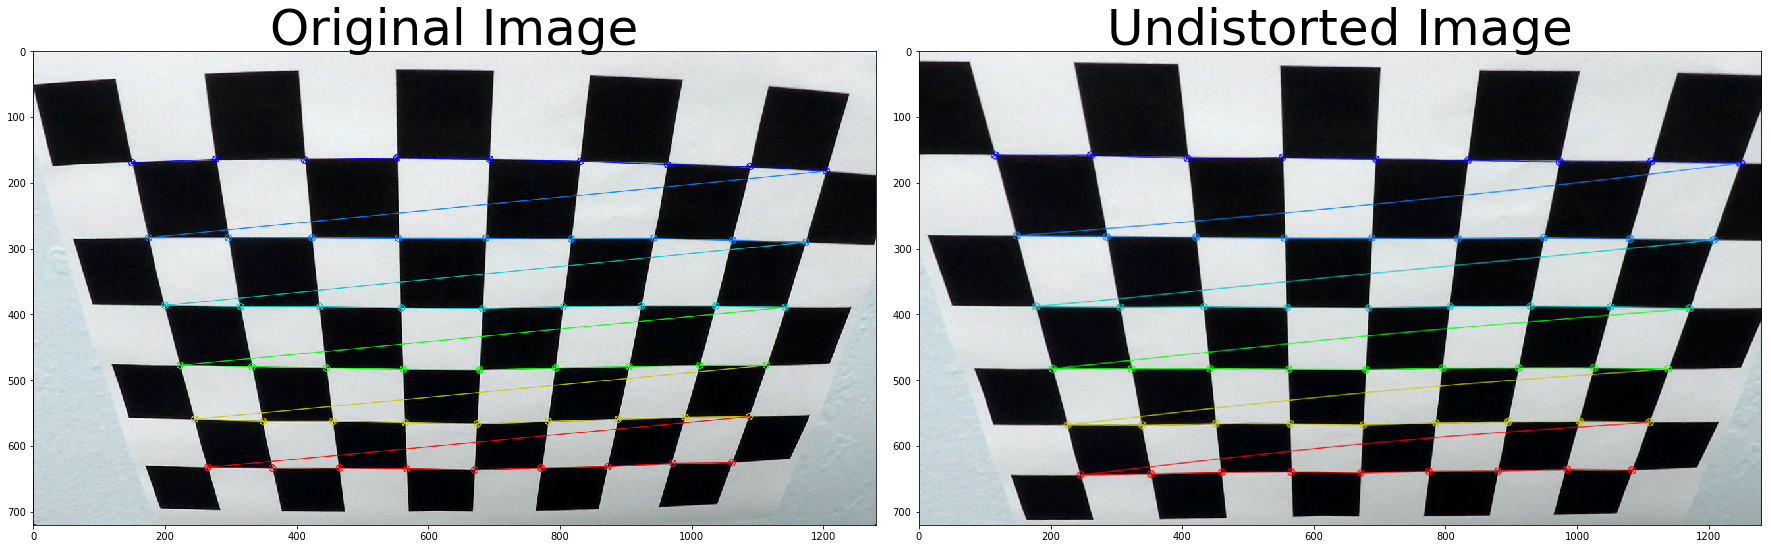

In [5]:
img = cv2.imread(images[11])
print('undistorting sample image: ',images[11])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

# If found, add object points, image points
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
if ret == True:
    objpoints.append(objp)
    imgpoints.append(corners)
    img2 = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

undistorted,mtx,dist = cal_undistort(img, objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/distortion_correction_output.jpg',figsize=(1,1))

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

Described below is how I used color transforms, gradients or other methods to create a thresholded binary image. Provided is an example of a binary image result.

In [6]:
test_images = glob.glob('test_images/test*.jpg')
line_images = glob.glob('test_images/straight_lines*.jpg')
test_images

['test_images/test1.jpg',
 'test_images/test2.jpg',
 'test_images/test3.jpg',
 'test_images/test4.jpg',
 'test_images/test5.jpg',
 'test_images/test6.jpg']

In [7]:
def pipeline(img, s_thresh=(230, 255), sx_thresh=(50, 100),hls_thresh=(160,255),thresh=(50, 100)):
    gb = cv2.GaussianBlur(img,(5,5),0)
    img = cv2.addWeighted(img, 2, gb, -1, 0)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    v_channel = hsv[:,:,2]    
    
    # Explore gradients in other colors spaces / color channels to see what might work better
    # Sobel x
    
    
    temp_s_out = np.zeros_like(s_channel)
    temp_s_out[(s_channel > hls_thresh[0]) & (s_channel <= hls_thresh[1])] = 1
    
    sobelx = cv2.Sobel(temp_s_out, cv2.CV_64F, 1, 0,ksize=11) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    thresh_min = sx_thresh[0]
    thresh_max = sx_thresh[1]
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold color channel
    s_thresh_min = s_thresh[0]
    s_thresh_max = s_thresh[1]
    s_binary = np.zeros_like(v_channel)
    s_binary[(v_channel >= s_thresh_min) & (v_channel <= s_thresh_max)] = 1
        
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    
    
    
    luv = cv2.cvtColor(img, cv2.COLOR_BGR2Luv)
    l_channel=luv[:,:,2]
#     temp_l = np.zeros_like(l_channel)
#     temp_l[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    
    
    sobelxl = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0,ksize=11) # Take the derivative in x
    abs_sobelxl = np.absolute(sobelxl) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobell = np.uint8(255*abs_sobelxl/np.max(abs_sobelxl))
    
    # Threshold x gradient
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    temp_l = np.zeros_like(scaled_sobell)
    temp_l[(scaled_sobell >= thresh_min) & (scaled_sobell <= thresh_max)] = 1
    
#     color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    color_binary = np.dstack(( temp_l, sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
        
#     end of luv
#     color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
#     # Combine the two binary thresholds
#     combined_binary = np.zeros_like(sxbinary)
#     combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary,color_binary    

**Provided below are examples of binary image result.**

## 4. Apply a perspective transform to rectify binary image ("birds-eye view").

The code for my perspective transform includes a function called warper(), which appears in lines 1 through 8 in the file example.py (examples/example.py) . The warper() function takes as inputs an image (img), as well as source (src) and destination (dst) points. I chose the hardcode the source and destination points in the following manner:



In [8]:
def warper(img, 
            src=np.float32([(580,460),
                   (702,460), 
                   (1124,720),
                   (201,720) 
                   ]) , 
           dst = np.float32([(450,0),
                  (1200-450,0),
                  (1200-450,720),
                  (450,720)
                  ])
          ):

#     src=np.float32([(580,460),
#            (702,460), 
#            (1124,720),
#            (201,720) 
#            ]) 
#     dst = np.float32([(320,0),
#            (960,0),
#            (960,720),
#            (320,720)
#            ]) 

    # Compute and apply perpective transform
    # Return transform matrix
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    
    return warped,M,Minv


def undistort(img,mtx,dist):
    undistorted=cv2.undistort(img,mtx,dist,None,mtx)
    return undistorted

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


## 5. Detect lane pixels and fit to find the lane boundary.

In [9]:
def sliding_window(image=None,mtx=mtx,dist=dist, nwindows = 10,margin = 80,minpix = 50):
    undistorted = undistort(image, mtx,dist)
    img_size=undistorted.shape
    w=img_size[1]
    h=img_size[0]
    
    warped,perspective_M,return_M =  warper(undistorted)    
#     binary_warped,stack_binary= pipeline(warped, s_thresh=(210, 255),sx_thresh=(230,255))
    binary_warped,stack_binary= pipeline(warped)
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    

    # # Find the peak of the left and right halves of the histogram
    # # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return out_img,return_M,left_fitx,right_fitx,ploty,leftx,lefty,rightx,righty,left_fit,right_fit
    

In [10]:
def get_curvature(ploty,lefty,righty,leftx,rightx,
                  xm_per_pix = 3.7/700,ym_per_pix = 30/720):
    #     lefty/righty is the actual pixel sample's y-value
    #     leftx/rightx is the actual pixel sample's x-value

    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #     print(left_curverad, 'm', right_curverad, 'm')

    return left_curverad,right_curverad


In [11]:
def extract_curvature(left_line=None,right_line=None):
    l_radius_of_curvature,r_radius_of_curvature = get_curvature(ploty=left_line.ploty, \
                                                 lefty=left_line.ally, \
                                                 righty=right_line.ally,\
                                                 leftx=left_line.allx,\
                                                 rightx=right_line.allx)
    return l_radius_of_curvature,r_radius_of_curvature


def extract_roc(left_line=None,right_line=None):
    l_radius_of_curvature=get_curvature(left_line)
    return l_radius_of_curvature,r_radius_of_curvature


In [25]:
def update_lanes(image=None,mtx=mtx,dist=dist
                 , nwindows = 9,margin = 50
                 ,minpix = 50, left_fit_previous=None
                 ,right_fit_previous=None):
    undistorted = undistort(image, mtx,dist)
    img_size=undistorted.shape
    w=img_size[1]
    h=img_size[0]
    
    warped,perspective_M,return_M =  warper(undistorted)    
    binary_warped,stack_binary = pipeline(warped)
#     binary_warped,stack_binary= pipeline(warped, s_thresh=(210, 255),sx_thresh=(230,255))
    #         pipeline_binary,stack_binary= pipeline(warped, s_thresh=(210, 255),sx_thresh=(230,255))    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
#     margin = 100
#     margin=60
    left_lane_inds = ((nonzerox > (left_fit_previous[0]*(nonzeroy**2) + left_fit_previous[1]*nonzeroy + left_fit_previous[2] - margin)) & (nonzerox < (left_fit_previous[0]*(nonzeroy**2) + left_fit_previous[1]*nonzeroy + left_fit_previous[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit_previous[0]*(nonzeroy**2) + right_fit_previous[1]*nonzeroy + right_fit_previous[2] - margin)) & (nonzerox < (right_fit_previous[0]*(nonzeroy**2) + right_fit_previous[1]*nonzeroy + right_fit_previous[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
#     return out_img,left_fitx,right_fitx,ploty,leftx,lefty,rightx,righty,left_fit,right_fit
    return result,left_fitx,right_fitx,ploty,leftx,lefty,rightx,righty,left_fit,right_fit
    


In [26]:
# Define a class to receive the characteristics of each line detection
def return_line(orig_image,warped_image,left_fitx,right_fitx,ploty,return_M, left_curverad,right_curverad,tint=(0,255,0)):
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Calculate the offset and position     
    c_offset,c_pos=extract_offset(image=warped_image,left_fitx=left_fitx,right_fitx=right_fitx)

    # Draw the lane onto the warped blank image
    color_warp=cv2.fillPoly(warp_zero, np.int_([pts]), tint)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, return_M, (orig_image.shape[1], orig_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(orig_image, 1, newwarp, 0.3, 0)
    
    
    new_img = np.copy(result)
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Radius of Curvature(L): ' + '{:04.2f}'.format(left_curverad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (0,255,155), 2, cv2.LINE_AA)
    text = 'Radius of Curvature(R): ' + '{:04.2f}'.format(right_curverad) + 'm'
    cv2.putText(new_img, text, (40,120), font, 1.5, (0,255,155), 2, cv2.LINE_AA)
#     image,left_fitx=None,right_fitx=None,xm_per_pix = 3.7/700)
    text = 'Vehicle is ' + '{:01.2f}'.format(c_offset) +'m ' + c_pos
    cv2.putText(new_img, text, (40,170), font, 1.5, (0,255,155), 2, cv2.LINE_AA)
    return new_img


import numpy as np
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.fitx = None
        self.ploty = None
        self.warped_img = None
        
class Lane():
    def __init__(self):
        self.left_line = Line()
        self.right_line = Line()
        self.out_image = None
        self.inverse_M = None
        self.mtx = None
        self.image=None
        self.detected=False
        self.n_fail=0
        self.mean_width=None
    def get_curvature(self):
        self.left_line.radius_of_curvature,self.right_line.radius_of_curvature = get_curvature(ploty=self.left_line.ploty, \
                                                     lefty=self.left_line.ally, \
                                                     righty=self.right_line.ally,\
                                                     leftx=self.left_line.allx,\
                                                     rightx=self.right_line.allx)

    def set_lanelines(self,tint=(0,255,0)):
        self.out_image= return_line(orig_image=self.image,warped_image=self.warped_img, \
                                  left_fitx=self.left_line.fitx,right_fitx=self.right_line.fitx, \
                                  ploty=self.left_line.ploty,return_M=self.inverse_M, left_curverad=self.left_line.radius_of_curvature, \
                                  right_curverad=self.right_line.radius_of_curvature,tint=tint)
        
    def update(self,image):
#         self.image=image

        self.warped_img,self.left_line, self.right_line = update_lines(image=image, \
                                          left_line=self.left_line, \
                                          right_line=self.right_line)
        r_curvature = self.right_line.radius_of_curvature
        l_curvature = self.left_line.radius_of_curvature
        
# update self.left_line.radius_of_curvature,self.right_line.radius_of_curvature
        self.get_curvature()
        
    #         check threshold of curvature difference
#         if((self.left_line.radius_of_curvature-self.right_line.radius_of_curvature)/ \
#            self.right_line.radius_of_curvature <0.5):
#         update if left and right curves are within 50%
#         use weighted average
        left_curve_change = abs(self.left_line.radius_of_curvature-l_curvature)/l_curvature
        right_curve_change = abs(self.right_line.radius_of_curvature-r_curvature)/r_curvature
    
        self.left_line.best_fit=0.7*self.left_line.current_fit +0.3*self.left_line.best_fit
        self.image=image
        
        
        if(right_curve_change<0.5):
            self.right_line.best_fit=0.7*self.right_line.current_fit + 0.3*self.right_line.best_fit
        else:
            pass
            self.detected=True
            
        if(left_curve_change<0.5):
            self.left_line.best_fit=0.7*self.left_line.current_fit + 0.3*self.left_line.best_fit
        else:
            pass
            self.detected=True            
        self.set_lanelines(tint=(0,255,0))
        
    def bootstrap_lane_lines(self,image):
        self.left_line.fitx = self.left_line.best_fit[0]*(self.left_line.ploty**2) + self.left_line.best_fit[1]*self.left_line.ploty + self.left_line.best_fit[2]
        self.right_line.fitx = self.right_line.best_fit[0]*(self.right_line.ploty**2) + self.right_line.best_fit[1]*self.right_line.ploty + self.right_line.best_fit[2]
        
        self.left_line.radius_of_curvature,self.right_line.radius_of_curvature = get_curvature(ploty=self.left_line.ploty, \
                                                     lefty=self.left_line.ploty, \
                                                     righty=self.right_line.ploty,\
                                                     leftx=self.left_line.fitx,\
                                                     rightx=self.right_line.fitx)
        self.image=image
        self.set_lanelines(tint=(255,0,0))
        
    def refresh_lines(self,image,tint=(0,255,0)):
        self.left_line.fitx = self.left_line.best_fit[0]*(self.left_line.ploty**2) + self.left_line.best_fit[1]*self.left_line.ploty + self.left_line.best_fit[2]
        self.right_line.fitx = self.right_line.best_fit[0]*(self.right_line.ploty**2) + self.right_line.best_fit[1]*self.right_line.ploty + self.right_line.best_fit[2]
        
        self.left_line.radius_of_curvature,self.right_line.radius_of_curvature = get_curvature(ploty=self.left_line.ploty, \
                                                     lefty=self.left_line.ploty, \
                                                     righty=self.right_line.ploty,\
                                                     leftx=self.left_line.fitx,\
                                                     rightx=self.right_line.fitx)
        self.image=image
        self.set_lanelines(tint=(0,255,0))
    def sliding_window(self,image):
        self.image=image
        self.warped_img,self.inverse_M,self.left_line.fitx,self.right_line.fitx,\
            self.left_line.ploty,self.left_line.allx,self.left_line.ally,\
            self.right_line.allx,self.right_line.ally,self.left_line.current_fit,\
            self.right_line.current_fit = sliding_window(image)
        self.get_curvature()
        self.right_line.ploty=self.left_line.ploty
#         self.set_lanelines()
        
        if (self.right_line.best_fit is None) :
            self.right_line.best_fit=self.right_line.current_fit

        if (self.left_line.best_fit is None) :
            self.left_line.best_fit=self.left_line.current_fit
            
#         check threshold of curvature difference
        if(abs(self.left_line.radius_of_curvature-self.right_line.radius_of_curvature)/ \
           self.right_line.radius_of_curvature <0.5)  or \
           (abs(self.left_line.radius_of_curvature-self.right_line.radius_of_curvature)/ \
           self.left_line.radius_of_curvature <0.5):
#       DIFFERENCE IS ACCEPTABLE (<50%)
            self.left_line.best_fit=0.3*self.left_line.best_fit + 0.7* self.left_line.current_fit
            self.right_line.best_fit=0.3 * self.right_line.best_fit + 0.7*self.right_line.current_fit
            self.detected=True
            print('SLIDING:CURVATURE accepted')
#             self.set_lanelines()
#             self.set_lanelines()
            self.refresh_lines(image)
            
        else:
#             self.out_image,self.left_line, self.right_line = update_lines(image=self.image, \
#             left_line=self.left_line, \
#             right_line=self.right_line)
#             self.get_curvature()
#             self.left_line.best_fit=self.left_line.best_fit
#             self.right_line.best_fit=self.right_line.best_fit
        
#             self.out_image=image
#             self.out_image=image
            print('SLIDING:CURVATURE TOO DIFFERENT')
            self.detected=True
        
            self.image=image
            
            self.bootstrap_lane_lines(image)
#         self.set_lanelines

       

In [27]:
def update_lines(image=None,left_line=None,right_line=None):
    out_img,left_line.fitx,right_line.fitx, \
    left_line.ploty,left_line.allx, \
    left_line.ally,right_line.allx, \
    right_line.ally,left_line.current_fit, \
    right_line.current_fit = update_lanes( image, \
                                          left_fit_previous=left_line.best_fit, \
                                          right_fit_previous=right_line.best_fit) 
#                                           left_fit_previous=left_line.current_fit, \
#                                           right_fit_previous=right_line.current_fit) 
    return out_img,left_line, right_line

In [28]:
temp_lane = Lane()
temp_lane.sliding_window(mpimg.imread(line_images[1]))
# plt.figure()
# plt.imshow(temp_lane.out_image)
# print(temp_lane.left_line.radius_of_curvature, temp_lane.right_line.radius_of_curvature)
# temp_lane.update(mpimg.imread(test_images[1]))
# print(temp_lane.left_line.radius_of_curvature, temp_lane.right_line.radius_of_curvature)


SLIDING:CURVATURE accepted


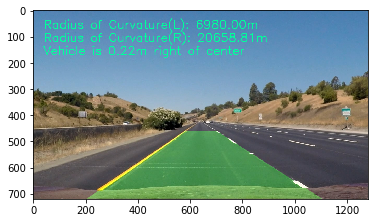

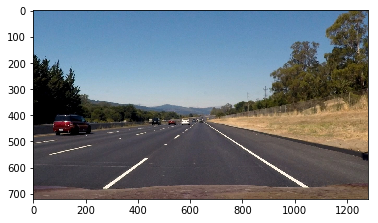

In [29]:
temp_lane.update(mpimg.imread(line_images[0]))
plt.imshow(temp_lane.out_image)
plt.figure()
plt.imshow(mpimg.imread(line_images[1]))

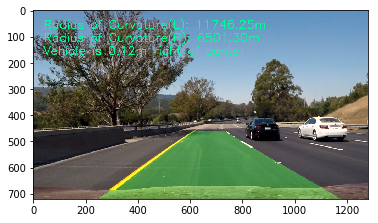

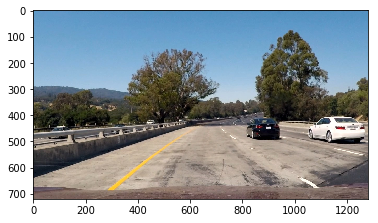

In [30]:
temp_lane.update(mpimg.imread(test_images[5]))
plt.imshow(temp_lane.out_image)
plt.figure()
plt.imshow(mpimg.imread(test_images[0]))

## Test on Videos

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import io
import base64

In [21]:
lane_container=Lane()

In [55]:
lane_container=Lane()
# lane_container.sliding_window(image)
lane_container.sliding_window(mpimg.imread(line_images[0]))
def process_image(image):
    try:
        if(lane_container.detected==True):
            lane_container.update(image)
            print('complete')
        else:
            lane_container.sliding_window(image)
            print('window-notdetected')
            
    except:
        try:
            lane_container.sliding_window(image) 
            print('window')
        except:
            print('fail')
            pass
        else:
            
            print('fail')
            pass
        
    l_fit_x_int = lane_container.left_line.fitx[-1]
    r_fit_x_int = lane_container.right_line.fitx[-1]
    
    l_fit_x_top = lane_container.left_line.fitx[0]
    r_fit_x_top = lane_container.right_line.fitx[0]
    
    
    
#     print('LFIT',lane_container.left_line.best_fit)
    mean_fit_dist = (lane_container.right_line.fitx-lane_container.left_line.fitx).mean()
    
    std_fit_dist = (lane_container.right_line.fitx-lane_container.left_line.fitx).std()
#     if ((r_fit_x_int - l_fit_x_int)<400.0 ) and ((r_fit_x_int - l_fit_x_int)>250.0)\
    print(l_fit_x_int, r_fit_x_int, r_fit_x_int - l_fit_x_int)
    print(mean_fit_dist, 'mean', std_fit_dist, 'std', lane_container.left_line.radius_of_curvature, 'left curve', lane_container.right_line.radius_of_curvature,'right curve') 
    
    if(lane_container.mean_width is None) :
        lane_container.mean_width=mean_fit_dist
        
    print( abs(mean_fit_dist-lane_container.mean_width)/lane_container.mean_width, 'rev change width')

    if (mean_fit_dist<325.0 ) and (mean_fit_dist>250.0)\
    and (r_fit_x_int - l_fit_x_int<325) \
    and (r_fit_x_int - l_fit_x_int>250) \
    and (l_fit_x_top<r_fit_x_top) \
    and (lane_container.left_line.radius_of_curvature>400) \
    and (lane_container.right_line.radius_of_curvature>400) \
    and std_fit_dist<10 :
#     and abs(mean_fit_dist-lane_container.mean_width)/lane_container.mean_width<0.005:
#     and (r_fit_x_top-l_fit_x_top<(r_fit_x_int-l_fit_x_int)0.9):
#         if(abs(R-R0)/R0>0.5)
        if(abs(lane_container.left_line.radius_of_curvature-lane_container.right_line.radius_of_curvature)/ \
           lane_container.right_line.radius_of_curvature <0.3) :
#        abs(R-R0)/R0  # R = current radius of curvature
#             print(lane_container.left_line.best_fit)
#             print('curr',3*lane_container.left_line.current_fit)

            lane_container.left_line.best_fit=lane_container.left_line.current_fit*0.7 + \
                0.3* lane_container.left_line.best_fit
            lane_container.right_line.best_fit= 0.7*lane_container.right_line.current_fit + \
                0.3* lane_container.right_line.current_fit
                
            lane_container.n_fail=0
            lane_container.detected=True
            lane_container.refresh_lines(image)
            
            print('good update')
        else:
            print('curvature poblem')
#             lane_container.sliding_window(image)
#             lane_container.out_image=image
            lane_container.bootstrap_lane_lines(image)
            print('bootstrap')
            lane_container.n_fail+=1
            lane_container.detected=True
#             update the image using previous configuration
    else:
        print('lane width problem')
        
        if(lane_container.n_fail>20):
            lane_container.detected=False
#             lane_container.out_image=image
            lane_container.bootstrap_lane_lines(image)
#         lane_container.detected=False
        else:
            lane_container.bootstrap_lane_lines(image)
            lane_container.n_fail+=1
#     if ()
            
#         l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
#         r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
#         x_int_diff = abs(r_fit_x_int-l_fit_x_int)
#         if abs(350 - x_int_diff) > 100:
#             l_fit = None
#             r_fit = None
            
#     l_line.add_fit(l_fit, l_lane_inds)
#     r_line.add_fit(r_fit, r_lane_inds)
        
#     if (rn.rand()>0.80):
#         lane_container.sliding_window(image)
#     else:
#         lane_container.update(image)
    return lane_container.out_image

SLIDING:CURVATURE TOO DIFFERENT


complete
459.174311543 756.578198862 297.403887319
curvature poblem
bootstrap
[  2.64109845e-05  -9.74565705e-02   5.14907441e+02]
6.31941612003e-11


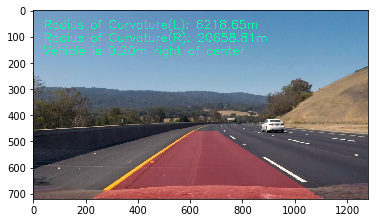

In [23]:
process_image(mpimg.imread(test_images[2]))
plt.imshow(lane_container.out_image)
print(lane_container.left_line.best_fit)
print(lane_container.right_line.best_fit[0]**2)
# plt.imshow(temp_lane.out_image)
# plt.figure()
# plt.imshow(mpimg.imread(test_images[0]))

In [73]:
sample_output = 'sample_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(sample_output, audio=False)

[MoviePy] >>>> Building video sample_output.mp4
[MoviePy] Writing video sample_output.mp4


100%|█████████▉| 1260/1261 [02:18<00:00,  9.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: sample_output.mp4 

CPU times: user 3min 5s, sys: 21.9 s, total: 3min 27s
Wall time: 2min 18s


In [58]:
video = io.open('sample_output.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [74]:
from numpy import random as rn

In [56]:
lane_container=Lane()
sample_output = 'sample_with_luv_50margin5_diffmargin1_smaller_lanewidth.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(sample_output, audio=False)

SLIDING:CURVATURE accepted
window-notdetected
476.510370698 774.344532051 297.834161354
299.335082485 mean 2.52445783689 std 1603.63624299 left curve 2215.93328392 right curve
0.0 rev change width
good update
[MoviePy] >>>> Building video sample_with_luv_50margin5_diffmargin1_smaller_lanewidth.mp4
[MoviePy] Writing video sample_with_luv_50margin5_diffmargin1_smaller_lanewidth.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

complete
476.510370698 774.344532051 297.834161354
299.335082485 mean 2.52445783689 std 1603.63624299 left curve 2215.93328392 right curve
2.46868639338e-15 rev change width


  0%|          | 1/1261 [00:00<04:39,  4.50it/s]

good update


  0%|          | 2/1261 [00:00<04:47,  4.38it/s]

complete
476.764441823 774.028655232 297.26421341
297.321595603 mean 1.7894207096 std 1539.61274033 left curve 2087.36656511 right curve
0.00672653156862 rev change width
good update


  0%|          | 3/1261 [00:00<04:42,  4.46it/s]

complete
477.025549749 774.549149373 297.523599624
295.990812228 mean 2.07079412949 std 1476.85254742 left curve 2402.15641278 right curve
0.0111723297808 rev change width
curvature poblem
bootstrap


  0%|          | 4/1261 [00:00<04:39,  4.49it/s]

complete
476.563402873 774.582455255 298.019052382
294.073158697 mean 1.67585853888 std 1324.93241529 left curve 2034.75468665 right curve
0.0175787072616 rev change width
curvature poblem
bootstrap


  0%|          | 5/1261 [00:01<04:38,  4.52it/s]

complete
477.267913281 775.025237512 297.757324232
294.030530193 mean 1.37788634268 std 1360.93710266 left curve 1877.39137621 right curve
0.0177211179134 rev change width
good update


  0%|          | 6/1261 [00:01<04:40,  4.47it/s]

complete
478.240304842 775.050466618 296.810161777
292.427967285 mean 1.61422443525 std 1361.63604462 left curve 2004.74423839 right curve
0.0230748602609 rev change width
curvature poblem
bootstrap


  1%|          | 7/1261 [00:01<04:44,  4.40it/s]

complete
478.85781619 775.759863373 296.902047183
293.738954068 mean 1.43068857852 std 1412.86076887 left curve 2073.2873258 right curve
0.0186951972693 rev change width
curvature poblem
bootstrap


  1%|          | 8/1261 [00:01<04:35,  4.55it/s]

complete
479.735513509 776.202904835 296.467391326
291.309931375 mean 1.86985002405 std 1385.89535641 left curve 2191.1352719 right curve
0.0268099249953 rev change width
curvature poblem
bootstrap


  1%|          | 9/1261 [00:01<04:32,  4.60it/s]

complete
479.743662538 777.162224663 297.418562125
293.485622491 mean 1.97804936225 std 1455.89596899 left curve 2647.82440694 right curve
0.0195415116235 rev change width
curvature poblem
bootstrap


  1%|          | 10/1261 [00:02<04:30,  4.62it/s]

complete
479.706327653 777.289444305 297.583116652
294.076058082 mean 1.94110811886 std 1492.34645598 left curve 2693.9005997 right curve
0.0175690211746 rev change width
curvature poblem
bootstrap


  1%|          | 11/1261 [00:02<04:36,  4.52it/s]

complete
480.067205731 777.054758051 296.98755232
292.815854257 mean 1.77515529922 std 1547.25488499 left curve 2722.35028694 right curve
0.0217790316267 rev change width
curvature poblem
bootstrap


  1%|          | 12/1261 [00:02<04:29,  4.63it/s]

complete
479.491782547 778.052557028 298.560774481
299.614041338 mean 3.79228324701 std 1641.33072501 left curve 3437.33286159 right curve
0.000931928361177 rev change width
curvature poblem
bootstrap


  1%|          | 13/1261 [00:02<04:33,  4.57it/s]

complete
480.03821866 777.230171961 297.191953301
298.043882405 mean 3.60765517079 std 1680.4728157 left curve 3507.09974508 right curve
0.00431356080716 rev change width
curvature poblem
bootstrap


  1%|          | 14/1261 [00:03<04:32,  4.58it/s]

complete
480.492592061 776.28152644 295.788934378
297.025035404 mean 2.83480514062 std 1852.97015505 left curve 3091.34667598 right curve
0.00771726141002 rev change width
curvature poblem
bootstrap


  1%|          | 15/1261 [00:03<04:35,  4.52it/s]

complete
481.273624189 775.216972099 293.94334791
292.093933229 mean 1.40987933288 std 1993.89733271 left curve 3341.76857296 right curve
0.0241907804329 rev change width
curvature poblem
bootstrap
complete


  1%|▏         | 17/1261 [00:03<04:18,  4.81it/s]

481.448904918 772.933051122 291.484146204
287.51585095 mean 1.72608661114 std 2014.09907158 left curve 2392.71898562 right curve
0.0394849525707 rev change width
good update
complete
480.450960675 772.897417767 292.446457092
287.43241479 mean 2.00072666664 std 2031.80954754 left curve 2781.83677623 right curve
0.039763690898 rev change width
good update


  1%|▏         | 18/1261 [00:03<04:14,  4.89it/s]

complete
480.742392993 772.093986156 291.351593164
285.538644764 mean 2.79064636545 std 2191.84152774 left curve 2621.49544819 right curve
0.0460902798505 rev change width
good update
complete
479.938350385 772.681799067 292.743448682
289.076894885 mean 1.35398484531 std 2203.5499533 left curve 3044.79788396 right curve
0.0342699142202 rev change width


  2%|▏         | 20/1261 [00:04<04:07,  5.02it/s]

good update
complete
480.069069189 772.95840271 292.889333521
291.477657187 mean 0.500959416221 std 2633.71385815 left curve 3134.40342019 right curve
0.0262495970507 rev change width
good update


  2%|▏         | 21/1261 [00:04<04:05,  5.06it/s]

complete
479.214728723 769.624048763 290.40932004
294.267496615 mean 1.8666887241 std 2704.60356405 left curve 2396.35046236 right curve
0.0169294752491 rev change width
good update
complete
478.244519149 770.506646836 292.262127687
297.899966268 mean 3.04571931941 std 2723.38622774 left curve 2538.3766081 right curve
0.00479434687444 rev change width


  2%|▏         | 23/1261 [00:04<04:02,  5.11it/s]

good update
complete
476.948211864 771.096657829 294.148445965
301.310078151 mean 4.13521646401 std 2761.50175563 left curve 2756.46856028 right curve
0.00659794251153 rev change width
good update


  2%|▏         | 24/1261 [00:05<04:02,  5.10it/s]

complete
475.917797776 770.933071468 295.015273692
299.099325783 mean 2.61381862499 std 2567.54773483 left curve 2782.30218478 right curve
0.000787601307132 rev change width
good update
complete
475.059878265 770.020310639 294.960432374
297.646016211 mean 1.8608631801 std 2341.88037366 left curve 2557.48444281 right curve
0.005642727406 rev change width


  2%|▏         | 26/1261 [00:05<04:03,  5.08it/s]

good update
complete
473.938958846 768.726513641 294.787554795
301.543469771 mean 3.33154690497 std 2310.07572063 left curve 1971.1171081 right curve
0.00737764269821 rev change width
good update


  2%|▏         | 27/1261 [00:05<04:05,  5.02it/s]

complete
472.833231065 769.750757949 296.917526884
302.556400712 mean 3.0827864992 std 2158.16485479 left curve 2059.89201003 right curve
0.0107615792989 rev change width
good update
complete
471.65626482 770.838189241 299.181924421
307.249493722 mean 4.59203180587 std 2154.49753154 left curve 2113.98678846 right curve
0.0264399721253 

  2%|▏         | 28/1261 [00:05<04:05,  5.02it/s]

rev change width
good update
complete
471.297510996 771.681304446 300.383793451
305.038430044 mean 3.42311703862 std 1965.45749811 left curve 2356.54976504 right curve
0.0190533883023 rev change width
good update

  2%|▏         | 30/1261 [00:06<04:11,  4.89it/s]


complete
470.270522491 771.591615387 301.321092896
301.794984947 mean 1.88785512998 std 1693.41573219 left curve 2327.42177831 right curve
0.00821788893568 rev change width
good update
complete
470.335811749 771.624121314

  2%|▏         | 31/1261 [00:06<04:09,  4.92it/s]

 301.288309565
297.728179383 mean 1.46859847381 std 1552.9579577 left curve 1787.97187668 right curve
0.00536824180102 rev change width
good update
complete
470.619066909 771.227886249 300.60881934
293.264766787 mean 3.11586915914 std 1460.431498 left curve 1901.57963098 right curve
0.0202793326046 rev change width
good update

  3%|▎         | 33/1261 [00:06<04:10,  4.91it/s]


complete
470.262457716 773.196711548 302.934253832
296.386560535 mean 2.40047937625 std 1432.81086447 left curve 2138.1838333 right curve
0.00985023848572 rev change width
curvature poblem
bootstrap
complete
470.651703891 773.023980702 302.372276811
294.467249964 mean 2.93564465295 std 1385.78569818 left curve 2188.96282126 right curve
0.0162621517 rev change width
curvature poblem


  3%|▎         | 34/1261 [00:07<04:07,  4.95it/s]

bootstrap
complete
470.865124959 773.772531266 302.907406307
293.221020506 mean 3.49746622941 std 1275.46287647 left curve 2381.53768968 right curve
0.020425477457 rev change width
curvature poblem


  3%|▎         | 35/1261 [00:07<04:11,  4.87it/s]

bootstrap
complete
471.742801376 773.205175446 301.462374069
290.727866104 mean 3.89529729084 std 1228.43953971 left curve 2381.5491958 right curve
0.0287544523996 rev change width
curvature poblem


  3%|▎         | 36/1261 [00:07<04:12,  4.86it/s]

bootstrap
complete
472.469337424 772.517875234 300.04853781
289.962403997 mean 3.60007387488 std 1254.69492152 left curve 2557.4484551 right curve
0.0313116605302 rev change width
curvature poblem


  3%|▎         | 37/1261 [00:07<04:12,  4.85it/s]

bootstrap
complete
472.903227189 770.427159197 297.523932008
287.94790451 mean 3.48928545611 std 1186.46700284 left curve 2009.91489071 right curve
0.0380415749477 rev change width
curvature poblem


  3%|▎         | 38/1261 [00:07<04:13,  4.82it/s]

bootstrap
complete
473.371512029 768.833454862 295.461942833
285.186185086 mean 3.8156992723 std 1121.38038247 left curve 1826.5728377 right curve
0.0472677551905 rev change width
curvature poblem


  3%|▎         | 39/1261 [00:08<04:13,  4.82it/s]

bootstrap
complete
473.769039982 769.11363453 295.344594547
286.669621671 mean 3.10258309035 std 1136.86359039 left curve 1867.79782231 right curve
0.0423119826403 rev change width
curvature poblem


  3%|▎         | 40/1261 [00:08<04:19,  4.71it/s]

bootstrap
complete
474.555164129 769.656196605 295.101032476
286.91556431 mean 2.91130175671 std 1154.95391014 left curve 2068.89204189 right curve
0.0414903527914 rev change width
curvature poblem


  3%|▎         | 41/1261 [00:08<04:17,  4.74it/s]

bootstrap
complete
475.046543849 770.146660727 295.100116878
287.315614677 mean 2.76087322044 std 1143.43732714 left curve 1879.28062044 right curve
0.04015388944 rev change width
curvature poblem


  3%|▎         | 42/1261 [00:08<04:16,  4.75it/s]

bootstrap
complete
475.067140272 770.935005223 295.86786495
289.334541275 mean 2.32239209243 std 1147.24948756 left curve 1760.1884577 right curve
0.0334091852083 rev change width
curvature poblem


  3%|▎         | 43/1261 [00:08<04:17,  4.73it/s]

bootstrap
complete
475.075303826 771.424826969 296.349523143
292.071170046 mean 1.71766211073 std 1163.4601265 left curve 1686.80790029 right curve
0.0242668262553 rev change width
curvature poblem


  3%|▎         | 44/1261 [00:09<04:15,  4.77it/s]

bootstrap
complete
475.563213907 772.816558366 297.253344459
294.425666535 mean 2.03587772365 std 1205.70319871 left curve 1875.14398933 right curve
0.0164010710309 rev change width
curvature poblem


  4%|▎         | 45/1261 [00:09<04:16,  4.74it/s]

bootstrap
complete
475.547919038 772.866085545 297.318166507
294.628244243 mean 2.23061110263 std 1218.30713371 left curve 1971.81082625 right curve
0.01572431204 rev change width
curvature poblem


  4%|▎         | 46/1261 [00:09<04:15,  4.75it/s]

bootstrap
complete
475.647394798 772.890409332 297.243014534
296.191481092 mean 2.56136228929 std 1267.70614011 left curve 2010.33364335 right curve
0.0105019477389 rev change width
curvature poblem


  4%|▎         | 47/1261 [00:09<04:14,  4.77it/s]

bootstrap
complete
475.89852218 771.981505252 296.082983072
294.78978073 mean 2.07765750071 std 1279.09606804 left curve 1891.01922353 right curve
0.0151846610075 rev change width
curvature poblem


  4%|▍         | 48/1261 [00:10<04:12,  4.80it/s]

bootstrap
complete
476.091567481 773.009677337 296.918109856
298.154462816 mean 3.36696539197 std 1350.18186086 left curve 2116.45672612 right curve
0.00394414065649 rev change width
curvature poblem


  4%|▍         | 49/1261 [00:10<04:12,  4.80it/s]

bootstrap
complete
476.618129766 773.661102661 297.042972895
297.496149528 mean 3.15316140368 std 1417.02252245 left curve 2373.7543209 right curve
0.00614339268769 rev change width
curvature poblem


  4%|▍         | 50/1261 [00:10<04:15,  4.74it/s]

bootstrap
complete
477.313981595 770.471750154 293.157768559
297.452403674 mean 2.92785802165 std 1540.69560239 left curve 1675.32029419 right curve
0.00628953611303 rev change width


  4%|▍         | 51/1261 [00:10<04:15,  4.73it/s]

good update
complete
477.802591649 769.921384941 292.118793292
294.265060841 mean 0.993596930171 std 1668.87808439 left curve 1581.75073816 right curve
0.0169376125298 rev change width


  4%|▍         | 52/1261 [00:10<04:13,  4.76it/s]

good update
complete
478.392623348 769.931234888 291.538611539
293.268133407 mean 1.1187668845 std 1805.19382871 left curve 1852.35658189 right curve
0.0202680856113 rev change width


  4%|▍         | 53/1261 [00:11<04:12,  4.79it/s]

good update
complete
478.196059506 769.74295699 291.546897484
291.937743037 mean 0.760524772182 std 1948.48026197 left curve 1659.01681173 right curve
0.0247125708975 rev change width


  4%|▍         | 54/1261 [00:11<04:13,  4.77it/s]

good update
complete
477.955965427 770.291623336 292.33565791
292.871402553 mean 1.37824756239 std 2061.70071204 left curve 1560.89727217 right curve
0.0215934593366 rev change width
curvature poblem


  4%|▍         | 55/1261 [00:11<04:12,  4.77it/s]

bootstrap
complete
477.436211012 770.858375283 293.422164272
294.293458793 mean 0.847779430619 std 2211.68030719 left curve 1763.89270224 right curve
0.0168427424199 rev change width


  4%|▍         | 56/1261 [00:11<04:11,  4.79it/s]

good update
complete
477.40311091 771.441516642 294.038405732
293.906477375 mean 1.27645041975 std 2379.57412604 left curve 1859.64505194 right curve
0.01813554584 rev change width


  5%|▍         | 57/1261 [00:11<04:10,  4.80it/s]

good update
complete
477.127222605 771.54134835 294.414125745
294.139164674 mean 1.27286496019 std 2525.45584788 left curve 1974.24794341 right curve
0.0173581986045 rev change width


  5%|▍         | 58/1261 [00:12<04:09,  4.82it/s]

good update
complete
476.678980586 773.130532074 296.451551488
289.41488583 mean 3.98130393304 std 2327.26147673 left curve 2386.90124195 right curve
0.0331407751232 rev change width


  5%|▍         | 59/1261 [00:12<04:09,  4.82it/s]

good update
complete
476.104700938 770.179988206 294.075287268
284.955634954 mean 5.25744943167 std 2215.59456041 left curve 2224.84268867 right curve
0.0480379627115 rev change width
good update

  5%|▍         | 61/1261 [00:12<04:07,  4.84it/s]


complete
475.149096618 769.167304586 294.018207968
283.527641672 mean 5.9077079099 std 2118.58142932 left curve 2209.67687083 right curve
0.0528085137301 rev change width
good update
complete
474.405945747 769.542891789 295.136946042
281.083320641 mean 6.67864320178 std 1881.48353935 left curve

  5%|▍         | 62/1261 [00:12<04:05,  4.89it/s]

 2933.60505079 right curve
0.0609743491889 rev change width
curvature poblem
bootstrap
complete
473.537652755 766.584545354 293.046892599
282.731618273 mean 5.69070545383 std 1898.33545593 left curve 2029.12788552 right curve
0.0554678191215 rev change width


  5%|▍         | 63/1261 [00:13<04:07,  4.85it/s]

good update
complete
472.744975689 767.084771348 294.339795659
281.331533633 mean 6.07636959551 std 1740.46078818 left curve 2613.48279617 right curve
0.0601451346854 rev change width
curvature poblem


  5%|▌         | 64/1261 [00:13<04:10,  4.78it/s]

bootstrap
complete
471.946197893 766.128808787 294.182610894
283.754883073 mean 4.75106354552 std 1764.56159052 left curve 2533.3614877 right curve
0.0520493598082 rev change width
curvature poblem


  5%|▌         | 65/1261 [00:13<04:12,  4.74it/s]

bootstrap
complete
471.765487816 765.40569854 293.640210725
282.084217204 mean 5.27442567254 std 1718.85520171 left curve 2546.95472591 right curve
0.0576306162903 rev change width
curvature poblem


  5%|▌         | 66/1261 [00:13<04:14,  4.70it/s]

bootstrap
complete
471.011207794 765.111471427 294.100263633
282.801270977 mean 5.03746115193 std 1684.77234973 left curve 2564.89415892 right curve
0.0552351277046 rev change width
curvature poblem


  5%|▌         | 67/1261 [00:14<04:12,  4.73it/s]

bootstrap
complete
469.588570395 764.714338764 295.125768368
284.611685482 mean 4.44662007124 std 1638.35095588 left curve 2628.62278565 right curve
0.0491870076852 rev change width
curvature poblem


  5%|▌         | 68/1261 [00:14<04:09,  4.78it/s]

bootstrap
complete
469.127996573 764.238120345 295.110123772
282.044951252 mean 5.53810448221 std 1501.038632 left curve 2613.0206629 right curve
0.0577617935371 rev change width
curvature poblem


  5%|▌         | 69/1261 [00:14<04:09,  4.77it/s]

bootstrap
complete
468.579167868 764.703813082 296.124645214
285.33786095 mean 4.21234874064 std 1573.03505027 left curve 3030.25877194 right curve
0.0467610459097 rev change width
curvature poblem


  6%|▌         | 70/1261 [00:14<04:07,  4.81it/s]

bootstrap
complete
469.098140624 765.875013538 296.776872913
284.749877318 mean 4.61192827117 std 1645.21787044 left curve 4057.37487442 right curve
0.0487253450084 rev change width
curvature poblem


  6%|▌         | 71/1261 [00:14<04:08,  4.78it/s]

bootstrap
complete
469.049828813 765.156872004 296.107043191
286.51529706 mean 3.53171788653 std 1735.75231221 left curve 4090.43645002 right curve
0.0428275406905 rev change width
curvature poblem


  6%|▌         | 72/1261 [00:15<04:08,  4.78it/s]

bootstrap
complete
469.119362806 763.951443112 294.832080306
287.539806009 mean 2.6385300726 std 1888.13699862 left curve 3872.3458236 right curve
0.0394049250017 rev change width
curvature poblem


  6%|▌         | 73/1261 [00:15<04:10,  4.74it/s]

bootstrap
complete
469.517369113 763.307185179 293.789816066
287.514104936 mean 2.22646053121 std 2007.36844211 left curve 4636.77668696 right curve
0.0394907855451 rev change width
curvature poblem


  6%|▌         | 74/1261 [00:15<04:09,  4.76it/s]

bootstrap
complete
469.380625512 763.154734993 293.77410948
290.735893394 mean 1.57699218035 std 2338.82735509 left curve 5490.23626781 right curve
0.0287276353303 rev change width
curvature poblem
bootstrap

  6%|▌         | 76/1261 [00:15<04:06,  4.80it/s]


complete
469.801553531 759.83625348 290.03469995
289.376149026 mean 0.283270486654 std 2536.29103244 left curve 2626.72645837 right curve
0.0332701846238 rev change width
good update
complete
469.486705109 759.959765427 290.473060318
295.297325756 mean 2.24389968485 std 3127.80030045 left curve 2548.95859602 right curve
0.0134890861937 rev change width


  6%|▌         | 77/1261 [00:16<04:01,  4.89it/s]

good update
complete
469.134415672 760.472656163 291.338240491
297.730519155 mean 2.88804709493 std 3592.17536545 left curve 2580.09172703 right curve
0.00536042523432 rev change width
curvature poblem


  6%|▌         | 78/1261 [00:16<04:04,  4.84it/s]

bootstrap
complete
468.559610631 760.785550642 292.225940011
300.191885588 mean 3.74867088235 std 4601.30405488 left curve 3023.29616456 right curve
0.0028623544427 rev change width
curvature poblem


  6%|▋         | 79/1261 [00:16<04:04,  4.84it/s]

bootstrap
complete
467.294348912 760.025565359 292.731216446
299.163122002 mean 2.28455993552 std 4124.11693582 left curve 1944.38482111 right curve
0.000574474870424 rev change width
curvature poblem


  6%|▋         | 80/1261 [00:16<04:05,  4.81it/s]

bootstrap
complete
466.49103245 759.615140892 293.124108442
296.979152155 mean 2.09994161364 std 4280.94126778 left curve 1792.6094224 right curve
0.00787054531272 rev change width
curvature poblem


  6%|▋         | 81/1261 [00:16<04:06,  4.80it/s]

bootstrap
complete
464.93107682 759.895762017 294.964685197
298.348629376 mean 1.67823794548 std 3726.65931319 left curve 1882.83014662 right curve
0.00329548110542 rev change width
curvature poblem


  7%|▋         | 82/1261 [00:17<04:05,  4.79it/s]

bootstrap
complete
463.930808495 760.599209146 296.668400651
298.756214989 mean 1.63427632116 std 3631.14602767 left curve 1966.96076713 right curve
0.0019338444762 rev change width
curvature poblem


  7%|▋         | 83/1261 [00:17<04:09,  4.73it/s]

bootstrap
complete
462.474430749 763.195922583 300.721491834
305.090457664 mean 1.55547206696 std 4031.93779822 left curve 2338.07881287 right curve
0.0192271989338 rev change width
curvature poblem


  7%|▋         | 84/1261 [00:17<04:08,  4.74it/s]

bootstrap
complete
461.657309289 763.391813098 301.73450381
304.433551015 mean 0.959714733922 std 3400.15875099 left curve 2381.52296467 right curve
0.017032646116 rev change width
curvature poblem


  7%|▋         | 86/1261 [00:17<04:06,  4.76it/s]

bootstrap
complete
460.545903221 763.25374491 302.707841689
303.742472288 mean 0.396630368744 std 2925.94637726 left curve 2487.59023447 right curve
0.0147239333483 rev change width
good update
complete
460.718737626 763.392477462 302.673739836


  7%|▋         | 87/1261 [00:18<04:04,  4.81it/s]

296.932529614 mean 2.82547328691 std 2380.98560116 left curve 2809.44913747 right curve
0.0080262989926 rev change width
good update
complete
460.273337293 760.889662263 300.61632497
292.212530242 mean 4.27250775802 std 1994.65233063 left curve 2345.6312676 right curve
0.023794578917 rev change width


  7%|▋         | 88/1261 [00:18<04:03,  4.82it/s]

good update
complete
460.441926839 758.763878382 298.321951543
288.859366856 mean 5.48101937474 std 1819.29197426 left curve 1815.18349918 right curve
0.0349966183121 rev change width


  7%|▋         | 89/1261 [00:18<04:04,  4.79it/s]

good update
complete
461.453450405 758.199990676 296.746540271
283.296403617 mean 7.51987283357 std 1705.45270336 left curve 1802.97667401 right curve
0.0535810194195 rev change width


  7%|▋         | 90/1261 [00:18<04:04,  4.79it/s]

good update
complete
461.624128718 758.814587483 297.190458765
286.123744671 mean 5.99712884639 std 1737.00147731 left curve 1902.71294798 right curve
0.0441356145229 rev change width


  7%|▋         | 91/1261 [00:19<04:03,  4.81it/s]

good update
complete
461.996556472 759.514340928 297.517784456
286.880027979 mean 5.31014697985 std 1737.46571898 left curve 2140.22045428 right curve
0.0416090703524 rev change width


  7%|▋         | 92/1261 [00:19<04:04,  4.77it/s]

good update
complete
461.862261149 759.148779133 297.286517984
284.235278931 mean 6.41329505807 std 1590.15209791 left curve 2075.03884389 right curve
0.0504444832486 rev change width


  7%|▋         | 93/1261 [00:19<04:07,  4.72it/s]

good update
complete
462.568810096 759.236385565 296.667575469
283.36812092 mean 6.24606223823 std 1546.42724357 left curve 2195.67805072 right curve
0.0533414307209 rev change width


  7%|▋         | 94/1261 [00:19<04:06,  4.73it/s]

good update
complete
462.654642545 759.024277102 296.369634557
285.217822027 mean 4.98060387617 std 1594.94528759 left curve 2339.84854335 right curve
0.04716206447 rev change width
curvature poblem


  8%|▊         | 96/1261 [00:20<04:01,  4.82it/s]

bootstrap
complete
462.660248052 758.047195533 295.386947481
285.426407446 mean 4.27048892183 std 1553.35781805 left curve 2293.16872591 right curve
0.0464652352909 rev change width
curvature poblem
bootstrap
complete
463.291317385 757.930908094 294.639590709
285.207529741 mean 3.99856270082 std 1589.91331427 left curve 2356.30097024 right curve
0.0471964482974 rev change width
curvature poblem


  8%|▊         | 97/1261 [00:20<03:59,  4.87it/s]

bootstrap
complete
463.621297465 757.518827923 293.897530458
287.935697268 mean 2.33224021679 std 1637.18670573 left curve 2258.41094803 right curve
0.0380823561408 rev change width


  8%|▊         | 98/1261 [00:20<03:59,  4.86it/s]

good update
complete
464.606007138 756.996894846 292.390887707
285.946507607 mean 2.69300548339 std 1703.73455859 left curve 2271.8264837 right curve
0.0447277170691 rev change width


  8%|▊         | 99/1261 [00:20<03:59,  4.85it/s]

good update
complete
464.994515888 757.104017301 292.109501413
287.897327068 mean 1.65314814073 std 1806.84047889 left curve 2293.76333098 right curve
0.0382105409149 rev change width


  8%|▊         | 100/1261 [00:20<04:01,  4.82it/s]

good update
complete
465.863057461 753.783006073 287.919948612
286.748666469 mean 1.79461782711 std 1782.72874434 left curve 1474.89711119 right curve
0.0420479147042 rev change width


  8%|▊         | 101/1261 [00:21<04:01,  4.81it/s]

good update
complete
466.252532721 753.520526017 287.267993297
284.753740471 mean 2.6306277823 std 1722.06018232 left curve 1410.49300003 right curve
0.0487124392266 rev change width


  8%|▊         | 102/1261 [00:21<04:04,  4.74it/s]

good update
complete
466.318145185 755.36466515 289.046519965
285.793387287 mean 2.26733321734 std 1710.34929147 left curve 1587.87803093 right curve
0.045239251896 rev change width


  8%|▊         | 103/1261 [00:21<04:07,  4.68it/s]

good update
complete
467.235199317 756.23818216 289.002982843
285.468980456 mean 2.76029140177 std 1751.28973963 left curve 1531.94399777 right curve
0.0463230100309 rev change width


  8%|▊         | 104/1261 [00:21<04:07,  4.67it/s]

good update
complete
467.420979757 758.212456435 290.791476679
290.170621224 mean 1.13273408977 std 1908.7753428 left curve 1655.88657 right curve
0.0306160613871 rev change width


  8%|▊         | 105/1261 [00:21<04:04,  4.74it/s]

good update
complete
466.766635087 759.555505585 292.788870498
292.744528172 mean 0.0400857425618 std 1844.00659263 left curve 1838.55760188 right curve
0.0220173133689 rev change width
good update

  8%|▊         | 107/1261 [00:22<03:58,  4.84it/s]


complete
466.893083977 761.454085287 294.561001311
295.904966209 mean 1.01285703264 std 1880.80261185 left curve 1981.70690144 right curve
0.0114591188169 rev change width
good update


  9%|▊         | 108/1261 [00:22<04:07,  4.66it/s]

complete
467.244127827 762.274358937 295.03023111
292.749608497 mean 0.836186914039 std 1633.032369 left curve 2035.87324386 right curve
0.0220003413353 rev change width
good update


  9%|▊         | 109/1261 [00:22<04:29,  4.28it/s]

complete
467.378197681 767.177101967 299.798904287
293.476260775 mean 2.28114161024 std 1601.3887844 left curve 3279.81665018 right curve
0.0195727866633 rev change width
curvature poblem
bootstrap


  9%|▊         | 110/1261 [00:23<05:31,  3.47it/s]

complete
467.283267226 766.0422183 298.758951074
293.728816648 mean 2.01579820006 std 1538.86391184 left curve 2966.74745863 right curve
0.018729063732 rev change width
curvature poblem
bootstrap


  9%|▉         | 111/1261 [00:23<05:44,  3.34it/s]

complete
467.617617985 766.518333042 298.900715057
293.083181395 mean 2.28619756055 std 1530.58456246 left curve 3318.28942544 right curve
0.0208859617738 rev change width
curvature poblem
bootstrap


  9%|▉         | 112/1261 [00:23<05:29,  3.49it/s]

complete
467.384051166 765.827855502 298.443804336
297.723390743 mean 2.70749082129 std 1586.76643268 left curve 2959.95095941 right curve
0.00538423938938 rev change width
curvature poblem
bootstrap


  9%|▉         | 113/1261 [00:24<05:08,  3.72it/s]

complete
468.156587775 766.267264704 298.110676929
294.164267184 mean 2.4388078202 std 1535.75177083 left curve 3522.63691188 right curve
0.0172743377005 rev change width
curvature poblem
bootstrap


  9%|▉         | 114/1261 [00:24<04:51,  3.94it/s]

complete
468.956749352 764.349757517 295.393008165
293.416352104 mean 1.95382902928 std 1526.25394209 left curve 2553.31578959 right curve
0.0197729258189 rev change width
curvature poblem
bootstrap


  9%|▉         | 115/1261 [00:24<04:36,  4.14it/s]

complete
469.849373631 764.92610041 295.076726779
290.800888839 mean 2.29845663261 std 1470.0444656 left curve 3081.23787894 right curve
0.028510502594 rev change width
curvature poblem
bootstrap
complete
469.946941037 764.637427515 294.690486477
289.6638217 mean 2.55691859936 std 1450.72944265 left curve 3445.42553365 right curve
0.0323091456743 rev change width
curvature poblem


  9%|▉         | 117/1261 [00:24<04:06,  4.63it/s]

bootstrap
complete
470.206757273 763.764208438 293.557451165
289.660323973 mean 1.38843353491 std 1446.54111375 left curve 1879.55110592 right curve
0.0323208306597 rev change width
good update


  9%|▉         | 118/1261 [00:25<03:58,  4.79it/s]

complete
469.962935153 763.752727316 293.789792163
288.855137422 mean 1.97089191624 std 1336.29288286 left curve 1617.72391893 right curve
0.0350107477419 rev change width
good update
complete
470.644838023 764.264620542 293.619782519
288.525576706 mean 2.37472762508 std 1360.3768723 left curve 1516.93232219 right curve
0.0361117236535 rev change width


 10%|▉         | 120/1261 [00:25<03:48,  5.00it/s]

good update
complete
471.237958607 764.558913431 293.320954823
285.153267479 mean 3.95807626028 std 1270.89523665 left curve 1455.41999306 right curve
0.0473777242812 rev change width
good update


 10%|▉         | 121/1261 [00:25<03:43,  5.11it/s]

complete
471.925183681 765.415654342 293.490470661
286.92684521 mean 3.14982692818 std 1319.62097613 left curve 1485.41610928 right curve
0.0414526662616 rev change width
good update
complete
472.321468509 766.400164966 294.078696457
285.933366925 mean 3.90372877007 std 1288.52402327 left curve 1491.69633461 right curve
0.0447716166407 rev change width


 10%|▉         | 122/1261 [00:25<03:41,  5.14it/s]

good update
complete
473.017939526 765.467761736 292.44982221
283.146696134 mean 4.41734848711 std 1271.87287748 left curve 1516.19380689 right curve
0.0540811528548 rev change width


 10%|▉         | 123/1261 [00:26<03:52,  4.90it/s]

good update
complete
473.735917417 766.498111133 292.762193716
282.840036514 mean 4.7865912704 std 1302.96097649 left curve 1554.73941396 right curve
0.0551056222158 rev change width


 10%|▉         | 124/1261 [00:26<04:00,  4.73it/s]

good update
complete
474.40109128 766.461315502 292.060224222
281.701411805 mean 4.84444182089 std 1281.46568153 left curve 1591.37657786 right curve
0.0589094687248 rev change width
good update

 10%|▉         | 126/1261 [00:26<03:57,  4.79it/s]


complete
474.731721594 766.340171042 291.608449447
286.039798356 mean 2.58456978414 std 1352.28051513 left curve 1527.03899746 right curve
0.0444160571439 rev change width
good update


 10%|█         | 127/1261 [00:26<04:08,  4.56it/s]

complete
475.467465176 765.62103228 290.153567103
284.27907198 mean 3.63959154475 std 1364.36546731 left curve 1312.09657259 right curve
0.0502981821565 rev change width
good update


 10%|█         | 128/1261 [00:27<05:40,  3.33it/s]

complete
476.007575642 766.685413086 290.677837444
286.397321296 mean 2.52974287639 std 1420.91025162 left curve 1407.545733 right curve
0.0432216667735 rev change width
good update


 10%|█         | 129/1261 [00:27<05:20,  3.54it/s]

complete
477.145220171 766.445974379 289.300754208
281.56318711 mean 5.03622833841 std 1420.42021335 left curve 1297.49363242 right curve
0.0593712411785 rev change width
good update


 10%|█         | 130/1261 [00:27<04:56,  3.82it/s]

complete
476.656035411 767.48369261 290.827657199
283.177125923 mean 3.92678433378 std 1424.22282211 left curve 1565.31903922 right curve
0.0539794949116 rev change width
good update


 10%|█         | 131/1261 [00:28<04:40,  4.02it/s]

complete
477.49651413 768.067941665 290.571427535
282.497301144 mean 4.32039869119 std 1503.80424539 left curve 1609.46963404 right curve
0.0562506111919 rev change width
good update


 10%|█         | 132/1261 [00:28<04:39,  4.04it/s]

complete
477.929352353 768.445489328 290.516136975
280.762938081 mean 5.20561089696 std 1495.72916859 left curve 1628.34522009 right curve
0.0620446632912 rev change width
good update


 11%|█         | 133/1261 [00:28<04:58,  3.77it/s]

complete
478.698928937 769.761682573 291.062753637
282.556224031 mean 4.50931690216 std 1609.47820946 left curve 1754.94463006 right curve
0.0560537652812 rev change width
good update


 11%|█         | 134/1261 [00:28<04:59,  3.77it/s]

complete
479.619473194 771.76007246 292.140599265
282.237078662 mean 4.8297619355 std 1671.89251454 left curve 2077.10610123 right curve
0.0571199462525 rev change width
good update


 11%|█         | 135/1261 [00:29<04:47,  3.91it/s]

complete
479.890863079 770.716161976 290.825298897
283.106110921 mean 4.06181450452 std 1739.61347882 left curve 1907.76619185 right curve
0.0542167374086 rev change width
good update


 11%|█         | 136/1261 [00:29<04:39,  4.02it/s]

complete
480.119443451 771.312508665 291.193065214
284.690536956 mean 3.35700524096 std 1804.87291151 left curve 1988.66107567 right curve
0.048923585592 rev change width
good update


 11%|█         | 137/1261 [00:29<04:25,  4.24it/s]

complete
479.691896211 771.288489147 291.596592936
287.192005758 mean 2.15385625896 std 1828.22782582 left curve 2016.52610238 right curve
0.0405668344181 rev change width
good update
complete
479.1590528

 11%|█         | 138/1261 [00:29<04:15,  4.39it/s]

 773.29722214 294.13816934
290.724034009 mean 1.21682250923 std 1866.43679337 left curve 2677.83316339 right curve
0.0287672544246 rev change width
curvature poblem
bootstrap
complete

 11%|█         | 139/1261 [00:30<04:26,  4.21it/s]


478.784360971 771.214990643 292.430629672
291.323447558 mean 0.395773143014 std 1878.43084319 left curve 2048.06479672 right curve
0.0267647709734 rev change width
good update


 11%|█         | 140/1261 [00:30<04:57,  3.77it/s]

complete
477.98579645 773.163439261 295.177642811
295.253400096 mean 1.66614361427 std 1955.24508248 left curve 2826.95705336 right curve
0.0136358303042 rev change width
curvature poblem
bootstrap


 11%|█         | 141/1261 [00:30<05:57,  3.13it/s]

complete
477.601653792 772.33699076 294.735336968
294.230786166 mean 0.812895296488 std 1928.82890459 left curve 2383.68112121 right curve
0.0170521152284 rev change width
good update


 11%|█▏        | 142/1261 [00:31<05:35,  3.33it/s]

complete
477.459259721 772.342095816 294.882836095
293.941003179 mean 0.467141623008 std 1962.23089824 left curve 2291.06045105 right curve
0.0180202041856 rev change width
good update


 11%|█▏        | 143/1261 [00:31<05:46,  3.23it/s]

complete
476.753327647 772.166220057 295.412892411
290.287421495 mean 1.8604830423 std 1765.33359897 left curve 2641.84137248 right curve
0.0302258623159 rev change width
curvature poblem
bootstrap


 11%|█▏        | 144/1261 [00:31<05:38,  3.30it/s]

complete
476.025125396 771.277931527 295.25280613
289.396297252 mean 2.44975919064 std 1715.12256001 left curve 2221.72625012 right curve
0.0332028746867 rev change width
good update


 11%|█▏        | 145/1261 [00:31<05:22,  3.46it/s]

complete
476.318568988 772.271803447 295.953234459
290.374402778 mean 2.21433885901 std 1841.75861731 left curve 2545.73012015 right curve
0.0299352806637 rev change width
good update


 12%|█▏        | 146/1261 [00:32<05:28,  3.40it/s]

complete
476.375242516 772.669230202 296.293987687
288.661813976 mean 3.08696971614 std 1828.99871504 left curve 2830.29846246 right curve
0.03565659067 rev change width
curvature poblem
bootstrap


 12%|█▏        | 147/1261 [00:32<05:16,  3.53it/s]

complete
476.421911477 776.322905781 299.900994304
290.900384088 mean 3.22624990497 std 1869.46356667 left curve 5469.25565858 right curve
0.0281781150644 rev change width
curvature poblem
bootstrap


 12%|█▏        | 148/1261 [00:32<05:05,  3.64it/s]

complete
477.313252271 774.357260604 297.044008333
284.00727546 mean 5.31031832637 std 1813.28370173 left curve 4375.98731189 right curve
0.0512061830433 rev change width
curvature poblem
bootstrap


 12%|█▏        | 149/1261 [00:33<04:56,  3.75it/s]

complete
477.513109518 774.121883091 296.608773573
284.107761608 mean 4.89540570586 std 1855.71288337 left curve 5327.06036618 right curve
0.0508704851787 rev change width
curvature poblem
bootstrap


 12%|█▏        | 150/1261 [00:33<05:11,  3.56it/s]

complete
477.609558841 772.881673355 295.272114514
286.624149233 mean 3.17594994516 std 1948.17314493 left curve 4733.34565041 right curve
0.0424638941292 rev change width
curvature poblem
bootstrap


 12%|█▏        | 151/1261 [00:33<05:08,  3.59it/s]

complete
477.347065014 769.871653762 292.524588748
287.938850057 mean 1.77468662955 std 2039.69730931 left curve 2805.00164281 right curve
0.0380718235001 rev change width
good update


 12%|█▏        | 152/1261 [00:33<05:12,  3.55it/s]

complete
476.778505921 769.802137328 293.023631407
289.928164716 mean 1.11960613623 std 2082.65848868 left curve 3102.92898371 right curve
0.0314260449886 rev change width
curvature poblem
bootstrap


 12%|█▏        | 153/1261 [00:34<05:24,  3.41it/s]

complete
477.06151966 768.974335109 291.912815449
287.511894147 mean 1.5880359148 std 2068.52146224 left curve 3149.90935197 right curve
0.0394981712137 rev change width
curvature poblem
bootstrap


 12%|█▏        | 154/1261 [00:34<05:25,  3.40it/s]

complete
476.280698317 769.012775179 292.732076861
291.325388238 mean 0.527532369686 std 2119.83883023 left curve 2346.23499627 right curve
0.0267582876687 rev change width
good update


 12%|█▏        | 155/1261 [00:34<05:19,  3.47it/s]

complete
475.040677305 769.552751364 294.512074058
293.243003668 mean 0.791870640668 std 2075.09323442 left curve 2045.52392687 right curve
0.020352037476 rev change width
good update


 12%|█▏        | 156/1261 [00:35<05:06,  3.61it/s]

complete
474.459003539 769.260894021 294.801890482
292.978966521 mean 1.21398166143 std 2035.80619322 left curve 1960.50777594 right curve
0.0212341163339 rev change width
good update


 12%|█▏        | 157/1261 [00:35<04:52,  3.77it/s]

complete
474.238967882 769.366352018 295.127384136
292.864567315 mean 1.61935027756 std 2000.82213943 left curve 1866.08340418 right curve
0.021616294074 rev change width
good update


 13%|█▎        | 158/1261 [00:35<04:57,  3.71it/s]

complete
473.095730924 768.352109098 295.256378174
288.524961898 mean 3.4904739637 std 1689.19151523 left curve 1848.32663517 right curve
0.0361137775678 rev change width
good update


 13%|█▎        | 159/1261 [00:35<05:04,  3.62it/s]

complete
472.560832133 770.050190203 297.489358069
290.903405577 mean 3.0836244547 std 1758.40369133 left curve 2115.93826864 right curve
0.0281680210608 rev change width
good update


 13%|█▎        | 160/1261 [00:36<05:19,  3.45it/s]

complete
472.252300903 769.7619371 297.509636198
289.279222406 mean 3.8451648594 std 1746.57798405 left curve 2216.26115751 right curve
0.0335939910387 rev change width
good update


 13%|█▎        | 161/1261 [00:36<05:16,  3.48it/s]

complete
471.46538611 770.034716778 298.569330669
292.734343658 mean 2.29775097774 std 1656.59639993 left curve 2259.30672529 right curve
0.0220513371583 rev change width
good update


 13%|█▎        | 162/1261 [00:36<04:58,  3.68it/s]

complete
470.837415328 769.68914807 298.851732742
293.830427873 mean 1.83255728205 std 1604.65919006 left curve 2255.69805641 right curve
0.0183896072813 rev change width
good update


 13%|█▎        | 163/1261 [00:36<04:34,  3.99it/s]

complete
470.049802644 770.943580645 300.893778002
296.623030157 mean 1.79739389802 std 1588.351458 left curve 2877.57694705 right curve
0.00906025550082 rev change width
curvature poblem
bootstrap
complete
470.610437252 770.638635721

 13%|█▎        | 165/1261 [00:37<04:05,  4.47it/s]

 300.028198469
293.857431992 mean 2.25275201347 std 1591.09125192 left curve 3284.33896092 right curve
0.0182993936019 rev change width
curvature poblem
bootstrap
complete
470.929382222 769.139032227 298.209650005
290.052520452 mean 2.90175913557 std 1588.48391583 left curve 3433.63969174 right curve
0.0310106050912 rev change width
curvature poblem
bootstrap


 13%|█▎        | 166/1261 [00:37<04:04,  4.48it/s]

complete
470.759942764 768.523369216 297.763426452
291.315205582 mean 2.31077409671 std 1627.04081422 left curve 3356.15185986 right curve
0.026792305252 rev change width
curvature poblem
bootstrap


 13%|█▎        | 167/1261 [00:37<04:04,  4.47it/s]

complete
470.466118259 768.015878477 297.549760217
288.178727439 mean 3.46655007582 std 1521.94467615 left curve 2952.76441108 right curve
0.0372704560837 rev change width
curvature poblem
bootstrap


 13%|█▎        | 168/1261 [00:38<04:10,  4.36it/s]

complete
470.268873029 768.606257074 298.337384045
293.120084086 mean 1.99038195979 std 1616.15718877 left curve 3149.06360298 right curve
0.0207626795601 rev change width
curvature poblem
bootstrap


 13%|█▎        | 169/1261 [00:38<04:17,  4.25it/s]

complete
470.229685516 768.57836909 298.348683574
294.997327684 mean 1.22195631336 std 1718.87800259 left curve 2460.50896646 right curve
0.014491301069 rev change width
curvature poblem
bootstrap


 13%|█▎        | 170/1261 [00:38<04:22,  4.16it/s]

complete
469.668681485 768.494251741 298.825570256
299.100230575 mean 1.64755339239 std 1912.62659841 left curve 2659.80013538 right curve
0.000784578632933 rev change width
good update


 14%|█▎        | 171/1261 [00:38<04:16,  4.25it/s]

complete
469.407522775 766.482284787 297.074762012
299.445175618 mean 2.02464893949 std 2004.43803975 left curve 2350.35151958 right curve
0.000367792280392 rev change width
good update


 14%|█▎        | 172/1261 [00:38<04:12,  4.32it/s]

complete
469.157392136 766.587286973 297.429894838
298.765381053 mean 1.38042458272 std 2051.55348651 left curve 2375.08836996 right curve
0.00190322306099 rev change width
good update


 14%|█▎        | 173/1261 [00:39<04:09,  4.36it/s]

complete
468.728888028 764.407855275 295.678967247
296.446373781 mean 0.449507703503 std 2039.92039821 left curve 2042.87763854 right curve
0.00965041812125 rev change width
good update


 14%|█▍        | 174/1261 [00:39<04:09,  4.36it/s]

complete
468.913455257 763.480243688 294.566788431
292.367166801 mean 1.28972001001 std 2082.61181131 left curve 2073.15334167 right curve
0.0232779787312 rev change width
good update


 14%|█▍        | 175/1261 [00:39<04:14,  4.27it/s]

complete
468.700483722 763.132349323 294.431865601
290.707847618 mean 1.98997297099 std 2014.89888555 left curve 2101.66516879 right curve
0.02882132891 rev change width
good update


 14%|█▍        | 176/1261 [00:39<04:21,  4.15it/s]

complete
468.213680744 758.62468354 290.411002796
289.224030818 mean 3.84798851885 std 1963.13747588 left curve 1209.5422454 right curve
0.0337783716612 rev change width
curvature poblem
bootstrap


 14%|█▍        | 177/1261 [00:40<04:23,  4.12it/s]

complete
467.87964045 760.7520457 292.872405251
294.763640019 mean 1.48148054247 std 2202.30432323 left curve 1503.18643439 right curve
0.0152719902673 rev change width
curvature poblem
bootstrap


 14%|█▍        | 178/1261 [00:40<04:10,  4.32it/s]

complete
467.359395709 762.223448683 294.864052974
296.746793711 mean 1.27758678408 std 2152.48251329 left curve 1531.42819423 right curve
0.00864679393031 rev change width
curvature poblem
bootstrap


 14%|█▍        | 179/1261 [00:40<04:09,  4.34it/s]

complete
467.225561547 763.111407339 295.885845792
298.035678442 mean 1.64492319516 std 2128.99441625 left curve 1417.41807159 right curve
0.00434096809508 rev change width
curvature poblem
bootstrap


 14%|█▍        | 180/1261 [00:40<04:10,  4.32it/s]

complete
465.708999541 765.139461303 299.430461762
300.872749702 mean 0.844118513032 std 1945.22812907 left curve 1556.03980556 right curve
0.00513694286799 rev change width
good update


 14%|█▍        | 181/1261 [00:41<04:11,  4.29it/s]

complete
464.795819374 764.925191426 300.129372051
296.017667546 mean 5.61579763232 std 1680.27374362 left curve 1066.19431824 right curve
0.0110826132095 rev change width
curvature poblem
bootstrap


 14%|█▍        | 182/1261 [00:41<04:27,  4.04it/s]

complete
463.590219878 766.353053898 302.76283402
298.940398161 mean 4.45635429163 std 1563.12245124 left curve 1134.54886359 right curve
0.00131853680604 rev change width
curvature poblem
bootstrap


 15%|█▍        | 183/1261 [00:41<04:51,  3.70it/s]

complete
463.246446124 767.160958324 303.9145122
295.012612595 mean 7.15199251286 std 1473.62575568 left curve 1103.68411799 right curve
0.0144402381892 rev change width
curvature poblem
bootstrap


 15%|█▍        | 184/1261 [00:41<05:03,  3.55it/s]

complete
462.769871375 769.448867351 306.678995976
291.447700471 mean 9.56192725123 std 1327.78516361 left curve 1185.45983537 right curve
0.0263496745788 rev change width
good update


 15%|█▍        | 185/1261 [00:42<05:12,  3.45it/s]

complete
462.562288131 768.270836711 305.708548581
287.9687427 mean 10.8786328749 std 1220.62531382 left curve 1118.36170056 right curve
0.0379719600217 rev change width
lane width problem


 15%|█▍        | 186/1261 [00:42<05:29,  3.26it/s]

complete
462.928495538 766.833028934 303.904533396
280.206078383 mean 13.6152758589 std 1053.45245105 left curve 1065.26344683 right curve
0.0639049854873 rev change width
lane width problem


 15%|█▍        | 187/1261 [00:42<05:09,  3.47it/s]

complete
463.511244353 768.624274331 305.113029978
280.051355047 mean 13.5220347946 std 1067.13747399 left curve 1225.49672195 right curve
0.0644218755715 rev change width
lane width problem


 15%|█▍        | 188/1261 [00:43<04:52,  3.66it/s]

complete
465.000740334 766.816387244 301.815646909
276.669711907 mean 13.8619681039 std 1027.63970761 left curve 1124.74787383 right curve
0.0757190583521 rev change width
lane width problem


 15%|█▍        | 189/1261 [00:43<04:45,  3.76it/s]

complete
465.754755795 768.492214246 302.737458451
277.421732836 mean 12.6844828659 std 1043.36630841 left curve 1414.0470642 right curve
0.0732067536723 rev change width
lane width problem


 15%|█▌        | 190/1261 [00:43<04:39,  3.83it/s]

complete
467.162815268 767.19811933 300.035304062
275.813366293 mean 12.7306466103 std 1035.06121775 left curve 1241.86384541 right curve
0.0785798844449 rev change width
lane width problem


 15%|█▌        | 191/1261 [00:43<04:33,  3.91it/s]

complete
468.899120203 767.633449787 298.734329584
273.945754975 mean 12.3562350217 std 1066.51447319 left curve 1464.54704281 right curve
0.0848190840151 rev change width
lane width problem


 15%|█▌        | 192/1261 [00:44<04:23,  4.05it/s]

complete
469.317522845 768.428076885 299.110554041
276.425756341 mean 10.6639309923 std 1079.62728025 left curve 1662.33829057 right curve
0.0765340499137 rev change width
lane width problem


 15%|█▌        | 193/1261 [00:44<04:31,  3.93it/s]

complete
471.087835485 768.43154023 297.343704744
273.672503275 mean 11.8502328119 std 1122.09778143 left curve 1527.12286071 right curve
0.0857319462764 rev change width
lane width problem


 15%|█▌        | 194/1261 [00:44<04:32,  3.91it/s]

complete
472.546081096 768.28265116 295.736570065
274.122314986 mean 11.2703572453 std 1198.83176008 left curve 1473.3078359 right curve
0.0842292433271 rev change width
lane width problem


 15%|█▌        | 195/1261 [00:44<04:28,  3.97it/s]

complete
472.964691221 768.675934379 295.711243158
275.409198337 mean 10.2676287307 std 1249.6596427 left curve 1634.87635539 right curve
0.0799301035807 rev change width
lane width problem


 16%|█▌        | 196/1261 [00:45<04:18,  4.12it/s]

complete
472.010413183 768.577104558 296.566691375
285.371365276 mean 5.24494727135 std 1383.24251819 left curve 1785.5464749 right curve
0.0466491167464 rev change width
good update


 16%|█▌        | 197/1261 [00:45<04:18,  4.11it/s]

complete
471.065308828 770.651209895 299.585901067
293.667081872 mean 2.14648269363 std 1460.47181532 left curve 2142.38636068 right curve
0.018935303425 rev change width
curvature poblem
bootstrap
complete
470.029551767 771.077206065 301.047654298
302.083923847 mean 2.35466827205 std 1631.55160797 left curve 2305.15409892 right curve
0.00918315801532

 16%|█▌        | 199/1261 [00:45<03:51,  4.58it/s]

 rev change width
good update
complete
468.989853722 771.903173939 302.913320218
309.778667021 mean 5.47489699405 std 1763.59495382 left curve 2525.14290314 right curve
0.0348892767565 rev change width
curvature poblem
bootstrap


 16%|█▌        | 200/1261 [00:45<03:46,  4.68it/s]

complete
469.018775577 771.994890816 302.976115239
307.881712436 mean 4.39068312508 std 1852.31626511 left curve 2727.10188747 right curve
0.0285520490291 rev change width
curvature poblem
bootstrap


 16%|█▌        | 201/1261 [00:46<03:52,  4.56it/s]

complete
468.339580146 770.285815466 301.94623532
309.93198568 mean 5.08674321881 std 2053.15017957 left curve 2319.73051383 right curve
0.0354014741831 rev change width
good update


 16%|█▌        | 202/1261 [00:46<04:03,  4.35it/s]

complete
468.006563713 770.315129425 302.308565712
305.55693908 mean 2.82643716052 std 1989.53000006 left curve 2522.01945606 right curve
0.0207855909938 rev change width
good update


 16%|█▌        | 203/1261 [00:46<03:58,  4.43it/s]

complete
467.515697222 769.311899097 301.796201875
302.837976319 mean 1.86486611844 std 1872.91905433 left curve 2480.1495282 right curve
0.0117022495492 rev change width
good update


 16%|█▌        | 204/1261 [00:46<03:58,  4.43it/s]

complete
465.767985484 769.68086352 303.912878036
302.999868395 mean 1.95426373552 std 1672.19232568 left curve 2692.51867081 right curve
0.0122430885151 rev change width
curvature poblem
bootstrap


 16%|█▋        | 205/1261 [00:47<03:59,  4.41it/s]

complete
466.013131698 767.93543888 301.922307183
297.707002424 mean 2.40857709529 std 1622.67202931 left curve 1631.963267 right curve
0.00543898846591 rev change width
good update


 16%|█▋        | 206/1261 [00:47<03:59,  4.40it/s]

complete
466.403339194 768.218424221 301.815085027
296.017431908 mean 3.09825596675 std 1576.36761138 left curve 1659.75001901 right curve
0.0110834004146 rev change width
good update


 16%|█▋        | 207/1261 [00:47<04:02,  4.34it/s]

complete
467.061794397 767.845938899 300.784144502
289.057919445 mean 6.30195985363 std 1434.5910331 left curve 1569.41900494 right curve
0.0343333061892 rev change width
good update


 16%|█▋        | 208/1261 [00:47<04:02,  4.35it/s]

complete
467.122703851 768.663350017 301.540646165
285.997996136 mean 7.66245045258 std 1364.4421674 left curve 1781.45368617 right curve
0.0445557073972 rev change width
good update


 17%|█▋        | 209/1261 [00:48<04:02,  4.34it/s]

complete
467.017135319 770.531186295 303.514050976
289.326379031 mean 6.37911776945 std 1370.82344167 left curve 2073.54366395 right curve
0.0334364531226 rev change width
curvature poblem
bootstrap


 17%|█▋        | 210/1261 [00:48<04:06,  4.26it/s]

complete
466.742128648 769.086317442 302.344188794
291.713781636 mean 4.76501970622 std 1385.29680472 left curve 1871.53468942 right curve
0.0254607671982 rev change width
good update


 17%|█▋        | 211/1261 [00:48<04:02,  4.33it/s]

complete
466.711844757 770.668181702 303.956336945
297.957004104 mean 2.15329869338 std 1465.84070525 left curve 2225.34929062 right curve
0.00460379842348 rev change width
curvature poblem
bootstrap


 17%|█▋        | 212/1261 [00:48<03:54,  4.48it/s]

complete
466.71086655 769.306587961 302.595721411
296.194521176 mean 2.35164243537 std 1413.14486326 left curve 2064.52338237 right curve
0.0104917916154 rev change width
curvature poblem
bootstrap


 17%|█▋        | 213/1261 [00:48<03:47,  4.60it/s]

complete
466.299206555 767.537334908 301.238128354
296.106774476 mean 1.9220564394 std 1360.03901522 left curve 1758.88501654 right curve
0.0107849303277 rev change width
good update


 17%|█▋        | 214/1261 [00:49<03:46,  4.62it/s]

complete
466.233542434 767.454368771 301.220826337
294.297883053 mean 2.63310890404 std 1328.78878816 left curve 1855.526659 right curve
0.0168279621273 rev change width
good update


 17%|█▋        | 215/1261 [00:49<03:42,  4.71it/s]

complete
466.170971971 765.129913219 298.958941248
292.607559902 mean 2.95288817604 std 1324.33299176 left curve 1516.72285468 right curve
0.0224748884336 rev change width
good update
complete

 17%|█▋        | 216/1261 [00:49<03:38,  4.78it/s]


465.452278618 765.580949107 300.128670489
292.642796714 mean 2.84665054558 std 1284.09137065 left curve 1826.14036483 right curve
0.0223571714848 rev change width
good update
complete
465.211313541 765.116432055 299.905118514
290.93916326 mean 3.7369826097 std 1249.77123788 left curve 1683.09127162 right curve
0.0280485640211 rev change width
good update

 17%|█▋        | 218/1261 [00:49<03:39,  4.76it/s]


complete
464.81559037 764.980136782 300.164546412
294.357937451 mean 2.06048310663 std 1281.57948145 left curve 1932.67679226 right curve
0.0166273361354 rev change width
curvature poblem
bootstrap
complete
465.378139379 764.420977415 299.042838036
290.072531895 mean 3.34188345798 std 1261.95543659 left curve 

 17%|█▋        | 220/1261 [00:50<03:29,  4.96it/s]

2018.73082035 right curve
0.0309437521099 rev change width
curvature poblem
bootstrap
complete
465.520989029 764.821001584 299.300012554
294.365165765 mean 1.80851030812 std 1430.19560224 left curve 2286.64183435 right curve
0.016603188236 rev change width
curvature poblem
bootstrap


 18%|█▊        | 221/1261 [00:50<03:25,  5.07it/s]

complete
465.670829896 769.916127624 304.245297727
295.09348853 mean 3.30505313505 std 1427.0264546 left curve 4227.78178515 right curve
0.0141700529035 rev change width
curvature poblem
bootstrap
complete
466.370257013 766.758693828 300.388436815
295.079120754 mean 2.15923073074 std 1555.13371865 left curve 3262.56418566 right curve
0.014218051874 rev change width
curvature poblem


 18%|█▊        | 223/1261 [00:50<03:17,  5.26it/s]

bootstrap
complete
466.761804361 766.711195669 299.949391307
295.901276828 mean 2.2787116739 std 1628.132661 left curve 3781.61198716 right curve
0.01147144407 rev change width
curvature poblem
bootstrap


 18%|█▊        | 224/1261 [00:51<03:16,  5.28it/s]

complete
466.739288026 765.180747272 298.441459246
291.094983558 mean 2.74153798328 std 1539.86111463 left curve 4120.9059823 right curve
0.0275280092763 rev change width
curvature poblem
bootstrap
complete
466.814614363 765.72349011 298.908875747
293.142424412 mean 2.93596970732 std 1680.37678903 left curve 7303.20928228 right curve
0.02068804639 rev change width
curvature poblem


 18%|█▊        | 226/1261 [00:51<03:13,  5.34it/s]

bootstrap
complete
466.605299972 762.991080238 296.385780266
289.681334404 mean 2.63138111621 std 1671.14228835 left curve 5168.22586074 right curve
0.0322506403232 rev change width
curvature poblem
bootstrap


 18%|█▊        | 227/1261 [00:51<03:13,  5.35it/s]

complete
466.546381029 762.203423505 295.657042476
291.721838037 mean 3.17424795202 std 1793.75122878 left curve 9243.69673271 right curve
0.0254338528752 rev change width
curvature poblem
bootstrap
complete
465.669904198 761.042602389 295.372698191
293.683216591 mean 3.5063157719 std 1810.67244711 left curve 6957.52870283 right curve
0.0188814015608 rev change width
curvature poblem


 18%|█▊        | 229/1261 [00:51<03:17,  5.23it/s]

bootstrap
complete
464.690069472 759.479436902 294.78936743
293.129933897 mean 1.66749004489 std 1855.50146032 left curve 3176.038195 right curve
0.0207297739242 rev change width
curvature poblem
bootstrap


 18%|█▊        | 230/1261 [00:52<03:16,  5.25it/s]

complete
464.034363646 758.573982549 294.539618903
295.73201035 mean 1.32715915681 std 1989.61490486 left curve 2306.10810709 right curve
0.0120369189773 rev change width
good update
complete
463.748666568 757.898894898 294.15022833
294.139204076 mean 0.424834368839 std 1901.4741137 left curve 2064.61426355 right curve
0.0173580669716 rev change width


 18%|█▊        | 232/1261 [00:52<03:15,  5.27it/s]

good update
complete
462.362051462 757.440817644 295.078766182
297.041147264 mean 1.70734067954 std 1949.4517707 left curve 2227.81750159 right curve
0.00766343591141 rev change width
good update


 18%|█▊        | 233/1261 [00:52<03:14,  5.28it/s]

complete
461.56165774 757.76513177 296.20347403
296.976964847 mean 1.12005173125 std 2027.6515114 left curve 2367.74294355 right curve
0.00787785253188 rev change width
good update
complete
460.802141765 756.788208311 295.986066546
296.560444283 mean 0.886105790557 std 2006.66152605 left curve 2271.04767617 right curve
0.00926933849257 rev change width


 19%|█▊        | 235/1261 [00:53<03:15,  5.25it/s]

good update
complete
459.979908069 757.271718814 297.291810745
296.947243327 mean 0.896267466823 std 2028.15959612 left curve 2550.95011312 right curve
0.00797714433545 rev change width
good update


 19%|█▊        | 236/1261 [00:53<03:15,  5.23it/s]

complete
459.804457822 755.766562905 295.962105083
291.938944971 mean 1.50562481785 std 1838.79257783 left curve 2423.04282193 right curve
0.0247085555512 rev change width
good update


 19%|█▉        | 237/1261 [00:53<03:23,  5.03it/s]

complete
458.845520134 752.330994478 293.485474344
291.917781905 mean 1.6975805464 std 1810.83796135 left curve 1567.1775351 right curve
0.024779255804 rev change width
good update


 19%|█▉        | 238/1261 [00:53<03:26,  4.97it/s]

complete
458.735376226 753.180617237 294.445241011
290.372960167 mean 2.42037631358 std 1838.61970262 left curve 1811.95850657 right curve
0.0299401000499 rev change width
good update
complete
458.701515 753.155999736 294.454484736


 19%|█▉        | 240/1261 [00:54<03:22,  5.05it/s]

289.140853201 mean 2.96594363011 std 1935.32155831 left curve 1985.85509079 right curve
0.0340562462622 rev change width
good update
complete
458.202614917 752.74378698 294.541172063
290.239009291 mean 3.17147987358 std 1958.24824879 left curve 1696.24404599 right curve
0.0303875947917 rev change width
good update


 19%|█▉        | 241/1261 [00:54<03:26,  4.94it/s]

complete
457.339819864 752.058874948 294.719055083
289.581838324 mean 4.54362565272 std 1799.8814157 left curve 1367.58741566 right curve
0.032583030628 rev change width
curvature poblem
bootstrap
complete
455.974790043 753.278341023 297.303550981
293.791181248 mean 3.52207152645 std 1807.05700324 left curve 1395.03295634

 19%|█▉        | 243/1261 [00:54<03:20,  5.08it/s]

 right curve
0.0185207199592 rev change width
good update
complete
455.500620253 753.474786437 297.974166184
290.186514015 mean 4.80438826805 std 1591.17031815 left curve 1504.34381163 right curve
0.0305629677412 rev change width
good update


 19%|█▉        | 244/1261 [00:54<03:17,  5.14it/s]

complete
455.201380612 753.35762014 298.156239528
291.517200167 mean 4.53451274222 std 1643.94827145 left curve 1449.55233033 right curve
0.026117494325 rev change width
good update
complete
455.127428332 754.68827797 299.560849638
288.329097873 mean 6.50674097631 std 1633.99237316 left curve 1629.79002051 right curve
0.0367681079042 rev change width


 19%|█▉        | 245/1261 [00:55<03:16,  5.16it/s]

good update
complete
454.555797653 754.431680429 299.875882776
287.038234352 mean 6.84772142405 std 1537.44283459 left curve 1729.46023382 right curve
0.0410805443536 rev change width


 20%|█▉        | 246/1261 [00:55<03:23,  5.00it/s]

good update
complete
453.824438043 753.937487268 300.113049225
288.26532578 mean 6.05987483929 std 1509.15545521 left curve 1780.12341166 right curve
0.0369811537386 rev change width


 20%|█▉        | 247/1261 [00:55<03:25,  4.94it/s]

good update
complete
454.767696974 752.97760824 298.209911266
283.796803328 mean 7.57962030288 std 1491.12989002 left curve 1737.8130668 right curve
0.0519093152334 rev change width


 20%|█▉        | 248/1261 [00:55<03:29,  4.83it/s]

good update
complete
454.80505791 750.152018612 295.346960702
286.68054207 mean 6.05613390341 std 1593.07424011 left curve 1333.99153085 right curve
0.0422755004527 rev change width
good update

 20%|█▉        | 250/1261 [00:56<03:24,  4.94it/s]


complete
454.450806213 752.599018344 298.14821213
286.129981665 mean 6.24626817182 std 1571.54045533 left curve 1827.43849814 right curve
0.0441147783616 rev change width
good update


 20%|█▉        | 251/1261 [00:56<03:27,  4.88it/s]

complete
454.784071181 751.678581856 296.894510675
288.618645492 mean 5.01366896974 std 1780.72506236 left curve 1697.19724125 right curve
0.0358008052507 rev change width
good update
complete
454.746259438 751.686147685 296.939888247
289.975084649 mean 4.45019658221 std 1849.59860959 left curve 1691.83050793 right curve
0.0312692978 rev change width


 20%|██        | 253/1261 [00:56<03:19,  5.06it/s]

good update
complete
454.219130709 751.244099723 297.024969014
289.302518993 mean 5.20549476024 std 1749.17142649 left curve 1517.99191885 right curve
0.0335161632519 rev change width
good update


 20%|██        | 254/1261 [00:56<03:16,  5.13it/s]

complete
453.983097323 752.241299953 298.25820263
292.466572871 mean 3.76403782418 std 1857.0926739 left curve 1701.40697075 right curve
0.0229458891241 rev change width
good update
complete
454.649883103 752.32246996 297.672586857
289.044622744 mean 5.47042034502 std 1807.87991162 left curve 1637.60059472 right curve
0.034377726979 rev change width


 20%|██        | 256/1261 [00:57<03:14,  5.18it/s]

good update
complete
454.01619672 752.294946909 298.278750188
289.647798309 mean 5.08624498995 std 1746.47311873 left curve 1711.48931928 right curve
0.0323626756185 rev change width
good update


 20%|██        | 257/1261 [00:57<03:12,  5.21it/s]

complete
454.192735976 755.868352869 301.675616893
289.051989371 mean 6.14725899477 std 1713.17302451 left curve 2305.6948882 right curve
0.0343531170114 rev change width
good update
complete
454.34090194 754.306254629 299.965352689
286.913705319 mean 6.33759284324 std 1674.73200653 left curve 2275.48208009 right curve
0.0414965631916 rev change width


 21%|██        | 259/1261 [00:57<03:13,  5.18it/s]

good update
complete
454.710069378 753.69335017 298.983280792
288.630721208 mean 4.99631934822 std 1720.72917118 left curve 2213.59239245 right curve
0.0357604634502 rev change width
good update


 21%|██        | 260/1261 [00:58<03:12,  5.20it/s]

complete
455.615081779 754.260509098 298.645427319
286.522013883 mean 5.7391958645 std 1747.27508584 left curve 2471.13312782 right curve
0.0428051015451 rev change width
good update
complete
455.835504798 753.449127522 297.613622723
291.300785667 mean 3.04527063391 std 1932.61791785 left curve 2281.38907395 right curve
0.0268404784064 rev change width


 21%|██        | 262/1261 [00:58<03:10,  5.25it/s]

good update
complete
456.240410995 752.970427089 296.730016095
290.443109644 mean 3.50662416479 std 1951.71489464 left curve 2014.10308697 right curve
0.0297057490446 rev change width
good update


 21%|██        | 263/1261 [00:58<03:11,  5.22it/s]

complete
456.518801596 752.743368866 296.22456727
291.306112865 mean 2.98272187526 std 1997.59695444 left curve 1932.76613882 right curve
0.0268226816343 rev change width
good update
complete
456.308269394 751.761156769 295.452887375
292.292073809 mean 3.69799061852 std 2135.4756547 left curve 1493.80376483 right curve
0.0235288447225 rev change width
curvature poblem


 21%|██        | 265/1261 [00:59<03:09,  5.26it/s]

bootstrap
complete
455.618958633 752.609647228 296.990688596
292.982736418 mean 3.48966764953 std 1974.36566869 left curve 1568.18782628 right curve
0.0212215220968 rev change width
good update


 21%|██        | 266/1261 [00:59<03:08,  5.29it/s]

complete
454.683250453 754.308764454 299.625514001
297.351276862 mean 1.79768977956 std 1925.0560279 left curve 1740.9694483 right curve
0.00662737426725 rev change width
good update
complete
455.225121448 754.645585812 299.420464364


 21%|██▏       | 268/1261 [00:59<03:09,  5.24it/s]

295.294804955 mean 2.95606022065 std 1927.3075611 left curve 1709.2353597 right curve
0.0134975075318 rev change width
good update
complete
454.601046706 755.284727966 300.68368126
296.641258539 mean 2.50821992904 std 1862.30138317 left curve 1793.72938664 right curve
0.00899935925931 rev change width
good update


 21%|██▏       | 269/1261 [00:59<03:07,  5.28it/s]

complete
454.190812171 756.115053784 301.924241613
300.099889919 mean 1.26877964636 std 1942.69720296 left curve 1852.77859724 right curve
0.00255502104124 rev change width
good update
complete
454.330650563 759.876466965 305.545816402
299.563482306 mean 2.67747484372 std 2015.17995483 left curve 2563.74985076 right curve
0.000763023896297 rev change width


 21%|██▏       | 271/1261 [01:00<03:05,  5.34it/s]

good update
complete
454.594553644 759.233672848 304.639119203
297.203473067 mean 3.40951130444 std 1906.27758025 left curve 2467.37706942 right curve
0.00712114798087 rev change width
good update


 22%|██▏       | 272/1261 [01:00<03:07,  5.29it/s]

complete
455.63685661 758.15826888 302.521412269
291.209877092 mean 5.82168807014 std 1852.92216988 left curve 2230.99496907 right curve
0.0271441801119 rev change width
good update
complete
456.108125681 758.327640811 302.219515131
290.879717506 mean 5.46058824962 std 1835.53921379 left curve 2491.68577922 right curve
0.0282471566952 rev change width


 22%|██▏       | 274/1261 [01:00<03:04,  5.34it/s]

good update
complete
457.384578166 757.753282119 300.368703953
286.770096925 mean 6.69369954082 std 1834.26992908 left curve 2540.30962011 right curve
0.0419763211704 rev change width
good update


 22%|██▏       | 275/1261 [01:00<03:06,  5.29it/s]

complete
457.801582843 756.638838779 298.837255936
288.276878878 mean 5.90807434413 std 1929.37656254 left curve 2024.77280302 right curve
0.0369425578704 rev change width
good update
complete
458.001688432 757.59934292 299.597654488
291.528118774 mean 4.41548046299 std 1953.47796077 left curve 2080.00055772 right curve
0.0260810181217 rev change width


 22%|██▏       | 277/1261 [01:01<03:04,  5.33it/s]

good update
complete
457.5100027 757.819629562 300.309626862
292.559705324 mean 4.13147628668 std 1862.67936178 left curve 2028.51940445 right curve
0.0226347580276 rev change width
good update


 22%|██▏       | 278/1261 [01:01<03:03,  5.35it/s]

complete
457.97962585 758.550227541 300.570601691
294.996086627 mean 3.0097475995 std 2039.09387664 left curve 2156.40130309 right curve
0.0144954471146 rev change width
good update
complete
458.445550709 758.280938682 299.835387973
291.731581507 mean 4.35339098173 std 1936.57980885 left curve 2106.27203202 right curve
0.0254013024962 rev change width


 22%|██▏       | 280/1261 [01:01<03:07,  5.24it/s]

good update
complete
459.254572859 758.585273425 299.330700566
291.388273457 mean 4.52928818163 std 2109.6402102 left curve 2144.48626961 right curve
0.0265482046466 rev change width
good update


 22%|██▏       | 281/1261 [01:02<03:05,  5.29it/s]

complete
459.691858043 760.785826004 301.093967961
291.924144054 mean 4.57534268825 std 2092.267506 left curve 2602.0785202 right curve
0.0247580015339 rev change width
good update
complete
460.369410182 760.421054119 300.051643937
289.56127378 mean 5.15808433182 std 2096.36388223 left curve 2782.86102043 right curve
0.0326517313772 rev change width


 22%|██▏       | 283/1261 [01:02<03:04,  5.30it/s]

good update
complete
460.762021666 760.108295239 299.346273573
291.921151102 mean 3.69523972161 std 2145.57042231 left curve 2571.12057652 right curve
0.0247680002004 rev change width
good update


 23%|██▎       | 284/1261 [01:02<03:05,  5.26it/s]

complete
461.699671216 760.772274625 299.072603409
291.209685139 mean 3.73936431775 std 2197.10727777 left curve 2866.09528734 right curve
0.0271448213761 rev change width
good update
complete
462.110412946 761.717316592 299.606903646
293.82965342 mean 2.42501614367 std 2324.07110152 left curve 3325.95940621 right curve
0.0183921945249 rev change width
curvature poblem


 23%|██▎       | 286/1261 [01:02<03:03,  5.31it/s]

bootstrap
complete
462.295726173 763.025324312 300.72959814
297.165717202 mean 1.29298130393 std 2571.34782289 left curve 3877.12068064 right curve
0.0072472804213 rev change width
curvature poblem
bootstrap


 23%|██▎       | 287/1261 [01:03<03:04,  5.29it/s]

complete
462.607075653 763.692192151 301.085116498
297.163852565 mean 1.58299000709 std 2565.67686464 left curve 6964.91776417 right curve
0.00725350968612 rev change width
curvature poblem
bootstrap
complete
463.2780053 764.005821533 300.727816233


 23%|██▎       | 289/1261 [01:03<03:05,  5.25it/s]

299.905536729 mean 1.16863978778 std 3001.14222893 left curve 5333.04075742 right curve
0.00190573800886 rev change width
curvature poblem
bootstrap
complete
463.504322816 762.753483912 299.249161096
294.363870132 mean 2.6251256981 std 2634.57053198 left curve 2820.20879202 right curve
0.0166075166056 rev change width
good update


 23%|██▎       | 290/1261 [01:03<03:04,  5.27it/s]

complete
463.697888382 763.518722219 299.820833836
295.862480272 mean 2.30469226284 std 2748.60176479 left curve 2733.76901919 right curve
0.0116010531877 rev change width
good update
complete
464.331070865 763.593262211 299.262191346
291.557328965 mean 4.20185346884 std 2618.01914222 left curve 2853.48485279 right curve
0.0259834345341 rev change width


 23%|██▎       | 292/1261 [01:04<03:02,  5.31it/s]

good update
complete
465.169512493 763.954781711 298.785269218
289.961282463 mean 4.95439342151 std 3019.10177193 left curve 3194.50522533 right curve
0.0313154072819 rev change width
good update


 23%|██▎       | 293/1261 [01:04<03:07,  5.16it/s]

complete
465.510417227 765.704427568 300.194010341
291.339404325 mean 4.66163139101 std 3130.41958859 left curve 3821.89322869 right curve
0.0267114636003 rev change width
good update
complete
466.278736173 765.595323208 299.316587036
289.46657679 mean 5.08832385542 std 3150.52602442 left curve 4161.86411797 right curve
0.0329680891839 rev change width


 23%|██▎       | 295/1261 [01:04<03:02,  5.29it/s]

good update
complete
466.56016343 765.093055717 298.532892287
290.907711175 mean 4.02881737362 std 3291.96078151 left curve 3908.01123772 right curve
0.0281536371889 rev change width
good update


 23%|██▎       | 296/1261 [01:04<03:02,  5.30it/s]

complete
466.472366655 764.62976258 298.157395925
289.139071393 mean 4.80702687207 std 3113.79767518 left curve 3703.80641743 right curve
0.0340621988164 rev change width
good update


 24%|██▎       | 297/1261 [01:05<03:05,  5.19it/s]

complete
466.351543062 764.352636815 298.001093753
290.594947706 mean 3.79567635615 std 3181.85632467 left curve 3964.16551654 right curve
0.0291984979039 rev change width
good update
complete
466.670284321 762.956996708 296.286712388
291.604867725 mean 3.46260242731 std 3625.68903473 left curve 2755.64604172 right curve
0.0258246200073 rev change width
curvature poblem


 24%|██▎       | 299/1261 [01:05<03:03,  5.26it/s]

bootstrap
complete
466.695337893 763.596136975 296.900799083
292.487583093 mean 2.70129298024 std 3689.34345279 left curve 3459.16170519 right curve
0.0228756994845 rev change width
good update


 24%|██▍       | 300/1261 [01:05<03:04,  5.21it/s]

complete
466.743852416 763.728614598 296.984762182
294.852674469 mean 2.52819747774 std 4173.03303811 left curve 2640.32344065 right curve
0.0149745495194 rev change width
curvature poblem
bootstrap
complete

 24%|██▍       | 302/1261 [01:06<03:03,  5.22it/s]


466.02365623 764.007830412 297.984174181
293.86718524 mean 3.30211122351 std 3683.98482546 left curve 2659.29320792 right curve
0.0182668105568 rev change width
curvature poblem
bootstrap
complete
465.361352973 765.180060996 299.818708022
298.503776202 mean 1.00345662727 std 3629.715529 left curve 3296.45571013 right curve
0.00277717625487 rev change width
good update


 24%|██▍       | 303/1261 [01:06<03:02,  5.25it/s]

complete
465.373667638 765.728994518 300.355326879
297.504127371 mean 2.03002069453 std 3912.70993181 left curve 3334.54191519 right curve
0.00611674080621 rev change width
good update
complete
465.319574269 765.718269489 300.39869522
296.73615405 mean 2.56267035858 std 4089.26346726 left curve 3373.44004012 right curve
0.00868233824636 rev change width


 24%|██▍       | 305/1261 [01:06<02:59,  5.32it/s]

good update
complete
465.191525417 768.181954987 302.99042957
299.672329996 mean 1.69890318666 std 4449.67821912 left curve 5083.14828213 right curve
0.00112665547929 rev change width
good update


 24%|██▍       | 306/1261 [01:06<02:59,  5.32it/s]

complete
465.822321232 769.406194095 303.583872863
294.283902315 mean 4.68738240333 std 4760.64600236 left curve 8228.76058128 right curve
0.0168746681076 rev change width
curvature poblem
bootstrap
complete
465.668696452 768.698927623 303.030231172
297.803664456 mean 2.57435263185 std 4927.10337997 left curve 6898.75956649 right curve
0.00511606597059 rev change width


 24%|██▍       | 308/1261 [01:07<02:58,  5.33it/s]

good update
complete
466.913276565 768.957969877 302.044693312
290.6272403 mean 5.66115781086 std 4711.42234757 left curve 11020.4368492 right curve
0.0290906168172 rev change width
curvature poblem
bootstrap


 25%|██▍       | 309/1261 [01:07<03:05,  5.14it/s]

complete
466.968930438 769.544380846 302.575450408
291.700617131 mean 4.81212136506 std 5054.63292094 left curve 251230.177498 right curve
0.0255047463563 rev change width
curvature poblem
bootstrap
complete
467.863247288 768.49097907 300.627731781
290.032609047 mean 5.01653141692 std 6206.36231613 left curve 67809.3956922 right curve


 25%|██▍       | 311/1261 [01:07<03:01,  5.24it/s]

0.0310771238732 rev change width
curvature poblem
bootstrap
complete
468.252010994 766.765491326 298.513480332
286.365504772 mean 5.67431008106 std 5393.74795688 left curve 162180.317362 right curve
0.0433279574363 rev change width
curvature poblem
bootstrap


 25%|██▍       | 312/1261 [01:07<02:59,  5.27it/s]

complete
468.780507379 766.197582863 297.417075484
286.554506592 mean 5.25817030686 std 7329.64879188 left curve 343209.168217 right curve
0.0426965519276 rev change width
curvature poblem
bootstrap
complete
469.148749125 765.422435985 296.27368686
280.303441233 mean 7.66099387335 std 5782.65691239 left curve 30023.3115151 right curve
0.0635797217417 rev change width
curvature poblem


 25%|██▍       | 314/1261 [01:08<03:01,  5.23it/s]

bootstrap
complete
469.701829096 765.289222415 295.587393319
282.392662845 mean 6.81731638803 std 8954.25571378 left curve 117395.873032 right curve
0.0566001803029 rev change width
curvature poblem
bootstrap


 25%|██▍       | 315/1261 [01:08<02:59,  5.27it/s]

complete
469.594838822 765.100675779 295.505836956
283.317356489 mean 6.05605708451 std 7658.67235941 left curve 384498.225682 right curve
0.0535110213712 rev change width
curvature poblem
bootstrap
complete
469.243964102 765.645130337 296.401166234
285.471794643 mean 5.1932217986 std 7269.77541748 left curve 92978.4699738 right curve
0.04631360857 rev change width
curvature poblem


 25%|██▌       | 317/1261 [01:08<02:58,  5.29it/s]

bootstrap
complete
469.681548575 765.399036867 295.717488292
287.944758073 mean 3.57216279338 std 9396.77967333 left curve 58665.1813769 right curve
0.0380520863694 rev change width
curvature poblem
bootstrap


 25%|██▌       | 318/1261 [01:09<02:57,  5.30it/s]

complete
470.026106934 765.765669976 295.739563043
282.956133987 mean 5.80803801494 std 8281.79931131 left curve 10802.9410281 right curve
0.054717771007 rev change width
good update
complete
470.327180893 765.268196325 294.941015432
284.988712617 mean 4.33083631848 std 10083.9903362 left curve 10253.9014287 right curve
0.047927458917 rev change width


 25%|██▌       | 320/1261 [01:09<02:56,  5.32it/s]

good update
complete
470.879244991 764.828069197 293.948824206
281.903599165 mean 5.58235933392 std 13964.9683776 left curve 8875.44584877 right curve
0.0582340137864 rev change width
curvature poblem
bootstrap


 25%|██▌       | 321/1261 [01:09<02:55,  5.36it/s]

complete
471.354581544 763.959353906 292.604772363
284.40582388 mean 3.70243516332 std 26792.6116495 left curve 9707.2240399 right curve
0.0498747373055 rev change width
curvature poblem
bootstrap
complete
471.344418932 760.214784616 288.870365684
284.141637907 mean 4.17021607745 std 17812.1993365 left curve 4618.48523697 right curve
0.0507573133483 rev change width
curvature poblem


 26%|██▌       | 323/1261 [01:10<02:55,  5.35it/s]

bootstrap
complete
471.693733666 759.946476395 288.252742728
283.820553245 mean 4.74178265515 std 39714.8586207 left curve 3816.51693476 right curve
0.0518299729893 rev change width
curvature poblem
bootstrap


 26%|██▌       | 324/1261 [01:10<02:55,  5.34it/s]

complete
471.634807952 761.90642067 290.271612718
289.370856072 mean 2.62254371761 std 35078.8929083 left curve 5453.43197577 right curve
0.0332878669953 rev change width
curvature poblem
bootstrap
complete

 26%|██▌       | 325/1261 [01:10<02:59,  5.23it/s]


471.038531899 762.175166351 291.136634452
287.171526654 mean 4.22691049746 std 472807.867424 left curve 4707.17783104 right curve
0.0406352497348 rev change width
curvature poblem
bootstrap
complete
470.50459709 762.804313567 292.299716477
287.384394658 mean 4.36607323735 std 39865.170816 left curve 5125.68815483 right curve
0.039924113564 rev change width
curvature poblem


 26%|██▌       | 327/1261 [01:10<02:59,  5.21it/s]

bootstrap
complete
470.175786605 763.653011427 293.477224822
290.682654331 mean 3.53675285881 std 57289.4536852 left curve 5336.25948929 right curve
0.0289054930737 rev change width
curvature poblem
bootstrap


 26%|██▌       | 328/1261 [01:10<02:58,  5.23it/s]

complete
469.674145563 764.005399069 294.331253506
291.17290375 mean 3.60532609498 std 85408.7390975 left curve 5550.39947094 right curve
0.0272676983497 rev change width
curvature poblem
bootstrap


 26%|██▌       | 329/1261 [01:11<03:14,  4.79it/s]

complete
468.707969289 767.720792807 299.012823518
297.9061621 mean 1.63034673112 std 117775.312387 left curve 10456.4782767 right curve
0.0047736482254 rev change width
curvature poblem
bootstrap


 26%|██▌       | 330/1261 [01:11<03:25,  4.53it/s]

complete
468.854082246 765.436654692 296.582572446
293.313687271 mean 3.3471975172 std 340453.031303 left curve 6396.92989403 right curve
0.0201159020973 rev change width
curvature poblem
bootstrap


 26%|██▌       | 331/1261 [01:11<03:23,  4.57it/s]

complete
468.316688224 767.752285925 299.435597702
291.189571826 mean 4.86668358387 std 28644.0114928 left curve 21284.3469397 right curve
0.0272120146803 rev change width
curvature poblem
bootstrap


 26%|██▋       | 332/1261 [01:11<03:19,  4.66it/s]

complete
468.905399751 765.967379355 297.061979604
284.096190077 mean 7.46151052629 std 16956.505801 left curve 18274.4596273 right curve
0.0509091426284 rev change width
good update


 26%|██▋       | 333/1261 [01:12<03:21,  4.61it/s]

complete
468.771720016 764.82472159 296.053001573
281.705700922 mean 8.03835296192 std 12604.4039668 left curve 20998.7548948 right curve
0.0588951399101 rev change width
curvature poblem
bootstrap
complete


 27%|██▋       | 335/1261 [01:12<03:09,  4.90it/s]

469.060767071 763.511600324 294.450833253
282.352786176 mean 7.53656565624 std 13037.3541554 left curve 7058.51830856 right curve
0.0567333977948 rev change width
curvature poblem
bootstrap
complete
469.299488146 764.107897739 294.808409593
282.281199853 mean 7.38255885014 std 11048.0791994 left curve 9298.50288952 right curve
0.0569725489244 rev change width
good update


 27%|██▋       | 336/1261 [01:12<03:06,  4.96it/s]

complete
469.227456571 765.263750344 296.036293773
289.890858506 mean 4.0221993815 std 17129.2089817 left curve 8778.07498923 right curve
0.0315506752508 rev change width
curvature poblem
bootstrap
complete
468.357353768 766.027647077 297.67029331
290.591995451 mean

 27%|██▋       | 338/1261 [01:13<03:01,  5.07it/s]

 3.71832431802 std 8229.76686466 left curve 13468.8319208 right curve
0.0292083606145 rev change width
curvature poblem
bootstrap
complete
468.799840278 766.489362402 297.689522124
291.480365088 mean 3.23692090285 std 10343.2429253 left curve 19247.2679262 right curve
0.0262405506637 rev change width
curvature poblem
bootstrap


 27%|██▋       | 339/1261 [01:13<02:59,  5.14it/s]

complete
469.083003319 766.723337245 297.640333927
291.032597987 mean 3.54081469737 std 14345.0759955 left curve 28864.3069291 right curve
0.0277364231064 rev change width
curvature poblem
bootstrap
complete
469.756220177 766.727721284 296.971501107
287.100805799 mean 5.15184533629 std 12738.1462987 left curve 121816.068224 

 27%|██▋       | 341/1261 [01:13<02:58,  5.15it/s]

right curve
0.0408715095631 rev change width
curvature poblem
bootstrap
complete
470.228965764 768.580869359 298.351903595
287.544764111 mean 5.52153582543 std 24455.416516 left curve 19264.0062696 right curve
0.0393883612854 rev change width
good update


 27%|██▋       | 342/1261 [01:13<02:56,  5.21it/s]

complete
470.884573698 769.539430864 298.654857166
282.29722445 mean 7.74031789214 std 18852.9640593 left curve 5759.95261877 right curve
0.0569190149506 rev change width
curvature poblem
bootstrap
complete
471.345111299 768.2051181 296.8600068
284.970944384 mean 6.00599050556 std 55314.1858566 left curve 7728.48394374 right curve
0.0479868179236 rev change width
curvature poblem


 27%|██▋       | 344/1261 [01:14<02:54,  5.24it/s]

bootstrap
complete
471.293044906 768.282725787 296.989680881
287.464300438 mean 4.59136671961 std 26266.4017108 left curve 6331.9563875 right curve
0.0396571693101 rev change width
curvature poblem
bootstrap


 27%|██▋       | 345/1261 [01:14<02:53,  5.28it/s]

complete
471.547588702 767.111614336 295.564025634
288.828797216 mean 2.99612141672 std 41502.5915771 left curve 6823.68263264 right curve
0.0350987434604 rev change width
curvature poblem
bootstrap
complete
471.616861397 765.245325301 293.628463905
291.726379364 mean 1.48341715202 std 13764.9960833 left curve 34617.4958957 right curve
0.0254186814902 rev change width
curvature poblem


 28%|██▊       | 347/1261 [01:14<02:51,  5.34it/s]

bootstrap
complete
472.027788934 766.381290889 294.353501955
289.377060945 mean 2.36327103641 std 13603.4745154 left curve 7080.42337533 right curve
0.0332671381436 rev change width
curvature poblem
bootstrap


 28%|██▊       | 348/1261 [01:14<02:50,  5.36it/s]

complete
471.68913958 765.859632613 294.170493033
293.110532091 mean 0.862450363395 std 12636.8406132 left curve 19653.0826803 right curve
0.0207945902712 rev change width
curvature poblem
bootstrap
complete
471.061651211 765.077305804 294.015654593
290.452707034 mean 2.98052776466 std 26452.9884243 left curve 15177.8356206 right curve
0.0296736866846 rev change width
curvature poblem


 28%|██▊       | 350/1261 [01:15<02:49,  5.36it/s]

bootstrap
complete
470.156198091 766.107409066 295.951210975
293.698771721 mean 1.49100862903 std 94059.9767966 left curve 30382.0540012 right curve
0.0188294359509 rev change width
curvature poblem
bootstrap


 28%|██▊       | 351/1261 [01:15<02:50,  5.33it/s]

complete
469.90931154 766.167667401 296.258355861
293.343393349 mean 1.85646784456 std 86759.615837 left curve 31322.2628861 right curve
0.0200166618831 rev change width
curvature poblem
bootstrap
complete
469.319932515 766.470999373 297.151066858


 28%|██▊       | 353/1261 [01:15<02:51,  5.28it/s]

293.477053311 mean 1.67458598038 std 14607.1028348 left curve 125410.845855 right curve
0.0195701390075 rev change width
curvature poblem
bootstrap
complete
467.928356732 767.780281498 299.851924767
297.403079078 mean 1.14036993659 std 6769.13824682 left curve 31444.4541685 right curve
0.00645431664971 rev change width
curvature poblem
bootstrap


 28%|██▊       | 354/1261 [01:16<02:51,  5.30it/s]

complete
467.734275819 769.338832025 301.604556207
296.0891762 mean 1.99643792667 std 6072.22908745 left curve 8520.12361904 right curve
0.0108437215511 rev change width
good update
complete
466.76452366 769.538540556 302.774016896
297.581988263 mean 2.26008018446 std 4425.42147793 left curve 7699.27273006 right curve
0.00585662798807 rev change width
curvature poblem


 28%|██▊       | 356/1261 [01:16<02:55,  5.17it/s]

bootstrap
complete
466.88988816 768.084482808 301.194594647
296.857034888 mean 2.33402278428 std 4163.04937985 left curve 8269.02938471 right curve
0.00827850707054 rev change width
curvature poblem
bootstrap


 28%|██▊       | 357/1261 [01:16<02:52,  5.24it/s]

complete
467.476980703 766.490928298 299.013947595
293.105561429 mean 2.41611886177 std 3479.54549814 left curve 11152.6052147 right curve
0.0208111959484 rev change width
curvature poblem
bootstrap
complete
468.048074091 764.817474567 296.769400475
294.474699223 mean 1.68854600958 std 3661.02100222 left curve 34670.4341342 right curve
0.0162372656825 rev change width
curvature poblem


 28%|██▊       | 359/1261 [01:17<02:49,  5.33it/s]

bootstrap
complete
469.173676368 763.778003836 294.604327468
291.091802026 mean 1.31701866505 std 3494.36252968 left curve 11132.6262133 right curve
0.0275386379383 rev change width
curvature poblem
bootstrap


 29%|██▊       | 360/1261 [01:17<03:11,  4.72it/s]

complete
469.690323112 764.066688638 294.376365526
293.054886723 mean 0.712923956979 std 3996.49148582 left curve 7144.92619657 right curve
0.0209804868491 rev change width
curvature poblem
bootstrap


 29%|██▊       | 361/1261 [01:17<03:17,  4.57it/s]

complete
470.847244612 764.393990965 293.546746353
292.970684075 mean 0.328407097861 std 6620.695629 left curve 6645.81285747 right curve
0.0212617858125 rev change width
good update


 29%|██▊       | 362/1261 [01:17<03:16,  4.58it/s]

complete
471.524909825 764.27825337 292.753343545
290.37779705 mean 1.11893040794 std 6998.00206505 left curve 9155.39222276 right curve
0.029923941291 rev change width
good update


 29%|██▉       | 363/1261 [01:18<03:24,  4.39it/s]

complete
472.924243913 764.940082537 292.015838624
291.316282076 mean 0.831048429669 std 18950.8421896 left curve 10145.6043987 right curve
0.0267887089686 rev change width
curvature poblem
bootstrap


 29%|██▉       | 364/1261 [01:18<03:25,  4.36it/s]

complete
473.442400905 765.007093735 291.564692829
285.698241274 mean 3.1778546105 std 9766.27263777 left curve 13216.6889138 right curve
0.0455571097721 rev change width
good update


 29%|██▉       | 365/1261 [01:18<03:26,  4.35it/s]

complete
474.441031844 768.56774441 294.126712566
288.774385101 mean 2.52680910782 std 41837.5196121 left curve 19560.8128777 right curve
0.0352805200658 rev change width
curvature poblem
bootstrap


 29%|██▉       | 366/1261 [01:18<03:39,  4.08it/s]

complete
474.765253881 768.021816616 293.256562735
288.161161957 mean 3.18173698474 std 18927.2567469 left curve 40673.1871112 right curve
0.0373291377519 rev change width
curvature poblem
bootstrap


 29%|██▉       | 367/1261 [01:18<03:29,  4.27it/s]

complete
475.105274227 766.338583667 291.23330944
289.321583552 mean 2.84482604761 std 5669.53598003 left curve 158138.726595 right curve
0.033452473562 rev change width
curvature poblem
bootstrap


 29%|██▉       | 368/1261 [01:19<03:22,  4.40it/s]

complete
475.103364069 767.006372247 291.903008178
292.0254104 mean 2.24912620808 std 4319.00823618 left curve 114295.200271 right curve
0.0244196972318 rev change width
curvature poblem
bootstrap
complete

 29%|██▉       | 369/1261 [01:19<03:21,  4.43it/s]


475.295167432 766.635720638 291.340553206
287.477640068 mean 4.34309876329 std 3197.6725436 left curve 11789.4804305 right curve
0.0396126051054 rev change width
curvature poblem
bootstrap


 29%|██▉       | 370/1261 [01:19<03:26,  4.32it/s]

complete
474.495298959 766.951828959 292.456530001
290.094768231 mean 3.8261305333 std 2795.60195712 left curve 9895.78252124 right curve
0.0308694663411 rev change width
curvature poblem
bootstrap
complete
474.100132964 764.724622107 290.624489143
288.949878287 mean 5.90952885705

 30%|██▉       | 372/1261 [01:20<03:06,  4.76it/s]

 std 2503.34237337 left curve 10526.4937122 right curve
0.0346942433589 rev change width
curvature poblem
bootstrap
complete
473.314795496 764.954888169 291.640092672
291.801262947 mean 4.96628069916 std 2409.85170326 left curve 13849.5209677 right curve
0.025168515081 rev change width
curvature poblem
bootstrap


 30%|██▉       | 373/1261 [01:20<03:05,  4.79it/s]

complete
471.745796208 765.641472504 293.895676297
293.437101003 mean 4.04161907386 std 2924.89985603 left curve 35393.7421922 right curve
0.0197036091906 rev change width
curvature poblem
bootstrap


 30%|██▉       | 374/1261 [01:20<03:06,  4.74it/s]

complete
469.424473955 765.065676951 295.641202996
290.773894931 mean 5.07043272656 std 4028.13017968 left curve 452306.858291 right curve
0.0286006821616 rev change width
curvature poblem
bootstrap
complete
468.102499618 765.162727846 297.060228227
289.297419258 mean 5.76247568462 std 5909.35182814 left curve 44452.7939745 right curve
0.0335332001284 rev change width
curvature poblem


 30%|██▉       | 375/1261 [01:20<03:03,  4.83it/s]

bootstrap
complete
467.607804088 764.837319429 297.22951534
283.354428581 mean 8.89798067015 std 6998.17155315 left curve 25859.8627206 right curve
0.0533871732364 rev change width
curvature poblem


 30%|██▉       | 376/1261 [01:20<03:06,  4.75it/s]

bootstrap
complete
466.164232257 768.766504414 302.602272156
285.039090892 mean 8.64799658887 std 73925.1496998 left curve 4788.88649136 right curve
0.0477591583143 rev change width
curvature poblem


 30%|██▉       | 377/1261 [01:21<03:10,  4.64it/s]

bootstrap
complete
466.169200425 767.624699145 301.45549872
283.765409721 mean 8.80118806318 std 118111.34387 left curve 5192.15665802 right curve
0.0520141930408 rev change width
curvature poblem


 30%|██▉       | 378/1261 [01:21<03:11,  4.60it/s]

bootstrap
complete
465.199409075 766.708962378 301.509553303
286.649151703 mean 6.90420533763 std 15709.1477149 left curve 6206.56909171 right curve
0.0423803674362 rev change width
curvature poblem


 30%|███       | 380/1261 [01:21<03:03,  4.79it/s]

bootstrap
complete
465.076824704 767.271356729 302.194532025
288.618092598 mean 5.71929811355 std 8571.04508936 left curve 5428.59819213 right curve
0.035802652326 rev change width
curvature poblem
bootstrap


 30%|███       | 381/1261 [01:21<02:59,  4.90it/s]

complete
464.963542786 767.00178613 302.038243344
290.508455528 mean 4.44779226484 std 6679.44509518 left curve 5261.89886571 right curve
0.029487445587 rev change width
good update
complete

 30%|███       | 382/1261 [01:22<02:58,  4.92it/s]


465.37497515 766.873895157 301.498920008
291.529522108 mean 3.55941747142 std 6756.04811978 left curve 3961.99720542 right curve
0.02607632995 rev change width
curvature poblem
bootstrap
complete
465.667476317 765.120246055 299.452769738
289.422656819 mean 3.72878955262 std 5472.59103839 left curve 6582.39475206 right curve
0.0331148142853 rev change width


 30%|███       | 383/1261 [01:22<03:06,  4.72it/s]

good update
complete
466.398453098 763.409073864 297.010620765
288.377485872 mean 3.89513834509 std 5742.73958522 left curve 38702.6623312 right curve
0.0366064562886 rev change width
curvature poblem


 31%|███       | 385/1261 [01:22<03:02,  4.81it/s]

bootstrap
complete
467.032505509 764.254369297 297.221863788
289.113891154 mean 3.60584837431 std 7404.1950707 left curve 79987.3794248 right curve
0.0341463193896 rev change width
curvature poblem
bootstrap


 31%|███       | 386/1261 [01:22<02:58,  4.89it/s]

complete
466.763004378 764.678589337 297.915584959
291.09012247 mean 2.88502236374 std 7324.06424786 left curve 76905.2011119 right curve
0.0275442488947 rev change width
curvature poblem
bootstrap
complete
466.855007773 765.317990069 298.462982296
295.111252397 mean 1.19357889608 std 7223.65094515 left curve 50235.142357 right curve
0.0141107084848 rev change width
curvature poblem


 31%|███       | 387/1261 [01:23<02:55,  4.98it/s]

bootstrap
complete
467.589761332 765.623385156 298.033623824
293.098257347 mean 1.82978431834 std 7647.74014111 left curve 28136.8815106 right curve
0.0208355969723 rev change width
curvature poblem


 31%|███       | 389/1261 [01:23<02:55,  4.96it/s]

bootstrap
complete
467.820612478 765.851325927 298.030713449
295.330999266 mean 1.02644300938 std 10193.840221 left curve 17598.4853584 right curve
0.0133765918313 rev change width
curvature poblem
bootstrap


 31%|███       | 390/1261 [01:23<02:52,  5.05it/s]

complete
467.961540244 767.39983925 299.438299006
297.451593972 mean 1.37550434285 std 12282.6499748 left curve 8300.33263375 right curve
0.00629224111519 rev change width
curvature poblem
bootstrap
complete
468.29822752 767.302299039 299.00407152
297.214449586 mean 1.3470843911 std 29979.9527576 left curve 6230.53442748 right curve
0.00708447830991 rev change width
curvature poblem


 31%|███       | 392/1261 [01:24<02:49,  5.14it/s]

bootstrap
complete
468.118176984 766.927545071 298.809368087
298.765372479 mean 2.11239957167 std 39537.535459 left curve 5529.40115391 right curve
0.00190325170317 rev change width
curvature poblem
bootstrap


 31%|███       | 393/1261 [01:24<02:47,  5.17it/s]

complete
468.692108023 765.736462281 297.044354257
295.104228535 mean 1.53768284549 std 23758.3644549 left curve 5666.34494309 right curve
0.0141341733641 rev change width
curvature poblem
bootstrap
complete
468.315234328 763.690155869 295.374921541
297.194766451 mean 1.99998211117 std 36385.6203044 left curve 13300.3257066 right curve
0.00715023449861 rev change width
curvature poblem


 31%|███▏      | 395/1261 [01:24<02:44,  5.25it/s]

bootstrap
complete
467.99850243 763.792561566 295.794059136
296.043336277 mean 2.32185203324 std 17260.0152825 left curve 6436.96260629 right curve
0.0109968607096 rev change width
curvature poblem
bootstrap


 31%|███▏      | 396/1261 [01:24<02:43,  5.30it/s]

complete
467.579398636 762.427704157 294.848305521
296.160580734 mean 1.86978374187 std 17429.8294061 left curve 16730.9322894 right curve
0.0106051777318 rev change width
good update
complete
467.080924679 762.906675674 295.825750995
298.37752146 mean 2.62035222148 std 12102.7242233 left curve 23548.557492 right curve
0.00319896023319 rev change width
curvature poblem


 32%|███▏      | 398/1261 [01:25<02:44,  5.26it/s]

bootstrap
complete
465.487144053 762.866498846 297.379354793
298.217525153 mean 2.4833751112 std 5895.08540868 left curve 31530.1211676 right curve
0.00373346593062 rev change width
curvature poblem
bootstrap


 32%|███▏      | 399/1261 [01:25<02:44,  5.24it/s]

complete
465.091813866 763.301468353 298.209654487
300.354747622 mean 3.51011666559 std 5971.03606137 left curve 14471.0639575 right curve
0.00340643378319 rev change width
curvature poblem
bootstrap
complete
464.927289275 763.530735325 298.60344605
299.728972313 mean 3.42655254917 std 5084.23512528 left curve 12102.553262 right curve
0.00131588260591 rev change width
curvature poblem


 32%|███▏      | 401/1261 [01:25<02:43,  5.24it/s]

bootstrap
complete
464.632164909 764.118629864 299.486464956
301.62942975 mean 3.92500497247 std 5727.69368991 left curve 9701.73068204 right curve
0.00766481244481 rev change width
curvature poblem
bootstrap


 32%|███▏      | 402/1261 [01:26<02:52,  4.99it/s]

complete
464.458050816 764.722061955 300.264011139
302.038990858 mean 4.38080251548 std 5095.19967743 left curve 6920.77594358 right curve
0.00903304868441 rev change width
good update


 32%|███▏      | 403/1261 [01:26<02:53,  4.93it/s]

complete
465.389328417 764.509339786 299.120011369
299.647769263 mean 3.68555632026 std 7610.56818546 left curve 4971.79428344 right curve
0.00104460451192 rev change width
curvature poblem
bootstrap
complete

 32%|███▏      | 404/1261 [01:26<02:52,  4.96it/s]


465.09732802 762.421428001 297.324099981
301.953233938 mean 4.93708437794 std 8539.55401504 left curve 7771.01315189 right curve
0.00874655730687 rev change width
good update
complete
465.340011712 763.111637278 297.771625567
299.558339022 mean 4.07370360311 std 11266.0466244 left curve 4516.96282432 right curve
0.000745841532789 rev change width
curvature poblem


 32%|███▏      | 406/1261 [01:26<02:46,  5.13it/s]

bootstrap
complete
465.606409619 760.615828956 295.009419338
301.682465668 mean 5.24752186788 std 26312.133973 left curve 8318.58588187 right curve
0.00784199153601 rev change width
curvature poblem
bootstrap


 32%|███▏      | 407/1261 [01:27<02:44,  5.20it/s]

complete
465.001587803 760.756845984 295.755258181
302.470044516 mean 5.3226771384 std 36921.7555703 left curve 7315.08704121 right curve
0.0104730858979 rev change width
curvature poblem
bootstrap
complete
464.990585983 760.376090835 295.385504852
302.091265973 mean 5.72466057208 std 297080.823397 left curve 4901.04640952 right curve
0.00920768613364 rev change width
curvature poblem


 32%|███▏      | 409/1261 [01:27<02:42,  5.25it/s]

bootstrap
complete
464.917057309 760.096627695 295.179570386
302.626828433 mean 6.10408334561 std 64878.1403311 left curve 4572.81979323 right curve
0.0109968598429 rev change width
curvature poblem
bootstrap


 33%|███▎      | 410/1261 [01:27<02:41,  5.28it/s]

complete
464.231334872 758.94346542 294.712130548
299.490478808 mean 2.63616651595 std 125182.452402 left curve 129520.636034 right curve
0.00051913835796 rev change width
good update
complete
463.56109487 758.825899513 295.264804643
300.559210947 mean 2.80079160377 std 31224.9840421 left curve 1297616.22615 right curve
0.00408949212406 rev change width
curvature poblem


 33%|███▎      | 412/1261 [01:27<02:38,  5.37it/s]

bootstrap
complete
462.960244327 759.337918054 296.377673726
299.860806588 mean 2.30982051473 std 288222.828941 left curve 31783.3699076 right curve
0.00175630634014 rev change width
curvature poblem
bootstrap


 33%|███▎      | 413/1261 [01:28<02:38,  5.36it/s]

complete
462.402522787 758.418659136 296.016136348
299.780461889 mean 2.52571702036 std 66596.7329489 left curve 38320.7432559 right curve
0.00148789577196 rev change width
curvature poblem
bootstrap
complete
462.238670174 761.039054182 298.800384008
300.049380182 mean 1.95660120606 std 668129.128615 left curve 7656.84273366 right curve
0.00238628125839 rev change width
curvature poblem


 33%|███▎      | 415/1261 [01:28<02:40,  5.28it/s]

bootstrap
complete
461.174255951 759.416266653 298.242010703
295.642902458 mean 1.21030019713 std 16783.5827813 left curve 7635.98164566 right curve
0.0123346050724 rev change width
curvature poblem
bootstrap


 33%|███▎      | 416/1261 [01:28<02:39,  5.30it/s]

complete
460.669507864 757.634505694 296.96499783
299.946863406 mean 2.78168370897 std 18725.2130306 left curve 15699.726073 right curve
0.00204379959708 rev change width
good update
complete
460.253695054 758.138256257 297.884561203
297.334795877 mean 1.75112173288 std 11486.3546194 left curve 9484.33851332 right curve
0.0066824329152 rev change width


 33%|███▎      | 418/1261 [01:29<02:38,  5.32it/s]

good update
complete
459.761096019 757.448966654 297.687870635
298.669108385 mean 2.68452529507 std 9318.9916914 left curve 9371.38792943 right curve
0.00222484479291 rev change width
good update


 33%|███▎      | 419/1261 [01:29<02:40,  5.26it/s]

complete
459.761158906 757.806872185 298.04571328
300.173069316 mean 3.67121156869 std 9343.42814149 left curve 6830.71324636 right curve
0.00279949421296 rev change width
curvature poblem
bootstrap


 33%|███▎      | 420/1261 [01:29<02:50,  4.94it/s]

complete
459.884263503 756.812133685 296.927870181
296.972747402 mean 2.80564906191 std 7189.87542931 left curve 7683.09991084 right curve
0.0078919419121 rev change width
good update


 33%|███▎      | 421/1261 [01:29<02:59,  4.69it/s]

complete
459.665035513 756.83401225 297.168976737
297.784549759 mean 3.84297415161 std 6754.46730532 left curve 5110.30188617 right curve
0.00517992315927 rev change width
curvature poblem
bootstrap
complete

 33%|███▎      | 422/1261 [01:29<02:59,  4.69it/s]


459.509264189 755.446382333 295.937118143
293.233037851 mean 1.30987067247 std 5446.05233749 left curve 45481.0851217 right curve
0.020385330658 rev change width
curvature poblem
bootstrap
complete
458.532994817 755.535895119 297.002900302
295.810437546 mean 2.09257821147 std 5023.98572699 left curve 19339.9203282 right curve
0.0117749142871 rev change width
curvature poblem


 34%|███▎      | 423/1261 [01:30<02:57,  4.72it/s]

bootstrap
complete
458.469536943 755.63389776 297.164360817
296.714832587 mean 2.3934518867 std 5509.26811756 left curve 14452.2158157 right curve
0.00875356766029 rev change width
curvature poblem


 34%|███▎      | 424/1261 [01:30<03:00,  4.63it/s]

bootstrap
complete
458.333131598 754.894974225 296.561842627
296.745286837 mean 2.93642434929 std 5281.04936047 left curve 11581.5060413 right curve
0.00865182799897 rev change width
curvature poblem
bootstrap

 34%|███▍      | 426/1261 [01:30<02:59,  4.65it/s]


complete
457.867245605 755.670513744 297.803268139
301.715162508 mean 4.82440662358 std 6271.72886724 left curve 8728.57361261 right curve
0.00795122310189 rev change width
good update


 34%|███▍      | 427/1261 [01:31<02:56,  4.73it/s]

complete
458.032707947 755.215800974 297.183093027
299.887951244 mean 4.20528037744 std 6427.19666281 left curve 8275.99370775 right curve
0.00184698951647 rev change width
good update


 34%|███▍      | 428/1261 [01:31<02:56,  4.71it/s]

complete
457.920987821 753.862496917 295.941509096
299.821896303 mean 4.28955009725 std 7304.68311342 left curve 11823.2679859 right curve
0.00162631728309 rev change width
curvature poblem
bootstrap


 34%|███▍      | 429/1261 [01:31<02:55,  4.75it/s]

complete
457.778730387 753.063992903 295.285262516
298.04488949 mean 3.96102103376 std 6843.98386707 left curve 9697.2636394 right curve
0.0043101963991 rev change width
good update
complete

 34%|███▍      | 430/1261 [01:31<02:53,  4.79it/s]


457.913416811 750.465271126 292.551854315
298.144695773 mean 4.26717019902 std 9558.38684058 left curve 72718.299111 right curve
0.00397676978472 rev change width
curvature poblem
bootstrap


 34%|███▍      | 431/1261 [01:31<02:54,  4.77it/s]

complete
457.319286502 752.245845328 294.926558826
302.319421185 mean 5.95001692243 std 9832.96849737 left curve 11322.148584 right curve
0.00996989285377 rev change width
good update
complete
457.838692278 751.804128663 293.965436385
301.646304289 mean 5.58274858911 std 17441.0560245 left curve 13383.8725575 

 34%|███▍      | 432/1261 [01:32<02:49,  4.89it/s]

right curve
0.00772118585122 rev change width
curvature poblem
bootstrap
complete
456.79986955 752.380483186 295.580613636
306.865165087 mean 7.77614639224 std 24077.4466268 left curve 9533.1787017 right curve
0.0251560309584 rev change width
curvature poblem
bootstrap


 34%|███▍      | 434/1261 [01:32<02:48,  4.90it/s]

complete
456.144246134 752.630458704 296.48621257
305.754203242 mean 7.3730244923 std 21886.2487996 left curve 5457.44843927 right curve
0.0214445988229 rev change width
curvature poblem
bootstrap
complete
455.704701019 752.127922082 296.423221063
304.757044616 

 35%|███▍      | 436/1261 [01:32<02:43,  5.03it/s]

mean 5.12687511534 std 15179.8032549 left curve 34772.845257 right curve
0.0181133533886 rev change width
curvature poblem
bootstrap
complete
455.298773956 752.183120624 296.884346668
302.99979439 mean 4.19101846784 std 10885.9745206 left curve 66157.2884031 right curve
0.0122428412822 rev change width
curvature poblem
bootstrap


 35%|███▍      | 437/1261 [01:33<02:41,  5.10it/s]

complete
456.660284016 753.163721109 296.503437093
298.304637932 mean 1.38298821421 std 68456.8245133 left curve 18628.2767453 right curve
0.00344244498168 rev change width
curvature poblem
bootstrap
complete
455.576326419 752.337843358 296.761516938
301.399005508 mean 2.93476939695 std 311325.580779 left curve 36955.6074976 right curve
0.00689502548759 rev change width
curvature poblem


 35%|███▍      | 438/1261 [01:33<02:41,  5.10it/s]

bootstrap


 35%|███▍      | 439/1261 [01:33<02:55,  4.70it/s]

complete
456.416089851 751.898706225 295.482616373
296.576292269 mean 0.553486495142 std 30705.0122534 left curve 44517.7446874 right curve
0.00921639452716 rev change width
curvature poblem
bootstrap


 35%|███▍      | 440/1261 [01:33<03:02,  4.50it/s]

complete
456.728295768 751.075446812 294.347151043
292.123836376 mean 1.53583832842 std 13148.1562928 left curve 21375.5062775 right curve
0.024090881861 rev change width
curvature poblem
bootstrap
complete
456.109807822 752.151710543 

 35%|███▍      | 441/1261 [01:33<02:57,  4.62it/s]

296.041902721
294.670243829 mean 0.630565011015 std 16652.9198673 left curve 12223.5185489 right curve
0.0155840024394 rev change width
curvature poblem
bootstrap
complete
455.710403411 748.950399595 293.239996184
294.556033881 mean 1.33851170289 std 11938.7102439 left curve 10460.0452029 right curve
0.0159655479198 rev change width


 35%|███▌      | 442/1261 [01:34<02:54,  4.68it/s]

good update
complete
454.633368778 751.044292553 296.410923776
303.127482 mean 3.49326427223 std 12412.2455092 left curve 32148.301542 right curve
0.0126694120974 rev change width
curvature poblem


 35%|███▌      | 443/1261 [01:34<02:57,  4.62it/s]

bootstrap
complete
454.238664192 751.083538215 296.844874023
302.388456003 mean 2.95442767986 std 9519.63958618 left curve 13597.8250649 right curve
0.0102005200746 rev change width


 35%|███▌      | 444/1261 [01:34<02:58,  4.57it/s]

good update
complete
453.533556617 750.918527972 297.384971355
304.385379211 mean 3.23436236453 std 8614.78564116 left curve 133721.256272 right curve
0.016871716753 rev change width
curvature poblem
bootstrap

 35%|███▌      | 446/1261 [01:35<02:58,  4.55it/s]


complete
452.028494909 750.652237963 298.623743054
302.19620334 mean 1.26706307182 std 16889.0334282 left curve 10275.6408245 right curve
0.00955825435242 rev change width
curvature poblem
bootstrap
complete
452.378568152 

 36%|███▌      | 448/1261 [01:35<02:46,  4.89it/s]

750.358784152 297.980216
297.767644745 mean 1.83477783224 std 10062.5557984 left curve 14607.162961 right curve
0.00523639837586 rev change width
curvature poblem
bootstrap
complete
451.568957831 750.959492983 299.390535152
298.923363383 mean 1.63078372672 std 11671.9051078 left curve 19787.1513418 right curve
0.00137544553366 rev change width
curvature poblem
bootstrap


 36%|███▌      | 449/1261 [01:35<02:44,  4.94it/s]

complete
451.286039855 753.447755458 302.161715603
296.558414105 mean 3.46384461345 std 16075.2364074 left curve 28352.6668775 right curve
0.00927612078515 rev change width
curvature poblem
bootstrap
complete

 36%|███▌      | 450/1261 [01:35<02:45,  4.90it/s]


450.703498451 752.174558021 301.47105957
297.31925882 mean 2.70274149981 std 16774.5495996 left curve 42060.7834487 right curve
0.00673433814767 rev change width
curvature poblem
bootstrap
complete
450.299106275 752.307542206 302.008435931
296.309056052 mean 3.36762057354 std 17172.6195304 left curve 20237.4393917 

 36%|███▌      | 452/1261 [01:36<02:40,  5.05it/s]

right curve
0.0101091606372 rev change width
good update
complete
450.060707729 751.692129673 301.631421944
296.569929103 mean 3.01017594343 std 20659.0953698 left curve 26161.238632 right curve
0.00923765219632 rev change width
good update


 36%|███▌      | 453/1261 [01:36<02:38,  5.10it/s]

complete
449.864539839 751.829355778 301.964815938
298.988088949 mean 1.87324290665 std 15160.3433143 left curve 20937.0422212 right curve
0.00115921439247 rev change width
good update
complete
450.255786856 751.016792581 300.761005726
294.571724898 mean 3.58961628802 std 46537.0575957 left curve 49725.339616 right curve
0.0159131283492 rev change width


 36%|███▌      | 455/1261 [01:36<02:35,  5.18it/s]

good update
complete
450.515413543 751.094116162 300.578702619
294.415126867 mean 3.48975255075 std 28848.1702514 left curve 22857.9408422 right curve
0.0164362812959 rev change width
good update


 36%|███▌      | 456/1261 [01:36<02:34,  5.22it/s]

complete
450.504177195 751.101527223 300.597350028
294.497414306 mean 3.46588778088 std 35597.7417118 left curve 28109.7288166 right curve
0.0161613805472 rev change width
good update
complete
451.381318082 750.88265292 299.501334838
293.074301055 mean 4.33613826281 std 43926.5966099 left curve 19944.5784445 right curve
0.0209156286588 rev change width
curvature poblem


 36%|███▌      | 457/1261 [01:37<02:33,  5.23it/s]

bootstrap
complete
451.274589356 751.315006338 300.040416982
293.762039987 mean 4.08968725214 std 239007.712787 left curve 19876.785967 right curve
0.0186180732689 rev change width
curvature poblem


 36%|███▋      | 458/1261 [01:37<02:38,  5.05it/s]

bootstrap
complete
451.46530351 751.192178687 299.726875177
289.201812057 mean 5.78923459364 std 14741.5867377 left curve 32211.5844273 right curve
0.0338525987134 rev change width
curvature poblem


 36%|███▋      | 460/1261 [01:37<02:43,  4.89it/s]

bootstrap
complete
451.389062705 751.526513529 300.137450824
291.169805769 mean 4.64518297578 std 14497.0411596 left curve 2242297.33984 right curve
0.0272780478919 rev change width
curvature poblem
bootstrap


 37%|███▋      | 461/1261 [01:38<02:46,  4.80it/s]

complete
451.745227985 753.599306183 301.854078198
291.696334742 mean 4.87934649462 std 13835.4682653 left curve 17257.2931499 right curve
0.0255190526926 rev change width
good update
complete
451.507110881 753.630322723 302.123211843


 37%|███▋      | 463/1261 [01:38<02:39,  5.02it/s]

294.904480276 mean 3.21087442641 std 15846.4349984 left curve 14664.255251 right curve
0.0148014799085 rev change width
good update
complete
451.142025817 754.125189186 302.983163369
298.635281983 mean 1.56787378271 std 10535.6886181 left curve 14371.2393817 right curve
0.00233784993119 rev change width
good update


 37%|███▋      | 464/1261 [01:38<02:36,  5.09it/s]

complete
451.600727992 752.746359582 301.14563159
293.878360554 mean 2.86018335632 std 7212.68086828 left curve 16063.7784264 right curve
0.0182294767651 rev change width
curvature poblem
bootstrap
complete
451.767024994 753.533274706 301.766249712
294.230706912 mean 2.67545803195 std 5824.85927642 left curve 6716.93840906 right curve
0.0170523799963 rev change width


 37%|███▋      | 465/1261 [01:38<02:34,  5.16it/s]

good update
complete

 37%|███▋      | 466/1261 [01:39<02:48,  4.72it/s]


451.850175229 752.166020008 300.315844779
291.061852877 mean 3.38177264749 std 4707.69136424 left curve 8530.9621407 right curve
0.0276386901907 rev change width
curvature poblem
bootstrap


 37%|███▋      | 467/1261 [01:39<02:58,  4.45it/s]

complete
452.088934036 752.483992734 300.395058698
292.312353578 mean 2.93413733591 std 4344.90594395 left curve 5344.53790436 right curve
0.0234610953336 rev change width
good update


 37%|███▋      | 468/1261 [01:39<02:56,  4.48it/s]

complete
453.127241666 752.073780407 298.946538741
292.430910268 mean 2.59756442797 std 4814.86515983 left curve 5139.14553085 right curve
0.0230650285282 rev change width
good update


 37%|███▋      | 469/1261 [01:39<02:54,  4.53it/s]

complete
453.819937566 751.500903736 297.68096617
291.727710629 mean 2.28193594017 std 4773.96281294 left curve 7300.35660217 right curve
0.025414234084 rev change width
curvature poblem
bootstrap
complete
453.027055104 751.914058595 298.887003491
297.192933684 mean 3.14261950732 std 4391.35290362 left curve 6884.79168517 right curve
0.00715635729301 rev change width
curvature poblem


 37%|███▋      | 470/1261 [01:39<02:46,  4.74it/s]

bootstrap
complete
453.450768106 751.441114469 297.990346363
293.970376538 mean 2.79833824777 std 4095.7075485 left curve 6022.28502838 right curve
0.0179220754946 rev change width
curvature poblem


 37%|███▋      | 471/1261 [01:40<02:46,  4.74it/s]

bootstrap
complete
454.140762892 751.640825756 297.500062864
295.619584313 mean 3.32794229406 std 4756.55801567 left curve 5320.46176181 right curve
0.0124125048796 rev change width


 37%|███▋      | 472/1261 [01:40<02:49,  4.66it/s]

good update
complete
455.156533448 751.811538065 296.655004618
295.833895098 mean 3.33082421821 std 6683.34038115 left curve 4822.10646692 right curve
0.0116965487585 rev change width
curvature poblem


 38%|███▊      | 474/1261 [01:40<02:43,  4.81it/s]

bootstrap
complete
455.93367692 751.252676319 295.318999399
294.159175678 mean 2.97755308011 std 8140.99914513 left curve 4685.1165173 right curve
0.0172913470877 rev change width
curvature poblem
bootstrap


 38%|███▊      | 475/1261 [01:40<02:41,  4.87it/s]

complete
455.707627681 750.641966835 294.934339154
299.259766794 mean 5.06859619114 std 9229.14439892 left curve 5961.87142495 right curve
0.000251609970318 rev change width
curvature poblem
bootstrap


 38%|███▊      | 476/1261 [01:41<02:41,  4.87it/s]

complete
456.810091498 750.474171382 293.664079884
298.669689933 mean 5.36743316011 std 11131.0425881 left curve 5590.03234379 right curve
0.00222290199344 rev change width
curvature poblem
bootstrap


 38%|███▊      | 477/1261 [01:41<02:42,  4.84it/s]

complete
456.357335059 750.915956458 294.5586214
302.696219874 mean 6.91892760258 std 14680.2361911 left curve 5537.53168705 right curve
0.0112286784458 rev change width
curvature poblem
bootstrap
complete
457.121660487 749.762527225 292.640866738
304.354118052 mean 7.71071464382 std 43119.8121349 left curve 11394.009908 right curve
0.01676728142 rev change width


 38%|███▊      | 479/1261 [01:41<02:36,  5.00it/s]

curvature poblem
bootstrap
complete
457.081731824 750.297552514 293.215820691
305.688256036 mean 8.07403539448 std 566578.250077 left curve 9933.24652654 right curve
0.0212242865027 rev change width
curvature poblem
bootstrap


 38%|███▊      | 480/1261 [01:41<02:32,  5.12it/s]

complete
456.778770752 751.650262309 294.871491556
309.578638044 mean 9.84911566304 std 135390.37795 left curve 6618.55162284 right curve
0.034221032411 rev change width
curvature poblem
bootstrap
complete
456.636569795 751.653061477 295.016491683
307.667861072 mean 8.27277591758 std 194009.988076 left curve 9232.57298068 right curve
0.0278376277113 rev change width
curvature poblem


 38%|███▊      | 481/1261 [01:42<02:31,  5.16it/s]

bootstrap
complete
455.564637196 752.200213638

 38%|███▊      | 482/1261 [01:42<02:42,  4.79it/s]

 296.635576442
311.632298182 mean 9.69463213626 std 56141.2332598 left curve 9634.29540031 right curve
0.0410817722912 rev change width
curvature poblem
bootstrap
complete
454.578270657 752.544021018 297.965750361
312.665983046 mean 8.25064818819 std 55505.1592553 left curve 20536.547066 right curve
0.044535042303 rev change width
curvature poblem


 38%|███▊      | 483/1261 [01:42<02:45,  4.70it/s]

bootstrap
complete
454.636022914 753.130376676 298.494353762
310.130123097 mean 6.91918999137 std 46547.9826623 left curve 549981.428873 right curve
0.0360633993264 rev change width
curvature poblem
bootstrap

 38%|███▊      | 485/1261 [01:43<02:42,  4.77it/s]


complete
454.102535667 752.507309548 298.404773881
310.252226556 mean 6.67045482243 std 49974.1750073 left curve 23739.8743141 right curve
0.0364713149558 rev change width
curvature poblem
bootstrap


 39%|███▊      | 486/1261 [01:43<02:43,  4.73it/s]

complete
454.386945281 753.946932694 299.559987413
306.085668243 mean 4.11047799284 std 40775.0709672 left curve 63180.8748473 right curve
0.0225519364534 rev change width
curvature poblem
bootstrap


 39%|███▊      | 487/1261 [01:43<02:42,  4.76it/s]

complete
454.42672456 753.759185334 299.332460774
305.045989757 mean 3.56421872223 std 28225.1298726 left curve 240029.398256 right curve
0.0190786433207 rev change width
curvature poblem
bootstrap
complete
454.774855582 754.014515429 299.239659847
300.887097674 mean 1.72995515407 std 19863.0101051 left curve 29113.8923493 right curve
0.00518487567969 rev change width
curvature poblem


 39%|███▉      | 489/1261 [01:43<02:34,  5.01it/s]

bootstrap
complete
455.058773874 753.265462798 298.206688924
298.18868509 mean 0.898307830412 std 13743.7620515 left curve 67239.3599827 right curve
0.00382981301708 rev change width
curvature poblem
bootstrap


 39%|███▉      | 490/1261 [01:44<02:34,  5.00it/s]

complete
455.271229394 752.774010932 297.502781537
298.484294227 mean 1.04107502132 std 13345.0921913 left curve 42719.7701587 right curve
0.00284226042305 rev change width
curvature poblem
bootstrap
complete

 39%|███▉      | 491/1261 [01:44<02:34,  4.98it/s]


455.784308094 753.559255481 297.774947387
297.511595182 mean 1.18530267096 std 13282.9161064 left curve 19775.552659 right curve
0.00609179280996 rev change width
curvature poblem
bootstrap


 39%|███▉      | 492/1261 [01:44<02:36,  4.91it/s]

complete
455.748824442 753.912221889 298.163397447
301.053814417 mean 2.90171059038 std 14166.692364 left curve 15563.1700038 right curve
0.00574183259095 rev change width
good update
complete
455.314621436 753.6958423 298.381220863
300.630470698 mean 1.80662845194 std 12394.1150903 left curve 42987.0911262 right curve
0.00432755226113 rev change width
curvature poblem


 39%|███▉      | 493/1261 [01:44<02:32,  5.04it/s]

bootstrap
complete
455.150363078 754.063616884 298.913253805
304.120280587 mean 2.97923524865 std 12972.5601731 left curve 12358.1010764 right curve
0.0159860917802 rev change width


 39%|███▉      | 494/1261 [01:44<02:34,  4.97it/s]

good update
complete
454.905873517 754.745194065 299.839320549
305.800218218 mean 3.56274928737 std 12840.6779388 left curve 15683.5020897 right curve
0.0215983227886 rev change width
good update

 39%|███▉      | 496/1261 [01:45<02:32,  5.02it/s]


complete
454.692448759 754.252638135 299.560189376
304.368896475 mean 3.03117426892 std 11961.2255115 left curve 18653.3093221 right curve
0.0168166522544 rev change width
curvature poblem
bootstrap


 39%|███▉      | 497/1261 [01:45<02:36,  4.87it/s]

complete
455.019359003 754.710808191 299.691449188
304.197493278 mean 2.63356598537 std 18595.5902171 left curve 19875.78351 right curve
0.0162440391308 rev change width
good update


 39%|███▉      | 498/1261 [01:45<02:40,  4.74it/s]

complete
455.333225294 752.703912659 297.370687365
301.263154844 mean 1.81268506614 std 17126.650547 left curve 8573.88729486 right curve
0.00644118405003 rev change width
curvature poblem
bootstrap


 40%|███▉      | 499/1261 [01:45<02:40,  4.76it/s]

complete
454.644834515 755.954235983 301.309401468
304.188085797 mean 2.37720179012 std 18757.2887578 left curve 36822.0434837 right curve
0.0162126112049 rev change width
curvature poblem
bootstrap
complete

 40%|███▉      | 500/1261 [01:46<02:37,  4.82it/s]


454.082953241 756.793074322 302.710121081
308.783328014 mean 4.39644865718 std 13291.5478063 left curve 36756.8927098 right curve
0.0315641101955 rev change width
curvature poblem
bootstrap


 40%|███▉      | 501/1261 [01:46<02:41,  4.71it/s]

complete
454.371186351 757.918920776 303.547734425
312.014070899 mean 5.94284061991 std 19151.3069948 left curve 14313.9321825 right curve
0.0423571748043 rev change width
curvature poblem
bootstrap


 40%|███▉      | 502/1261 [01:46<02:49,  4.47it/s]

complete
453.783685374 758.782066089 304.998380715
316.376240592 mean 7.81143768863 std 14410.3856256 left curve 13338.1840186 right curve
0.0569300396239 rev change width
good update


 40%|███▉      | 503/1261 [01:46<02:58,  4.25it/s]

complete
454.574483956 758.957424587 304.38294063
312.063671032 mean 6.24589308316 std 10757.4358684 left curve 8979.44893177 right curve
0.0425228758399 rev change width
good update


 40%|███▉      | 504/1261 [01:47<02:57,  4.28it/s]

complete
454.783874719 758.365182117 303.581307397
312.716925906 mean 6.5638968197 std 12608.3696738 left curve 14431.2582353 right curve
0.0447052290374 rev change width
good update


 40%|████      | 505/1261 [01:47<03:00,  4.19it/s]

complete
453.976384076 758.588282153 304.611898077
312.747526244 mean 5.66216485021 std 8182.055445 left curve 96574.3858672 right curve
0.0448074567382 rev change width
curvature poblem
bootstrap


 40%|████      | 506/1261 [01:47<03:03,  4.11it/s]

complete
454.199303309 759.105470964 304.906167655
312.342102604 mean 6.47895272808 std 9950.67347933 left curve 6974.46600254 right curve
0.0434530426933 rev change width
curvature poblem
bootstrap


 40%|████      | 507/1261 [01:47<02:57,  4.24it/s]

complete
453.564500648 759.352032996 305.787532347
313.965723146 mean 6.15059572011 std 6317.24812574 left curve 198275.391477 right curve
0.0488771330763 rev change width
curvature poblem
bootstrap


 40%|████      | 508/1261 [01:48<03:04,  4.08it/s]

complete
453.410115535 759.279126822 305.869011287
312.383766785 mean 5.85012367491 std 5657.08426286 left curve 18104.7635576 right curve
0.0435922317943 rev change width
curvature poblem
bootstrap


 40%|████      | 509/1261 [01:48<03:11,  3.92it/s]

complete
453.017074742 764.226078294 311.209003552
314.960833365 mean 5.73225608179 std 6045.80248073 left curve 4807.68502403 right curve
0.0522015353175 rev change width
good update


 40%|████      | 510/1261 [01:48<03:07,  4.01it/s]

complete
453.481497595 761.737261599 308.255764004
312.626351865 mean 5.42865333376 std 6753.41728245 left curve 6174.41659879 right curve
0.0444026449219 rev change width
good update
complete

 41%|████      | 511/1261 [01:48<02:55,  4.27it/s]


453.501078662 760.609186592 307.10810793
311.707260968 mean 5.52688405229 std 8008.82448007 left curve 5475.65281666 right curve
0.0413322032972 rev change width
curvature poblem
bootstrap
complete
453.924022323 758.940196292 305.01617397
309.946562473 mean 5.74861866838 std 6798.99766381 left curve 6072.06958511 right curve
0.0354501714251 rev change width


 41%|████      | 513/1261 [01:49<02:39,  4.68it/s]

good update
complete
454.620452442 754.674635644 300.054183202
304.485316091 mean 3.8924378138 std 6773.59340865 left curve 966485.687169 right curve
0.0172055796586 rev change width
curvature poblem
bootstrap
complete
454.912920714 754.164360693 299.251439979
306.334874051 mean 4.96268836633 std 9303.31967675 left curve 156035.899384 right curve
0.0233844676928 rev change width
curvature poblem


 41%|████      | 514/1261 [01:49<02:34,  4.85it/s]

bootstrap
complete
455.232492796 753.719685513 298.487192717
305.206872141 mean 4.51427687929 std 8148.9392431 left curve 20539.6600088 right curve
0.0196161091704 rev change width
curvature poblem


 41%|████      | 516/1261 [01:49<02:31,  4.92it/s]

bootstrap
complete
455.50729364 754.627365493 299.120071853
307.832132091 mean 5.75327857299 std 13308.430929 left curve 105524.114467 right curve
0.0283864141008 rev change width
curvature poblem
bootstrap
complete
455.104576709 755.146343392 300.041766683
310.77599818 mean 7.00305975915 std 12468.2958983 left curve 70337.8829415 right curve
0.038221098577 rev change width
curvature poblem


 41%|████      | 518/1261 [01:50<02:25,  5.12it/s]

bootstrap
complete
454.635183744 754.752153195 300.116969451
309.788081509 mean 6.45068663537 std 7428.29093579 left curve 29975.3515266 right curve
0.0349207280917 rev change width
curvature poblem
bootstrap


 41%|████      | 519/1261 [01:50<02:24,  5.13it/s]

complete
454.124966645 755.427944582 301.302977937
312.954119755 mean 7.55335756695 std 6199.87292265 left curve 15544.6846798 right curve
0.0454976314722 rev change width
curvature poblem
bootstrap
complete
454.906005017 755.790362881 300.884357864
309.500287776 mean 5.88611914508 std 6051.16241956 left curve 16884.7555843 right curve
0.0339592847149 rev change width
curvature poblem


 41%|████▏     | 521/1261 [01:50<02:19,  5.29it/s]

bootstrap
complete
455.089787913 760.575612903 305.48582499
309.987401789 mean 4.73290270689 std 7283.25758161 left curve 10557.3306803 right curve
0.0355866048711 rev change width
curvature poblem
bootstrap


 41%|████▏     | 522/1261 [01:50<02:16,  5.40it/s]

complete
456.300078092 758.850058782 302.54998069
308.954091664 mean 3.84161565401 std 54832.2594413 left curve 28508.0916315 right curve
0.0321345867617 rev change width
curvature poblem
bootstrap
complete
456.802988749 757.864599033 301.061610285
308.47778277 mean 4.44725708388 std 418074.920532 left curve 59050.8071765 right curve
0.0305433636755 rev change width
curvature poblem


 42%|████▏     | 524/1261 [01:51<02:12,  5.55it/s]

bootstrap
complete
456.498255094 757.867774848 301.369519754
305.627525345 mean 2.90295099277 std 59020.4881701 left curve 14562.8259069 right curve
0.0210214011924 rev change width
curvature poblem
bootstrap


 42%|████▏     | 525/1261 [01:51<02:12,  5.56it/s]

complete
456.586494636 757.136653343 300.550158707
302.668766127 mean 2.25017669911 std 38182.4025228 left curve 11718.1774296 right curve
0.0111369626774 rev change width
curvature poblem
bootstrap
complete
455.232656483 756.221982374 300.989325891
308.289159488 mean 5.24197857873 std 11254.0329829 left curve 33825.9498201 right curve
0.0299132227629 rev change width
curvature poblem


 42%|████▏     | 527/1261 [01:51<02:12,  5.53it/s]

bootstrap
complete
454.834884328 756.031831813 301.196947485
310.427901338 mean 6.26785177179 std 11750.3643173 left curve 41416.5395206 right curve
0.0370581983286 rev change width
curvature poblem
bootstrap


 42%|████▏     | 528/1261 [01:51<02:12,  5.52it/s]

complete
455.056780026 756.497502706 301.44072268
315.89642286 mean 8.89770557704 std 22185.4006094 left curve 50328.9578059 right curve
0.0553270944294 rev change width
curvature poblem
bootstrap
complete
455.088382722 755.916575775 300.828193053
312.318729551 mean 5.99856925293 std 156421.800064 left curve 13285.7205978 right curve
0.0433749594546 rev change width
curvature poblem


 42%|████▏     | 530/1261 [01:52<02:14,  5.43it/s]

bootstrap
complete
455.624490714 755.032910875 299.408420161
305.527918902 mean 2.70637022832 std 1121813.33933 left curve 8718.2654835 right curve
0.0206886421912 rev change width
curvature poblem
bootstrap


 42%|████▏     | 531/1261 [01:52<02:13,  5.48it/s]

complete
455.869315373 754.774469293 298.90515392
301.822114154 mean 1.7430974798 std 9689.1831576 left curve 10379.9395385 right curve
0.00830852050074 rev change width
good update
complete
456.582339213 754.018983728 297.436644514
294.860705057 mean 0.964956431191 std 6058.4721666 left curve 12286.2826266 right curve
0.0149477214326 rev change width
curvature poblem


 42%|████▏     | 532/1261 [01:52<02:14,  5.42it/s]

bootstrap
complete
457.362224965 757.054930659 299.692705695
294.857814066 mean 2.05693487069 std 12703.9251409 left curve 40212.0522823 right curve
0.0149573794759 rev change width
curvature poblem


 42%|████▏     | 534/1261 [01:53<02:18,  5.25it/s]

bootstrap
complete
458.168837636 756.168198956 297.99936132
292.966645659 mean 3.75120169649 std 12786.564935 left curve 53754.1906712 right curve
0.0212752771014 rev change width
curvature poblem
bootstrap


 42%|████▏     | 535/1261 [01:53<02:19,  5.22it/s]

complete
457.185620761 757.718833535 300.533212774
297.73530333 mean 0.993024714349 std 22063.2963171 left curve 13419.3841466 right curve
0.00534444256148 rev change width
curvature poblem
bootstrap
complete
457.159792963 758.110277177 300.950484214
302.871975381 mean 2.16293453908 std 19594.5251098 left curve 15975.4406879 right curve
0.0118158314963 rev change width


 43%|████▎     | 537/1261 [01:53<02:13,  5.41it/s]

good update
complete
455.427037261 758.313840673 302.886803413
303.455372579 mean 3.97150721593 std 3713.40071976 left curve 11231.0131553 right curve
0.0137648085196 rev change width
curvature poblem
bootstrap


 43%|████▎     | 538/1261 [01:53<02:11,  5.49it/s]

complete
455.513231202 756.161832549 300.648601347
307.244085861 mean 5.35667459893 std 4140.72044127 left curve 14976.441917 right curve
0.0264219058801 rev change width
curvature poblem
bootstrap
complete
459.606558425 758.153107846 298.546549421
305.647960229 mean 6.50870464814 std 7762.09176799 left curve 7251.34383838 right curve
0.0210896687795 rev change width


 43%|████▎     | 540/1261 [01:54<02:10,  5.51it/s]

good update
complete
458.182314929 757.807831448 299.625516519
306.161119294 mean 6.04558112311 std 8460.05742204 left curve 7513.63590244 right curve
0.0228039986245 rev change width
good update


 43%|████▎     | 541/1261 [01:54<02:12,  5.44it/s]

complete
459.055772955 757.465772652 298.409999697
303.870120605 mean 5.37401623614 std 10891.6935293 left curve 6587.92622897 right curve
0.0151503728947 rev change width
curvature poblem
bootstrap
complete
457.49956842 756.942589603 299.443021183
302.804293968 mean 5.77565655218 std 4698.01739817 left curve 5402.61879084 right curve
0.0115897256494 rev change width


 43%|████▎     | 542/1261 [01:54<02:12,  5.42it/s]

good update
complete
458.916354384 756.781142877 297.864788493
303.954291854 mean 6.45212195762 std 7583.54590082 left curve 5344.63874741 right curve
0.0154315669617 rev change width
curvature poblem
bootstrap


 43%|████▎     | 544/1261 [01:54<02:14,  5.33it/s]

complete
458.670646201 755.959654614 297.289008413
301.434986351 mean 5.30631405316 std 8146.34880217 left curve 5344.03309305 right curve
0.0070152280483 rev change width
curvature poblem
bootstrap
complete
458.36730444 756.946514546 298.579210106
304.529217945 mean 7.76459978325 std 5678.05221412 left curve 3525.91459125 right curve
0.0173522442362 rev change width
curvature poblem


 43%|████▎     | 546/1261 [01:55<02:13,  5.36it/s]

bootstrap
complete
458.379685693 757.021735488 298.642049795
304.511441479 mean 8.1515266135 std 5661.98934912 left curve 3065.58060266 right curve
0.0172928577258 rev change width
curvature poblem
bootstrap


 43%|████▎     | 547/1261 [01:55<02:14,  5.32it/s]

complete
460.484742616 756.823792021 296.339049405
307.017249081 mean 10.6517616706 std 7209.55415488 left curve 2837.64573547 right curve
0.0256641036937 rev change width
lane width problem
complete
460.813444693 756.421234569 295.607789876
309.064335803 mean 12.1518911847 std 8545.25734368 left curve 2707.36895137 right curve
0.0325028835156 rev change width
lane width problem


 44%|████▎     | 549/1261 [01:55<02:13,  5.35it/s]

complete
460.16753689 754.882280408 294.714743517
309.969827255 mean 11.4333444653 std 22025.8965961 left curve 3922.4746757 right curve
0.0355278929619 rev change width
lane width problem
complete
459.97419189 756.51506868 296.54087679
318.699023539 mean 15.1658782447 std 56977.4765485 left curve 3408.05667888 right curve
0.0646898482233 rev change width
lane width problem


 44%|████▎     | 551/1261 [01:56<02:13,  5.33it/s]

complete
456.050562764 754.978537846 298.927975083
317.506069155 mean 11.2795737837 std 8478.40130845 left curve 18889.8236164 right curve
0.0607045005198 rev change width
lane width problem
complete
458.323779875 756.577782263 298.254002388
320.673879369 mean 12.5863396971 std 26506.8128697 left curve 115038.056933 right curve
0.071287323582 rev change width
lane width problem


 44%|████▍     | 553/1261 [01:56<02:12,  5.36it/s]

complete
458.904831001 757.192612144 298.287781143
320.117213314 mean 11.8558980768 std 8870.44152608 left curve 58094.2799349 right curve
0.0694276482942 rev change width
lane width problem
complete
457.745739333 757.801815428 300.056076095
322.104277058 mean 12.8303678423 std 22994.1118067 left curve 18641.0096543 right curve
0.0760659070907 rev change width
lane width problem


 44%|████▍     | 555/1261 [01:56<02:11,  5.37it/s]

complete
458.36512602 758.403035011 300.037908991
319.937642583 mean 11.2692808492 std 9502.99324945 left curve 13126.7390908 right curve
0.0688277495805 rev change width
lane width problem
complete
457.491510895 758.858725336 301.367214441
316.721084238 mean 10.6291630115 std 13783.3879405 left curve 7565.10450594 right curve
0.0580820717994 rev change width
lane width problem


 44%|████▍     | 557/1261 [01:57<02:10,  5.38it/s]

complete
458.02073416 758.093010517 300.072276357
313.899498378 mean 9.02028467058 std 354924.228766 left curve 8422.26596207 right curve
0.0486558934952 rev change width
curvature poblem
bootstrap
complete
456.438158223 759.15561497 302.717456747
318.525657115 mean 11.6840371806 std 7736.96213419 left curve 6098.8904593 right curve
0.064110676473 rev change width
lane width problem


 44%|████▍     | 559/1261 [01:57<02:08,  5.46it/s]

complete
454.507001863 761.636555526 307.129553663
332.187165276 mean 15.8418722592 std 45844.694092 left curve 7145.92775232 right curve
0.109750192054 rev change width
lane width problem
complete
452.103566267 767.076337376 314.972771109
356.768642737 mean 25.4843555068 std 233975.186074 left curve 6458.4046299 right curve
0.191870460942 rev change width
lane width problem


 44%|████▍     | 561/1261 [01:58<02:07,  5.50it/s]

complete
449.63031538 767.162095235 317.531779855
363.719099132 mean 28.4656424491 std 27776.3972508 left curve 5687.87207566 right curve
0.215090112768 rev change width
lane width problem
complete
447.776592361 769.407656205 321.631063844
372.999889656 mean 31.8768293941 std 7409.48067823 left curve 7916.91016828 right curve
0.246094799713 rev change width
lane width problem


 45%|████▍     | 563/1261 [01:58<02:08,  5.43it/s]

complete
448.252190878 766.861327212 318.609136333
352.764086164 mean 23.0322894507 std 5600.53587761 left curve 4816.83478118 right curve
0.178492287759 rev change width
lane width problem
complete
449.72168292 764.568875916 314.847192996
334.267789378 mean 15.3999576789 std 9488.37239592 left curve 2710.57093268 right curve
0.116701011466 rev change width
lane width problem


 45%|████▍     | 565/1261 [01:58<02:03,  5.62it/s]

SLIDING:CURVATURE accepted
window-notdetected
450.643713413 764.905495186 314.261781774
328.732067073 mean 12.5933257983 std 4114.28062589 left curve 4348.37196187 right curve
0.0982076151733 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
450.643713413 764.905495186 314.261781774
328.732067073 mean 12.5933257983 std 4114.28062589 left curve 4348.37196187 right curve
0.0982076151733 rev change width
lane width problem


 45%|████▍     | 567/1261 [01:59<02:00,  5.75it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
450.643713413 764.905495186 314.261781774
328.732067073 mean 12.5933257983 std 4114.28062589 left curve 4348.37196187 right curve
0.0982076151733 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected

 45%|████▌     | 569/1261 [01:59<01:59,  5.79it/s]


450.643713413 764.905495186 314.261781774
328.732067073 mean 12.5933257983 std 4114.28062589 left curve 4348.37196187 right curve
0.0982076151733 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
450.643713413 764.905495186 314.261781774
328.732067073 mean 12.5933257983 std 4114.28062589 left curve 4348.37196187 right curve
0.0982076151733 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
450.643713413 764.905495186 314.261781774
328.732067073 mean

 45%|████▌     | 571/1261 [01:59<01:57,  5.87it/s]

 12.5933257983 std 4114.28062589 left curve 4348.37196187 right curve
0.0982076151733 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
450.643713413 764.905495186 314.261781774
328.732067073 mean 12.5933257983 std 4114.28062589 left curve 4348.37196187 right curve
0.0982076151733 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
450.643713413 764.905495186 314.261781774
328.732067073 mean 12.5933257983 std 4114.28062589 left curve 4348.37196187 right curve
0.0982076151733 rev change width


 45%|████▌     | 573/1261 [02:00<01:56,  5.93it/s]

lane width problem
SLIDING:CURVATURE accepted
window-notdetected
453.253496142 762.609026469 309.355530327
327.602512356 mean 12.9678914773 std 6043.20419471 left curve 8659.77969151 right curve
0.0944340691257 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
453.253496142 762.609026469 309.355530327
327.602512356 mean 12.9678914773 std 6043.20419471 left curve 8659.77969151 right curve
0.0944340691257

 46%|████▌     | 575/1261 [02:00<01:54,  5.98it/s]

 rev change width
lane width problem
SLIDING:CURVATURE accepted
window-notdetected
454.822523178 762.336355394 307.513832216
324.333035779 mean 9.79887065616 std 6908.96202816 left curve 7374.79486738 right curve
0.0835116054096 rev change width
good update
complete
456.161494552 762.906750523 

 46%|████▌     | 577/1261 [02:00<01:57,  5.83it/s]

306.745255971
322.119327504 mean 9.43229849031 std 3705.43825088 left curve 4891.75607392 right curve
0.0761161866824 rev change width
good update
complete
456.664622495 764.447148948 307.782526454
316.385282597 mean 4.73297189145 std 9244.95725449 left curve 7241.17349921 right curve
0.0569602465913 rev change width
good update


 46%|████▌     | 578/1261 [02:00<01:57,  5.84it/s]

complete
458.247388212 765.251141805 307.003753593
306.773081061 mean 4.48141594514 std 3148.35444397 left curve 9492.87367923 right curve
0.0248484023806 rev change width
curvature poblem
bootstrap
complete
456.829161733 765.169331651 308.340169918
306.80543545 mean 1.66087042492 std 129136.289091 left curve 10905.9808417 right curve
0.0249564899083 rev change width
curvature poblem


 46%|████▌     | 580/1261 [02:01<01:58,  5.73it/s]

bootstrap
complete
457.619593898 765.544923193 307.925329295
304.080911179 mean 5.23729062846 std 3737.91976874 left curve 19372.8407531 right curve
0.015854568914 rev change width
curvature poblem
bootstrap


 46%|████▌     | 581/1261 [02:01<01:59,  5.71it/s]

complete
457.545214187 764.687482974 307.142268786
304.480684583 mean 4.66905230158 std 5019.28970015 left curve 7978.91656623 right curve
0.0171901070045 rev change width
curvature poblem
bootstrap
complete
457.450848879 765.563425092 308.112576214
304.489324748 mean 4.75011919682 std 3723.71443588 left curve 73525.6450252 right curve
0.0172189715304 rev change width
curvature poblem
bootstrap

 46%|████▌     | 583/1261 [02:01<01:58,  5.74it/s]


complete
455.53151608 763.19534978 307.663833699
310.77577494 mean 3.71613042649 std 2925.6538792 left curve 7345.80559682 right curve
0.0382203527899 rev change width
curvature poblem
bootstrap
complete
455.54177951 763.398476514 307.856697004
309.731722389 mean 7.37758223829 std 1660.79051317 left curve 39377.5573258 right curve
0.0347324470554 rev change width
curvature poblem
bootstrap


 46%|████▋     | 585/1261 [02:02<01:57,  5.76it/s]

complete
454.786988914 763.027223002 308.240234087
313.235127438 mean 7.53232263947 std 2441.06344485 left curve 12886.0859712 right curve
0.0464364044391 rev change width
curvature poblem
bootstrap
complete
457.232203487 763.19223133 305.960027843
303.620461985 mean 1.41614575648 std 161133.606559 left curve 4807.70712323 right curve
0.0143163289261 rev change width
curvature poblem


 47%|████▋     | 587/1261 [02:02<01:58,  5.69it/s]

bootstrap
complete
456.055942193 763.045487875 306.989545683
308.435552133 mean 4.65497352697 std 7280.09193264 left curve 4063.81109771 right curve
0.0304022821926 rev change width
curvature poblem
bootstrap


 47%|████▋     | 588/1261 [02:02<01:57,  5.71it/s]

complete
457.135833582 763.513532174 306.377698593
308.233560972 mean 6.4223211352 std 4061.02295914 left curve 3455.18706003 right curve
0.0297274827023 rev change width
good update
complete
457.477300339 764.829100648 307.351800309
308.371471707 mean 4.90832210972 std 13889.301322 left curve 2807.49241986 right curve
0.0301882062958 rev change width
curvature poblem


 47%|████▋     | 590/1261 [02:03<01:57,  5.71it/s]

bootstrap
complete
457.352146694 767.214644555 309.862497861
304.583363018 mean 4.62358869819 std 1655.64609928 left curve 2334.62616703 right curve
0.0175331287235 rev change width
good update


 47%|████▋     | 591/1261 [02:03<01:57,  5.70it/s]

complete
453.61946621 764.365404104 310.745937893
318.542589425 mean 9.31531371187 std 6209.4040256 left curve 2818.91062481 right curve
0.0641672428804 rev change width
curvature poblem
bootstrap
complete
453.118713355 763.088365623 309.969652268
320.736013253 mean 13.264792332 std 2643.80217004 left curve 2669.65391954 right curve
0.0714948965917 rev change width
lane width problem


 47%|████▋     | 593/1261 [02:03<01:57,  5.69it/s]

complete
451.975826978 758.401996231 306.426169253
324.813302596 mean 17.1095220191 std 1904.82777009 left curve 5192.96513786 right curve
0.0851160508793 rev change width
lane width problem
complete
451.029263238 758.35257372 307.323310481
328.586025026 mean 19.9953598394 std 1534.61151233 left curve 4997.99104754 right curve
0.0977197269962 rev change width
lane width problem


 47%|████▋     | 595/1261 [02:03<02:00,  5.52it/s]

complete
451.610731039 758.547336526 306.936605487
322.873698708 mean 14.9390017007 std 2840.70011804 left curve 3554.48925908 right curve
0.0786363430157 rev change width
lane width problem
complete
451.310887365 759.411141901 308.100254535
327.719016426 mean 17.132807069 std 3269.27237645 left curve 2926.75082308 right curve
0.0948232786652 

 47%|████▋     | 597/1261 [02:04<02:02,  5.44it/s]

rev change width
lane width problem
complete
451.209662755 760.189291496 308.97962874
331.650211509 mean 19.9067627151 std 3342.47657675 left curve 2171.01855314 right curve
0.107956370352 rev change width
lane width problem
complete
450.796163876 759.766485604 308.970321728
332.390789042 mean 19.3039444371 std 5138.09458131 left curve 2192.24143393 right curve
0.110430445649 rev change width
lane width problem


 48%|████▊     | 599/1261 [02:04<01:58,  5.58it/s]

complete
449.399595798 758.647248971 309.247653172
336.962801206 mean 22.6787201123 std 2301.24125393 left curve 3145.88293276 right curve
0.125704339127 rev change width
lane width problem
complete
449.975260512 758.642028531 308.666768018
332.548831628 mean 17.7810462063 std 6296.10062087 left curve 3351.24641385 right curve
0.110958424478 rev change width
lane width problem


 48%|████▊     | 601/1261 [02:05<01:57,  5.61it/s]

complete
449.338337458 753.546782552 304.208445095
336.687395047 mean 17.9672844962 std 7667.35171326 left curve 4328.97325313 right curve
0.124784279384 rev change width
lane width problem
complete
448.019544327 763.240883782 315.221339455
347.737965863 mean 24.7339052494 std 4121.99630606 left curve 2286.34584332 right curve
0.161701338101 rev change width
lane width problem


 48%|████▊     | 603/1261 [02:05<01:58,  5.57it/s]

complete
445.817344113 761.670042467 315.852698354
349.841722701 mean 26.8736771281 std 1888.73731517 left curve 3422.6117512 right curve
0.168729437915 rev change width
lane width problem
complete
446.251588768 761.515170981 315.263582213
340.957476341 mean 16.8888033024 std 10584.0316456 left curve 6848.75158893 right curve
0.139049501015 rev change width
lane width problem


 48%|████▊     | 605/1261 [02:05<01:56,  5.63it/s]

complete
446.394245192 758.707222692 312.3129775
329.115980269 mean 10.0724823888 std 5041.60378992 left curve 4137.6082061 right curve
0.0994901684647 rev change width
lane width problem
complete
446.156551985 758.970653311 312.814101326
322.08556002 mean 8.75782017047 std 14457.9297493 left curve 2249.12276208 right curve
0.0760033783745 rev change width
curvature poblem


 48%|████▊     | 607/1261 [02:06<01:55,  5.65it/s]

bootstrap
complete
445.914730029 757.190139171 311.275409142
315.578237368 mean 6.12749937806 std 8852.28438827 left curve 2013.18300147 right curve
0.0542641201552 rev change width
curvature poblem
bootstrap


 48%|████▊     | 608/1261 [02:06<01:55,  5.63it/s]

complete
444.086064701 756.820132919 312.734068218
314.798229951 mean 3.82956908727 std 3715.30184417 left curve 1846.98130404 right curve
0.0516583199591 rev change width
curvature poblem
bootstrap
complete
442.101844445 755.991514754 313.88967031
326.962227356 mean 16.8760607392 std 2767.86093641 left curve 1586.43991441 right curve
0.0922950448782 rev change width
lane width problem


 48%|████▊     | 610/1261 [02:06<01:54,  5.67it/s]

complete
443.243548395 754.472230304 311.228681909
314.265853732 mean 1.08038811667 std 1471.80979133 left curve 1806.82941045 right curve
0.0498797906449 rev change width
good update
complete
441.145585072 754.245012116 313.099427043
325.34559356 mean 13.75491379 std 73776.3599179 left curve 1361.1334431 right curve
0.0868942953803 rev change width
lane width problem


 49%|████▊     | 612/1261 [02:06<01:55,  5.64it/s]

complete
441.373560021 753.68285163 312.309291609
332.935775664 mean 25.6099964601 std 1602.64488788 left curve 1193.09055041 right curve
0.112251103013 rev change width
lane width problem
complete
442.098202354 760.523404926 318.425202572

 49%|████▊     | 614/1261 [02:07<02:00,  5.37it/s]


333.481207627 mean 25.0270452659 std 2711.22719792 left curve 751.849644643 right curve
0.114073248142 rev change width
lane width problem
complete
442.524662929 752.745413509 310.22075058
321.956005164 mean 12.7368739205 std 8480.65869801 left curve 1309.57010098 right curve
0.0755705695823 rev change width
lane width problem
complete
443.235136051 750.617708901 307.38257285
321.230975152 mean 9.80844687321 std 2240.23617765 left curve 1524.6488841 right curve
0.0731484344739 rev change width
curvature poblem


 49%|████▉     | 616/1261 [02:07<02:02,  5.28it/s]

bootstrap
complete
442.677736994 749.754901453 307.077164459
304.956721859 mean 6.12907701565 std 823.917300155 left curve 1390.12969181 right curve
0.0187804226869 rev change width
curvature poblem
bootstrap


 49%|████▉     | 617/1261 [02:07<02:07,  5.06it/s]

complete
442.189746076 745.881388252 303.691642176
298.523277861 mean 11.1249220854 std 673.555082729 left curve 1533.39212802 right curve
0.00271202632541 rev change width
lane width problem
complete
442.784692613 743.973886054 301.189193441
284.4562704 

 49%|████▉     | 619/1261 [02:08<02:07,  5.05it/s]

mean 24.8902302753 std 456.400946346 left curve 1685.91173496 right curve
0.0497062087123 rev change width
lane width problem
complete
441.282582191 742.682988651 301.40040646
293.717383164 mean 8.46363196698 std 920.933839721 left curve 1537.61979021 right curve
0.0187672600025 rev change width
curvature poblem
bootstrap
complete
441.644427916 743.358353335 301.713925419
290.374260502 mean 12.4537639384 std 748.59648214 left curve 1434.81742212 right curve
0.0299357559697 rev change width
lane width problem


 49%|████▉     | 621/1261 [02:08<02:03,  5.19it/s]

complete
440.153766691 742.918024098 302.764257407
291.691133028 mean 8.21796830667 std 1076.15011754 left curve 1388.60681974 right curve
0.0255364302559 rev change width
good update
complete
436.380436131 738.690339058 302.309902927
314.724202769 mean 14.0750505422 std 2308.21293463 left curve 3214.48192687 right curve
0.0514110145599 rev change width
lane width problem


 49%|████▉     | 623/1261 [02:09<02:05,  5.07it/s]

complete
438.434445198 742.813746548 304.37930135
307.375432991 mean 5.73909610441 std 11423.69774 left curve 1998.01850175 right curve
0.026860702193 rev change width
curvature poblem
bootstrap
complete

 49%|████▉     | 624/1261 [02:09<02:06,  5.04it/s]


439.312145823 743.553796469 304.241650646
310.430802497 mean 9.66261775975 std 12381.5413002 left curve 1799.532966 right curve
0.0370678903379 rev change width
curvature poblem
bootstrap
complete
445.341038392 742.687330712 297.34629232
283.13320697 mean 12.4445085949 std 1064.42093966 left curve 2141.61747226 right curve
0.0541262166157 rev change width
lane width problem


 50%|████▉     | 626/1261 [02:09<02:03,  5.12it/s]

complete
448.716796436 743.049245862 294.332449426
276.040719529 mean 20.495988347 std 684.483727339 left curve 2571.87781832 right curve
0.0778203569155 rev change width
lane width problem
complete
451.151472941 743.97379416 292.82232122
276.706395601 mean 22.3715536247 std 573.617564187 left curve 2749.15752528 right curve
0.0755965077531 rev change width
lane width problem


 50%|████▉     | 628/1261 [02:10<02:04,  5.07it/s]

complete
451.621057027 744.151278324 292.530221298
268.482650772 mean 25.2414113867 std 617.593989797 left curve 2604.10119908 right curve
0.103069882275 rev change width
lane width problem
complete
449.774876419 748.997865087 299.222988668
277.832550758 mean 18.6904244693 

 50%|████▉     | 630/1261 [02:10<02:00,  5.24it/s]

std 840.385854976 left curve 2071.18478206 right curve
0.0718343187471 rev change width
lane width problem
complete
447.194862456 752.840822163 305.645959707
298.519848825 mean 7.0418264026 std 1273.21362566 left curve 2152.51015024 right curve
0.00272348183522 rev change width
curvature poblem
bootstrap
complete
443.790413838 753.3465738 309.556159962
312.704695047 mean 1.68458280576 std 2421.10321468 left curve 2525.36128038 right curve
0.0446643689457 rev change width


 50%|█████     | 632/1261 [02:10<01:56,  5.40it/s]

good update
complete
442.001787174 755.471012095 313.46922492
320.478572039 mean 5.23547641085 std 3500.99570582 left curve 2371.61727582 right curve
0.0706348530154 rev change width
curvature poblem
bootstrap


 50%|█████     | 633/1261 [02:11<01:56,  5.40it/s]

complete
441.035465814 753.317807718 312.282341904
321.034593264 mean 6.39265629587 std 4690.51602754 left curve 2724.08751265 right curve
0.0724923740946 rev change width
curvature poblem
bootstrap
complete
441.809220674 750.482923055 308.673702381
313.981645883 mean 3.87492707316 std 6542.95661086 left curve 4065.89663078 right curve
0.0489303267661 rev change width
curvature poblem


 50%|█████     | 635/1261 [02:11<01:55,  5.42it/s]

bootstrap
complete
444.365511366 751.317053658 306.951542292
299.168573485 mean 3.99686649996 std 2658.54284723 left curve 2271.35529453 right curve
0.000556262896791 rev change width
good update


 50%|█████     | 636/1261 [02:11<01:53,  5.49it/s]

complete
447.60139374 750.339621559 302.73822782
283.28974003 mean 12.1589488514 std 1561.62281847 left curve 1883.64390178 right curve
0.0536032807183 rev change width
lane width problem
complete
449.893420829 749.888756123 299.995335294
271.480013551 mean 15.0946586387 std 2161.62045167 left curve 1567.19144187 right curve
0.0930564793899 rev change width
lane width problem


 51%|█████     | 638/1261 [02:11<01:52,  5.56it/s]

complete
452.515064538 750.548206131 298.033141593
267.611521065 mean 17.8727059612 std 1460.09343673 left curve 1537.60571437 right curve
0.105980098143 rev change width
lane width problem
complete
452.457094257 752.015072371 299.557978115
277.284385812 mean 11.0967995823 std 2574.39141419 left curve 1617.42346669 right curve
0.0736655940563 rev change width
lane width problem


 51%|█████     | 640/1261 [02:12<01:52,  5.51it/s]

complete
453.1179568 754.152758476 301.034801676
288.963074769 mean 6.6413257053 std 1924.72967472 left curve 1780.56236148 right curve
0.0346501573741 rev change width
good update
complete
451.239672191 756.85657759 305.616905399
303.879102512 mean 2.11803852907 std 4171.13852821 left curve 1951.7991353 right curve
0.0151803790906 rev change width
curvature poblem


 51%|█████     | 642/1261 [02:12<01:51,  5.53it/s]

bootstrap
complete
451.609502831 757.43600544 305.826502609
306.597452299 mean 3.07800150512 std 4248.71630809 left curve 2009.18730496 right curve
0.024261672752 rev change width
curvature poblem
bootstrap


 51%|█████     | 643/1261 [02:12<01:51,  5.56it/s]

complete
452.528915124 757.539263339 305.010348216
303.751299502 mean 3.3870364455 std 6706.65743915 left curve 1889.46226516 right curve
0.0147534227554 rev change width
curvature poblem
bootstrap
complete
454.510950798 756.566504509 302.055553712
297.85552843 mean 2.08254637259 std 5071.43785903 left curve 1911.0453846 right curve
0.00494280203427 rev change width
curvature poblem
bootstrap

 51%|█████     | 645/1261 [02:13<01:49,  5.64it/s]


complete
455.545158423 757.017247478 301.472089055
295.52859789 mean 2.47303711307 std 6276.19234866 left curve 1829.12112443 right curve
0.0127164666542 rev change width
curvature poblem
bootstrap
complete
457.155207705 757.209863246 300.054655541
291.171210309 mean 3.27923926456 std 7243.63356493 left curve 1617.85924599 right curve
0.027273355693 rev change width
curvature poblem


 51%|█████▏    | 647/1261 [02:13<01:49,  5.60it/s]

bootstrap
complete
457.705465209 755.892837966 298.187372758
291.366825535 mean 2.46214708416 std 6456.16845387 left curve 1998.65575537 right curve
0.0266198565287 rev change width
curvature poblem
bootstrap


 51%|█████▏    | 648/1261 [02:13<01:48,  5.65it/s]

complete
457.636238793 757.424738483 299.78849969
291.615596705 mean 3.11235864732 std 5967.32726611 left curve 1567.57529408 right curve
0.0257887772972 rev change width
curvature poblem
bootstrap
complete
458.833296778 756.165050074 297.331753295
290.38487166 mean 2.60726634765 std 6351.83314026 left curve 1829.68289896 right curve
0.0299003068758 rev change width
curvature poblem


 52%|█████▏    | 650/1261 [02:14<01:50,  5.55it/s]

bootstrap
complete
459.558391868 756.800476596 297.242084728
293.649060204 mean 2.43208284476 std 5623.13066509 left curve 1863.24980849 right curve
0.0189955090907 rev change width
curvature poblem
bootstrap


 52%|█████▏    | 651/1261 [02:14<01:52,  5.43it/s]

complete
460.070432525 756.769835886 296.699403361
293.148253996 mean 2.71610476314 std 6866.78198012 left curve 1869.10048501 right curve
0.0206685712813 rev change width
curvature poblem
bootstrap
complete
460.90374905 757.299174557 296.395425507
293.613289254 mean 2.82794732944 std 5893.05655885 left curve 1822.48164698 right curve
0.0191150104532 rev change width
curvature poblem


 52%|█████▏    | 653/1261 [02:14<01:50,  5.50it/s]

bootstrap
complete
460.90774879 757.410804437 296.503055647
292.122114043 mean 3.42263602671 std 11314.0351605 left curve 1734.372964 right curve
0.0240966357233 rev change width
curvature poblem
bootstrap


 52%|█████▏    | 654/1261 [02:14<01:54,  5.32it/s]

complete
462.775662993 756.888782189 294.113119197
291.895434762 mean 2.97429814245 std 5290.16169616 left curve 1772.35619472 right curve
0.0248539117476 rev change width
curvature poblem
bootstrap


 52%|█████▏    | 655/1261 [02:15<01:57,  5.18it/s]

complete
464.228168867 757.35179192 293.123623052
290.804398296 mean 2.80203566552 std 4411.46283944 left curve 1700.66407 right curve
0.0284987784204 rev change width
curvature poblem
bootstrap
complete
465.116692015 758.349597894 293.232905879
291.569311366 mean 2.87424373542 std 3631.5942834 left curve 1610.97285292 right curve

 52%|█████▏    | 656/1261 [02:15<01:58,  5.13it/s]


0.0259434044777 rev change width
curvature poblem
bootstrap
complete
466.159768418 758.764654281 292.604885863
291.519016438 mean 2.966054889 std 3191.32116988 left curve 1548.95617753 right curve
0.0261114266383 rev change width
curvature poblem


 52%|█████▏    | 657/1261 [02:15<02:00,  5.03it/s]

bootstrap
complete
467.196796468 757.646094987 290.449298519
288.904273478 mean 1.76067139558 std 2577.29936936 left curve 1618.21906968 right curve
0.0348465970643 rev change width
curvature poblem
bootstrap


 52%|█████▏    | 659/1261 [02:15<02:00,  5.00it/s]

complete
466.941163611 755.705997591 288.76483398
291.166356566 mean 2.01672484642 std 2432.40059518 left curve 2075.41369576 right curve
0.0272895707765 rev change width
good update
complete
466.884859774 755.301971713 288.417111939
289.418526721 mean 0.970100420768 std 2253.17485722 left curve 2053.87041212 right curve
0.0331286118621 rev change width
good update

 52%|█████▏    | 661/1261 [02:16<01:53,  5.27it/s]


complete
467.243247175 755.894490469 288.651243294
291.801079954 mean 1.45637046923 std 2001.66784504 left curve 2217.92912734 right curve
0.0251691264127 rev change width
good update
complete
466.806173282 756.434408626 289.628235344
293.94189744 mean 1.77020877345 std 2033.24952974 left curve 2580.63210138 right curve
0.0180172166925 rev change width


 53%|█████▎    | 663/1261 [02:16<01:53,  5.25it/s]

good update
complete
466.993614612 757.300389573 290.306774961
293.77606857 mean 1.23685609713 std 1798.39160362 left curve 2559.35078501 right curve
0.0185712074531 rev change width
good update


 53%|█████▎    | 664/1261 [02:16<01:53,  5.24it/s]

complete
466.84262095 757.995296234 291.152675284
294.095021458 mean 1.18168644852 std 1760.23520863 left curve 2599.95986262 right curve
0.0175056695108 rev change width
curvature poblem
bootstrap
complete
466.864871979 758.768518602 291.903646623
291.884956233 mean 1.74488582126 std 1742.1805521 left curve 2462.24330873 right curve
0.0248889177658 rev change width


 53%|█████▎    | 666/1261 [02:17<01:51,  5.33it/s]

good update
complete
465.735500235 759.171885042 293.436384808
290.315073467 mean 1.80341756443 std 2282.5953135 left curve 2281.81623509 right curve
0.0301334843307 rev change width
good update


 53%|█████▎    | 667/1261 [02:17<01:52,  5.29it/s]

complete
465.849420492 762.684697472 296.83527698
289.183150405 mean 3.50937258446 std 2224.91759541 left curve 1747.82554475 right curve
0.0339149423983 rev change width
good update
complete
465.06945414 762.237631383 297.168177243
292.112540055 mean 1.97714316856 std 2660.24523515 left curve 1928.53473179 right curve
0.0241286199059 rev change width
curvature poblem


 53%|█████▎    | 668/1261 [02:17<01:51,  5.34it/s]

bootstrap
complete
464.936736732 762.329635958 297.392899227
293.488952342 mean 1.56704969645 std 2517.68068051 left curve 2005.73054704 right curve
0.0195303874649 rev change width
good update

 53%|█████▎    | 670/1261 [02:17<01:58,  5.00it/s]


complete
464.780276765 761.559159382 296.778882617
293.80312943 mean 1.16151541767 std 2580.46285517 left curve 2118.68585489 right curve
0.0184808042168 rev change width
good update


 53%|█████▎    | 671/1261 [02:18<01:59,  4.93it/s]

complete
464.664846895 759.275493851 294.610646956
294.538588247 mean 0.731870976034 std 2685.84491449 left curve 3280.90027967 right curve
0.0160238292087 rev change width
good update
complete

 53%|█████▎    | 672/1261 [02:18<01:59,  4.92it/s]


465.06059337 759.346975072 294.286381702
290.968200262 mean 2.32426060661 std 2671.90443782 left curve 3058.35097513 right curve
0.0279515590121 rev change width
good update
complete
464.588542679 760.358960199 295.770417519
292.193701819 mean 1.66977649168 std 3032.02819407 left curve 2612.83696389 right curve
0.023857479741 rev change width


 53%|█████▎    | 673/1261 [02:18<02:00,  4.88it/s]

good update
complete
465.316511131 760.447497397 295.130986266
290.732322874 mean 2.72101150631 std 2664.77774324 left curve 2825.58377501 right curve
0.0287395634988 rev change width


 53%|█████▎    | 674/1261 [02:18<02:00,  4.85it/s]

good update
complete
465.253914388 761.06444905 295.810534662
290.095358223 mean 2.52230934376 std 3307.5858604 left curve 2442.05901154 right curve
0.0308674953333 rev change width
curvature poblem


 54%|█████▎    | 675/1261 [02:19<02:02,  4.79it/s]

bootstrap
complete
465.816217281 761.369211625 295.552994343

 54%|█████▎    | 676/1261 [02:19<02:09,  4.51it/s]


288.407130949 mean 3.11796047432 std 3274.53409317 left curve 2245.99341526 right curve
0.036507419863 rev change width
curvature poblem
bootstrap
complete
466.231349726 761.80138929 295.570039564
287.994959765 mean 3.21464657141 std 3394.80332225 left curve 2182.02602623 right curve
0.0378843756831 rev change width
curvature poblem


 54%|█████▎    | 677/1261 [02:19<02:09,  4.49it/s]

bootstrap


 54%|█████▍    | 678/1261 [02:19<02:15,  4.31it/s]

complete
465.57427604 762.858157695 297.283881655
289.937571308 mean 2.73022840786 std 4510.65824876 left curve 2140.91235199 right curve
0.031394620033 rev change width
curvature poblem
bootstrap


 54%|█████▍    | 679/1261 [02:19<02:13,  4.38it/s]

complete
466.134743688 764.776115061 298.641371372
288.81374082 mean 3.55412941827 std 5076.97432282 left curve 1774.44052256 right curve
0.03514904293 rev change width
curvature poblem
bootstrap
complete
466.535113122 762.890591854 296.355478731
289.066037233 mean 2.59703652981 std 4872.55262817 left curve 1987.58172235 right curve
0.0343061867869 rev change width
curvature poblem


 54%|█████▍    | 681/1261 [02:20<01:59,  4.84it/s]

bootstrap
complete
467.05469539 763.283151076 296.228455686
288.425710464 mean 2.77595337486 std 4676.39902536 left curve 1861.81197031 right curve
0.036445350575 rev change width
curvature poblem
bootstrap


 54%|█████▍    | 682/1261 [02:20<01:54,  5.04it/s]

complete
467.250641856 762.550313366 295.299671511
288.799843184 mean 2.31446030645 std 4415.50866164 left curve 1874.92266377 right curve
0.0351954712867 rev change width
curvature poblem
bootstrap
complete
467.700201489 764.062053086 296.361851596
289.360192883 mean 2.65317910922 std 4060.55490348 left curve 1548.79664733 right curve
0.0333234899133 rev change width
curvature poblem


 54%|█████▍    | 684/1261 [02:20<01:48,  5.29it/s]

bootstrap
complete
467.886476793 764.044762156 296.158285363
290.847726591 mean 2.77539989781 std 4148.63207186 left curve 1486.93177719 right curve
0.0283540299486 rev change width
curvature poblem
bootstrap


 54%|█████▍    | 685/1261 [02:21<01:50,  5.22it/s]

complete
468.083715624 762.756423864 294.672708241
290.68715761 mean 2.42509025308 std 4559.8460188 left curve 1707.26499987 right curve
0.0288904488 rev change width
curvature poblem
bootstrap
complete
468.76008898 761.012579382 292.252490402
287.935633974 mean 1.53248174084 std 3799.76907465 left curve 2172.91769777 right curve
0.038082567591 rev change width

 54%|█████▍    | 687/1261 [02:21<01:49,  5.27it/s]


curvature poblem
bootstrap
complete
469.059042959 761.041149092 291.982106132
287.816151719 mean 1.48239422941 std 3674.99434436 left curve 2138.38185638 right curve
0.0384817264674 rev change width
curvature poblem
bootstrap


 55%|█████▍    | 688/1261 [02:21<01:50,  5.20it/s]

complete
469.189159987 761.591952219 292.402792232
289.646530879 mean 1.1695929117 std 3458.12688542 left curve 2114.52219163 right curve
0.0323669097712 rev change width
curvature poblem
bootstrap


 55%|█████▍    | 689/1261 [02:21<01:55,  4.97it/s]

complete
468.870867491 762.446851453 293.575983962
293.890514052 mean 2.25443554595 std 3995.58626265 left curve 2202.30991546 right curve
0.0181888751151 rev change width
curvature poblem
bootstrap


 55%|█████▍    | 690/1261 [02:22<01:57,  4.84it/s]

complete
469.488121263 762.711536354 293.22341509
292.986241445 mean 1.76908150409 std 3424.25870151 left curve 2112.6782627 right curve
0.0212098127181 rev change width
curvature poblem
bootstrap


 55%|█████▍    | 691/1261 [02:22<02:01,  4.70it/s]

complete
468.797763988 762.396212162 293.598448174
292.821317293 mean 1.9034484307 std 3906.3181437 left curve 2116.97395302 right curve
0.0217607810551 rev change width
curvature poblem
bootstrap


 55%|█████▍    | 692/1261 [02:22<01:59,  4.76it/s]

complete
468.998035971 761.246405818 292.248369847
290.914273141 mean 1.85208861749 std 4462.93562342 left curve 2192.68339765 right curve
0.0281317153803 rev change width
curvature poblem
bootstrap
complete

 55%|█████▌    | 694/1261 [02:22<01:54,  4.95it/s]


469.398751256 762.226671278 292.827920022
290.855467596 mean 1.75860223512 std 3676.86379796 left curve 1941.68010403 right curve
0.0283281692815 rev change width
curvature poblem
bootstrap
complete
469.215809894 760.407389086 291.191579193
291.142632048 mean 1.10171713989 std 3106.15104522 left curve 2322.36238973 right curve
0.0273688281673 rev change width
curvature poblem
bootstrap


 55%|█████▌    | 695/1261 [02:23<01:51,  5.10it/s]

complete
469.357671298 761.311469291 291.953797994
290.911723035 mean 0.9355675673 std 2732.77627858 left curve 2020.13839765 right curve
0.0281402346161 rev change width
curvature poblem
bootstrap
complete
469.272243217 757.184640838 287.912397621


 55%|█████▌    | 697/1261 [02:23<01:48,  5.18it/s]

290.676182995 mean 1.00286918525 std 2643.60866231 left curve 4241.28421038 right curve
0.0289271121125 rev change width
curvature poblem
bootstrap
complete
469.614484969 758.19522414 288.58073917
288.665332013 mean 0.98717613002 std 2468.3561514 left curve 3267.92696413 right curve
0.0356448378287 rev change width
good update


 55%|█████▌    | 698/1261 [02:23<01:49,  5.12it/s]

complete
469.739643582 758.882081179 289.142437597
287.1533034 mean 1.72516189719 std 2177.67902349 left curve 2532.84794482 right curve
0.0406961288446 rev change width
good update
complete

 55%|█████▌    | 699/1261 [02:23<01:50,  5.07it/s]


470.272200109 759.635571699 289.363371589
285.954098467 mean 2.70237299442 std 1899.23097009 left curve 2255.39775882 right curve
0.0447023579945 rev change width
good update
complete
470.67573941 759.842909909 289.167170499
282.689288305 mean 4.39939368265 std 1805.613762 left curve 2096.14479932 right curve
0.0556092324419 rev change width


 56%|█████▌    | 700/1261 [02:24<01:51,  5.02it/s]

good update
complete
470.956183236 759.642894558 288.686711322
281.220854979 mean 5.41541802535 std 1589.81070998 left curve 1992.51803178 right curve
0.0605148830397 rev change width


 56%|█████▌    | 701/1261 [02:24<01:53,  4.93it/s]

good update
complete
470.631979603 760.213626475 289.581646872
283.098134015 mean 5.08868924928 std 1539.76263012 left curve 2012.92719996 right curve
0.0542433861572 rev change width


 56%|█████▌    | 703/1261 [02:24<01:51,  4.98it/s]

good update
complete
468.69394692 760.862820973 292.168874053
283.681511916 mean 4.92817474431 std 1955.48346012 left curve 1965.39916959 right curve
0.0522944736011 rev change width
good update


 56%|█████▌    | 704/1261 [02:24<01:52,  4.94it/s]

complete
468.154132184 764.010513932 295.856381747
284.26769921 mean 5.36432689082 std 2119.17373388 left curve 1538.08747141 right curve
0.0503361755978 rev change width
curvature poblem
bootstrap
complete
467.605011336 763.361544223 295.756532888
282.885663858 mean 5.70020529041 std 2280.98278608 left curve 1478.19789985 right curve
0.0549531932251 rev change width
curvature poblem


 56%|█████▌    | 706/1261 [02:25<01:48,  5.13it/s]

bootstrap
complete
466.452751658 763.20952475 296.756773092
284.452210255 mean 4.86452431692 std 2768.90756268 left curve 1435.74390661 right curve
0.0497197725916 rev change width
curvature poblem
bootstrap


 56%|█████▌    | 707/1261 [02:25<01:47,  5.15it/s]

complete
466.353914318 762.256150238 295.90223592
284.988991168 mean 4.32073599065 std 2600.46431827 left curve 1469.26149026 right curve
0.0479265283502 rev change width
curvature poblem
bootstrap
complete
465.591777924 761.418811202 295.827033279
285.024245181 mean 4.11600207437 std 

 56%|█████▌    | 709/1261 [02:25<01:47,  5.11it/s]

2943.71759923 left curve 1489.99578896 right curve
0.0478087539403 rev change width
curvature poblem
bootstrap
complete
465.663154395 760.147279211 294.484124816
283.282193606 mean 4.29709707529 std 2980.3740039 left curve 1488.76747997 right curve
0.0536284913409 rev change width
curvature poblem
bootstrap


 56%|█████▋    | 710/1261 [02:26<01:50,  5.00it/s]

complete
465.792106466 758.89102351 293.098917045
282.022452767 mean 4.90989141493 std 2636.95936411 left curve 1714.01319422 right curve
0.0578369550758 rev change width
curvature poblem
bootstrap


 56%|█████▋    | 711/1261 [02:26<01:59,  4.59it/s]

complete
466.054305306 758.927546107 292.873240801
282.989909427 mean 4.20762178988 std 2882.77075029 left curve 1791.65264512 right curve
0.0546049361203 rev change width
curvature poblem
bootstrap


 56%|█████▋    | 712/1261 [02:26<02:06,  4.33it/s]

complete
466.085256184 759.104869601 293.019613417
284.647107139 mean 3.50493558083 std 2674.30285082 left curve 1774.64020559 right curve
0.0490686732214 rev change width
curvature poblem
bootstrap


 57%|█████▋    | 713/1261 [02:26<02:04,  4.39it/s]

complete
466.277103222 758.716077133 292.438973911
285.449814814 mean 2.97330554229 std 2499.19979544 left curve 1818.50103672 right curve
0.0463870374159 rev change width
curvature poblem
bootstrap
complete
467.245236637 758.359101848 291.113865211
282.949314113 mean 3.69890519683 std 2325.3436045 left curve 1760.74141887 right curve
0.0547405544188 rev change width


 57%|█████▋    | 715/1261 [02:27<01:55,  4.74it/s]

curvature poblem
bootstrap
complete
466.568690721 758.334922185 291.766231463
281.531864544 mean 4.37965632754 std 2600.77076501 left curve 1668.51188572 right curve
0.0594758816539 rev change width
curvature poblem
bootstrap


 57%|█████▋    | 716/1261 [02:27<01:57,  4.64it/s]

complete
467.025295427 759.607581711 292.582286284
281.963524266 mean 4.21902636866 std 2815.80305847 left curve 1562.47785683 right curve
0.0580338197413 rev change width
curvature poblem
bootstrap


 57%|█████▋    | 717/1261 [02:27<01:56,  4.69it/s]

complete
467.223756118 759.333866393 292.110110275
284.884587384 mean 2.66780284283 std 2615.24778804 left curve 1588.28433513 right curve
0.0482753140095 rev change width
curvature poblem
bootstrap


 57%|█████▋    | 718/1261 [02:27<01:55,  4.68it/s]

complete
466.86665144 759.253112859 292.386461418
287.426184979 mean 1.76179159663 std 2839.39128219 left curve 1723.04986748 right curve
0.039784503064 rev change width
curvature poblem
bootstrap


 57%|█████▋    | 719/1261 [02:28<01:55,  4.68it/s]

complete
466.522073256 759.214928414 292.692855158
287.832758558 mean 2.10440206772 std 3697.06683638 left curve 1661.87884145 right curve
0.0384262473725 rev change width
curvature poblem
bootstrap


 57%|█████▋    | 720/1261 [02:28<01:59,  4.51it/s]

complete
466.529701543 759.738957409 293.209255866
289.632965697 mean 2.63473885437 std 3845.45825314 left curve 1559.6594224 right curve
0.032412227487 rev change width
curvature poblem
bootstrap


 57%|█████▋    | 721/1261 [02:28<01:57,  4.59it/s]

complete
466.581012512 759.231252527 292.650240015
290.001304373 mean 2.08200566026 std 3799.74108768 left curve 1786.59230688 right curve
0.0311817045776 rev change width
curvature poblem
bootstrap


 57%|█████▋    | 722/1261 [02:28<01:55,  4.67it/s]

complete
466.850324859 759.483911974 292.633587115
291.407518111 mean 2.91752545956 std 3751.47686179 left curve 1667.83068808 right curve
0.0264839133065 rev change width
curvature poblem
bootstrap


 57%|█████▋    | 723/1261 [02:28<01:57,  4.59it/s]

complete
467.201666539 760.365530858 293.163864318
292.561581604 mean 3.38534518771 std 3590.89047614 left curve 1583.05107377 right curve
0.0226284898676 rev change width
curvature poblem
bootstrap


 57%|█████▋    | 724/1261 [02:29<01:57,  4.58it/s]

complete
468.012591612 759.922032166 291.909440554
292.380608914 mean 1.73691549805 std 3296.99118628 left curve 2223.98908161 right curve
0.0232330721569 rev change width
curvature poblem
bootstrap


 57%|█████▋    | 725/1261 [02:29<01:55,  4.66it/s]

complete
468.341922738 761.131157685 292.789234948
295.721771247 mean 2.72405468483 std 2969.36126428 left curve 2218.68664407 right curve
0.0120711251342 rev change width
curvature poblem
bootstrap
complete
468.687567757 

 58%|█████▊    | 726/1261 [02:29<01:53,  4.73it/s]

761.237022709 292.549454952
294.482966411 mean 2.63026919909 std 3298.60724379 left curve 2158.46879432 right curve
0.0162096471746 rev change width
curvature poblem
bootstrap


 58%|█████▊    | 727/1261 [02:29<01:59,  4.47it/s]

complete
468.647076631 762.440959216 293.793882585
293.986031097 mean 1.88456569592 std 3030.29865011 left curve 1985.75236093 right curve
0.0178697777198 rev change width
curvature poblem
bootstrap


 58%|█████▊    | 728/1261 [02:30<01:58,  4.48it/s]

complete
469.485068563 763.937670979 294.452602416
293.037330214 mean 1.62503847617 std 2984.36788927 left curve 1828.25188103 right curve
0.021039138543 rev change width
curvature poblem
bootstrap
complete

 58%|█████▊    | 729/1261 [02:30<01:56,  4.55it/s]


469.66195767 763.586310313 293.924352642
292.694072291 mean 1.95583141837 std 3208.78313547 left curve 1817.30574692 right curve
0.0221858732307 rev change width
curvature poblem
bootstrap


 58%|█████▊    | 730/1261 [02:30<01:53,  4.67it/s]

complete
470.174383455 764.041671994 293.867288538
293.096142395 mean 2.30889415694 std 3382.87213018 left curve 1813.94308927 right curve
0.0208426624704 rev change width
curvature poblem
bootstrap
complete
471.399832641 763.628230486 292.228397845
290.966801982 mean 1.03076403049 std 2575.77064623 

 58%|█████▊    | 731/1261 [02:30<01:50,  4.80it/s]

left curve 1873.72984484 right curve
0.0279562303005 rev change width
curvature poblem
bootstrap
complete
471.9002915 763.779584291 291.879292791
288.013144516 mean 1.41576608699 std 2479.15279246 left curve 1644.43428199 right curve
0.0378236251991 rev change width
curvature poblem


 58%|█████▊    | 733/1261 [02:31<01:49,  4.84it/s]

bootstrap
complete
472.443760664 762.037195906 289.593435242
285.092819443 mean 1.7531460905 std 2628.74540044 left curve 1964.68936657 right curve
0.0475796653147 rev change width
curvature poblem
bootstrap
complete
473.409021684 761.856623067 

 58%|█████▊    | 735/1261 [02:31<01:46,  4.93it/s]

288.447601382
284.109875224 mean 2.86215591065 std 1971.4878672 left curve 2148.76095426 right curve
0.0508634241402 rev change width
good update
complete
473.383099318 762.591117597 289.208018279
285.204444868 mean 2.52724739439 std 1967.66340351 left curve 2071.10031655 right curve
0.0472067540473 rev change width
good update


 58%|█████▊    | 736/1261 [02:31<01:45,  4.99it/s]

complete
474.737516869 763.573162421 288.835645552
284.534063908 mean 3.06705334053 std 1721.15500005 left curve 1946.78344442 right curve
0.0494463210046 rev change width
good update
complete
474.60060873 763.854795278 289.254186548
285.168808225 mean 3.09457508016 std 1698.83306434 left curve 1981.63998109

 59%|█████▊    | 738/1261 [02:32<01:43,  5.04it/s]

 right curve
0.0473258067259 rev change width
good update
complete
474.838513558 764.717695514 289.879181956
283.963791706 mean 3.34075504426 std 1927.74417557 left curve 1892.05265332 right curve
0.0513514508599 rev change width
good update


 59%|█████▊    | 739/1261 [02:32<01:43,  5.06it/s]

complete
474.656010453 765.774725895 291.118715442
285.949366838 mean 2.56286596767 std 2032.49517309 left curve 1827.91598471 right curve
0.0447181651263 rev change width
good update


 59%|█████▊    | 740/1261 [02:32<01:44,  4.98it/s]

complete
474.579753976 769.968992427 295.389238451
283.496840461 mean 4.97659093483 std 2185.14040545 left curve 1375.05686092 right curve
0.0529114124955 rev change width
curvature poblem
bootstrap


 59%|█████▉    | 741/1261 [02:32<01:51,  4.66it/s]

complete
474.909243656 768.984944903 294.075701247
283.004474315 mean 4.75487763274 std 2080.09317148 left curve 1408.02250773 right curve
0.0545562786512 rev change width
curvature poblem
bootstrap


 59%|█████▉    | 742/1261 [02:32<01:54,  4.53it/s]

complete
475.358520382 767.98376168 292.625241297
281.090300302 mean 4.86912147077 std 2207.42026099 left curve 1414.55429834 right curve
0.0609510319729 rev change width
curvature poblem
bootstrap


 59%|█████▉    | 743/1261 [02:33<01:55,  4.48it/s]

complete
475.946502237 768.173885687 292.22738345
280.779401268 mean 4.51116084675 std 2190.5877867 left curve 1295.72807939 right curve
0.0619896641024 rev change width
curvature poblem
bootstrap


 59%|█████▉    | 744/1261 [02:33<01:52,  4.58it/s]

complete
476.115027847 767.351297384 291.236269537
279.462858735 mean 4.78434903101 std 2169.59554645 left curve 1324.77706257 right curve
0.0663878873979 rev change width
curvature poblem
bootstrap
complete
476.579747207 766.120571017 289.54082381
280.726687337 mean 3.50386845979 std 2326.70149365 left curve 1501.79922335 right curve
0.0621657675177 rev change width
curvature poblem


 59%|█████▉    | 746/1261 [02:33<01:45,  4.88it/s]

bootstrap
complete
476.651602083 765.84534629 289.193744207
282.177674563 mean 2.67868692113 std 2523.08296938 left curve 1638.87625692 right curve
0.0573183997677 rev change width
curvature poblem
bootstrap


 59%|█████▉    | 747/1261 [02:33<01:44,  4.90it/s]

complete
477.210115928 766.35651594 289.146400013
283.096565894 mean 2.36717499551 std 2544.75459559 left curve 1775.05635946 right curve
0.0542486248392 rev change width
curvature poblem
bootstrap


 59%|█████▉    | 748/1261 [02:34<01:44,  4.90it/s]

complete
478.09274688 767.6633234 289.57057652
285.29969278 mean 1.51475288085 std 2527.43063478 left curve 1715.04928791 right curve
0.0468885557566 rev change width
curvature poblem
bootstrap


 59%|█████▉    | 749/1261 [02:34<01:44,  4.91it/s]

complete
478.524859584 768.217519692 289.692660108
287.077732523 mean 1.20152129529 std 2594.66107631 left curve 1740.06729047 right curve
0.0409485913255 rev change width
curvature poblem
bootstrap
complete
479.641067442 769.025519833 289.384452391
286.730965638 mean 1.09851577079 std 2338.74606496 left curve 1668.06690785 right curve
0.0421070485376 rev change width
curvature poblem


 60%|█████▉    | 751/1261 [02:34<01:40,  5.10it/s]

bootstrap
complete
479.862274127 769.876099123 290.013824995
287.193347015 mean 1.60853972704 std 2589.1248725 left curve 1580.98597764 right curve
0.0405623536322 rev change width
curvature poblem
bootstrap


 60%|█████▉    | 752/1261 [02:34<01:38,  5.17it/s]

complete
480.04029269 770.86490505 290.82461236
288.804184984 mean 1.87814329175 std 2616.27008464 left curve 1564.33785389 right curve
0.0351809664715 rev change width
curvature poblem
bootstrap
complete
480.522515216 772.246948624 291.724433408
288.171172059 mean 2.32030536815 std 2855.65611772 left curve 1438.05363454 right curve
0.0372956966255 rev change width
curvature poblem


 60%|█████▉    | 753/1261 [02:35<01:37,  5.22it/s]

bootstrap
complete
481.448243104 772.681588006 291.233344902
285.285877929 mean 2.72682613486 std 3086.22202262 left curve 1326.91641534 right curve
0.0469347075514 rev change width
curvature poblem
bootstrap


 60%|█████▉    | 755/1261 [02:35<01:38,  5.12it/s]

complete
482.582197783 773.534877695 290.952679912
284.891460597 mean 2.9362282578 std 2915.65337937 left curve 1243.93577467 right curve
0.0482523524064 rev change width
curvature poblem
bootstrap
complete
482.870738861 773.163605155 290.292866294
287.476229636 mean 3.15738578317 std 2881.81413465 left curve 1314.22858072 right curve
0.0396173169909 rev change width
curvature poblem


 60%|██████    | 757/1261 [02:35<01:37,  5.19it/s]

bootstrap
complete
483.456709603 771.8714788 288.414769197
289.100250238 mean 3.59303556551 std 3383.5531556 left curve 1634.40700911 right curve
0.0341918901122 rev change width
curvature poblem
bootstrap


 60%|██████    | 758/1261 [02:36<01:35,  5.25it/s]

complete
484.005597571 772.243560437 288.237962866
291.066591131 mean 5.18831749456 std 3423.49107714 left curve 1516.66186306 right curve
0.0276228609274 rev change width
curvature poblem
bootstrap
complete
485.11024976 773.491076004 288.380826244
292.373312889 mean 5.99727552974 std 2997.08041968 left curve 1387.33126668 right curve
0.0232574462639 rev change width
curvature poblem


 60%|██████    | 759/1261 [02:36<01:35,  5.27it/s]

bootstrap
complete
486.024628969 772.782641895 286.758012927
291.31502057 mean 3.5677277536 std 2938.46623993 left curve 2238.95546888 right curve
0.0267929233306 rev change width
curvature poblem


 60%|██████    | 760/1261 [02:36<01:37,  5.12it/s]

bootstrap
complete
486.481751858 773.283431041 286.801679183
291.338278704 mean 3.5407055844 std 2820.86656862 left curve 2177.93362071 right curve
0.0267152240051 rev change width


 60%|██████    | 761/1261 [02:36<01:42,  4.88it/s]

good update
complete
487.066171416 774.69440195 287.628230533
294.089231732 mean 4.46091796751 std 2608.57692398

 61%|██████    | 763/1261 [02:37<01:43,  4.80it/s]

 left curve 2136.0659211 right curve
0.017525011468 rev change width
good update
complete
486.797079269 775.489714811 288.692635542
294.375249234 mean 4.4765889413 std 2766.0280039 left curve 2011.62679974 right curve
0.0165695020087 rev change width
curvature poblem
bootstrap


 61%|██████    | 764/1261 [02:37<01:43,  4.80it/s]

complete
486.965640662 774.063214078 287.097573416
295.263112249 mean 5.09349718032 std 2611.84727883 left curve 2339.23429488 right curve
0.0136033845487 rev change width
good update
complete

 61%|██████    | 765/1261 [02:37<01:42,  4.85it/s]


487.438159503 774.842644125 287.404484622
295.717775937 mean 4.86360992447 std 2366.31339475 left curve 2327.95886616 right curve
0.0120844724174 rev change width
good update
complete
487.737315927 775.965114116 288.227798189
293.316042597 mean 3.01759036258 std 2140.49591205 left curve 2099.16928916 right curve
0.0201080335725 rev change width
good update

 61%|██████    | 767/1261 [02:37<01:38,  5.01it/s]


complete
488.053357563 777.724525788 289.671168225
294.980372144 mean 3.48833437692 std 2141.72086341 left curve 1936.36327633 right curve
0.014547945083 rev change width
good update
complete
488.48567553 776.396816155 287.911140626
293.60517458 mean 3.04862222138 std 1971.1103036 left curve 2097.473532 right curve
0.0191421194523 rev change width


 61%|██████    | 769/1261 [02:38<01:36,  5.08it/s]

good update
complete
489.566247111 773.661165408 284.094918297
289.681737135 mean 2.2986595089 std 1603.15794877 left curve 3780.68904708 right curve
0.0322492949042 rev change width
curvature poblem
bootstrap


 61%|██████    | 770/1261 [02:38<01:37,  5.04it/s]

complete
489.915785428 775.458728486 285.542943058
289.480688178 mean 1.83418988583 std 1612.53067497 left curve 3017.80448908 right curve
0.032920946738 rev change width
curvature poblem
bootstrap
complete
489.854345594 777.178997174 287.32465158
290.39538452 mean 1.98270328795 std 1594.2128419 left curve 3016.18042947 right curve
0.0298651861687 rev change width
curvature poblem


 61%|██████    | 771/1261 [02:38<01:36,  5.10it/s]

bootstrap
complete
489.52116272 778.70148666 289.18032394
294.248927443 mean 1.88896865399 std 1657.08330196 left curve 3089.96835972 right curve
0.0169915099824 rev change width
curvature poblem
bootstrap

 61%|██████▏   | 773/1261 [02:39<01:37,  4.99it/s]


complete
488.992566116 779.608379243 290.615813127
295.454861047 mean 1.73258146085 std 1668.58619536 left curve 2756.8693736 right curve
0.0129628021075 rev change width
curvature poblem
bootstrap
complete
488.945698963 780.872663717 291.926964754
294.920460185 mean 1.31053248494 std 1676.40664265 left curve 2563.49358103 right curve
0.0147480952234 rev change width
curvature poblem


 61%|██████▏   | 775/1261 [02:39<01:34,  5.14it/s]

bootstrap
complete
488.678266788 782.102963036 293.424696248
295.213198313 mean 1.04397778272 std 1661.95582313 left curve 2259.42904472 right curve
0.0137701339166 rev change width
good update


 62%|██████▏   | 776/1261 [02:39<01:34,  5.14it/s]

complete
487.500328291 783.136467899 295.636139608
292.695530612 mean 2.12281381467 std 1890.35898643 left curve 2083.07620214 right curve
0.0221810013653 rev change width
good update
complete
487.496216614 783.391130898 295.894914285
291.250694329 mean 2.9361440859 std 1924.90347186 left curve 2042.75119269 right curve
0.0270078204281 rev change width


 62%|██████▏   | 778/1261 [02:40<01:32,  5.22it/s]

good update
complete
487.700000013 782.979628324 295.279628311
287.819801316 mean 4.43289970366 std 1904.2636894 left curve 1958.5480065 right curve
0.0384695341199 rev change width
good update


 62%|██████▏   | 779/1261 [02:40<01:31,  5.24it/s]

complete
487.265392397 784.579676591 297.314284194
287.376379889 mean 4.62273037717 std 2153.04120895 left curve 1628.73246377 right curve
0.0399508888064 rev change width
curvature poblem
bootstrap
complete
487.149712078 782.773766498 295.62405442
288.058764232 mean 3.5574039864 std 2292.58572622 left curve 1837.13293795 right curve
0.037671221693 rev change width


 62%|██████▏   | 781/1261 [02:40<01:31,  5.24it/s]

good update
complete
486.93679437 783.480425482 296.543631113
289.393088722 mean 3.28290168996 std 2441.34580257 left curve 1909.44087622 right curve
0.0332135935433 rev change width
good update


 62%|██████▏   | 782/1261 [02:40<01:30,  5.28it/s]

complete
486.608395957 783.159858962 296.551463005
293.665053474 mean 1.04047412758 std 2566.09491 left curve 2003.53561044 right curve
0.018942079771 rev change width
good update
complete
486.671525058 781.990195451 295.318670393
291.842722461 mean 1.73996304342 std 2471.04482977 left curve 2275.73568109 right curve
0.0250300097182 rev change width


 62%|██████▏   | 784/1261 [02:41<01:30,  5.30it/s]

good update
complete
486.761298172 782.989029614 296.227731443
293.066459494 mean 1.1708824703 std 2706.33347615 left curve 2098.99722978 right curve
0.0209418252591 rev change width
good update


 62%|██████▏   | 785/1261 [02:41<01:30,  5.25it/s]

complete
486.328528667 783.443277781 297.114749114
295.0662638 mean 0.93018463553 std 3060.86494439 left curve 2112.89132096 right curve
0.0142610035866 rev change width
curvature poblem
bootstrap
complete
487.11812368 784.196355866 297.078232187
293.144715931 mean 1.39653768069 std 2829.71356471 left curve 1920.07542517 right curve
0.0206803910267 rev change width
curvature poblem


 62%|██████▏   | 787/1261 [02:41<01:29,  5.31it/s]

bootstrap
complete
486.42716766 784.557385128 298.130217468
293.642513514 mean 1.65608271642 std 3261.81179183 left curve 1821.78832675 right curve
0.0190173798678 rev change width
curvature poblem
bootstrap


 62%|██████▏   | 788/1261 [02:41<01:28,  5.32it/s]

complete
486.671906051 786.238701878 299.566795827
292.053008269 mean 2.66507128436 std 3286.34050413 left curve 1563.9948687 right curve
0.0243274999908 rev change width
curvature poblem
bootstrap
complete
487.612633138 786.518951021 298.906317883
289.097769242 mean 3.67507064084 std 2525.91884399 left curve 1400.03803072 right curve
0.0342001784702 rev change width
curvature poblem


 63%|██████▎   | 789/1261 [02:42<01:29,  5.25it/s]

bootstrap
complete
488.195026542 784.570986897 296.375960356
287.765134637 mean 3.13357953484 std 2458.32762294 left curve 1390.83531467 right curve
0.0386521611564 rev change width
curvature poblem


 63%|██████▎   | 790/1261 [02:42<01:31,  5.12it/s]

bootstrap
complete
488.376308232 783.911198447 295.534890215
288.179423721 mean 2.61935422867 std 2687.16669812 left curve 1483.71371646 right curve
0.0372681299869 rev change width
curvature poblem


 63%|██████▎   | 792/1261 [02:42<01:33,  5.03it/s]

bootstrap
complete
488.29692138 782.434624917 294.137703537
289.91654831 mean 1.71716084052 std 2743.8946469 left curve 1582.06923947 right curve
0.0314648523532 rev change width
curvature poblem
bootstrap


 63%|██████▎   | 793/1261 [02:42<01:32,  5.06it/s]

complete
488.254148546 781.953299546 293.699151
288.306731692 mean 2.40106808999 std 2989.22122242 left curve 1402.70618615 right curve
0.0368428274461 rev change width
curvature poblem
bootstrap
complete
488.353729507 780.330956196 291.977226689
287.248458971 mean 1.71445849714 std 2854.81373098 left curve 1685.11454231 right curve
0.0403782390417 rev change width
curvature poblem


 63%|██████▎   | 794/1261 [02:43<01:31,  5.10it/s]

bootstrap
complete
488.189137014 777.716775857 289.527638843
284.481228963 mean 2.31829038449 std 3484.71379361 left curve

 63%|██████▎   | 795/1261 [02:43<01:36,  4.84it/s]

 2722.75415918 right curve
0.0496228286997 rev change width
good update
complete
489.021791001 778.184244813 289.162453812
282.013535104 mean 3.29890402821 std 3543.85142782 left curve 2539.93700659 right curve
0.057866746649 rev change width
curvature poblem


 63%|██████▎   | 796/1261 [02:43<01:39,  4.69it/s]

bootstrap
complete
489.20730381 

 63%|██████▎   | 797/1261 [02:43<01:42,  4.53it/s]

778.464847622 289.257543812
283.598296566 mean 2.50048197745 std 3479.64227554 left curve 2544.36407962 right curve
0.05257247426 rev change width
curvature poblem
bootstrap


 63%|██████▎   | 798/1261 [02:44<01:46,  4.34it/s]

complete
489.372486335 778.688994788 289.316508453
283.79299055 mean 2.27300181259 std 3652.05059178 left curve 2461.91614221 right curve
0.0519220527236 rev change width
curvature poblem
bootstrap


 63%|██████▎   | 799/1261 [02:44<01:45,  4.38it/s]

complete
487.754629472 779.701776966 291.947147494
287.740817069 mean 1.55557843496 std 5238.13333597 left curve 2385.53314178 right curve
0.0387333997743 rev change width
curvature poblem
bootstrap


 63%|██████▎   | 800/1261 [02:44<01:44,  4.40it/s]

complete
487.472439921 777.564934936 290.092495015
289.725230261 mean 1.69989471272 std 6414.07278408 left curve 2976.48023158 right curve
0.0321039957771 rev change width
curvature poblem
bootstrap


 64%|██████▎   | 801/1261 [02:44<01:40,  4.56it/s]

complete
487.396635497 778.798082709 291.401447212
291.66628693 mean 2.11948877698 std 5799.18791483 left curve 2736.41064002 right curve
0.025619434552 rev change width
curvature poblem
bootstrap


 64%|██████▎   | 802/1261 [02:44<01:40,  4.58it/s]

complete
486.931472985 780.092015212 293.160542226
293.574758552 mean 2.97604033684 std 6448.43470089 left curve 2357.69589061 right curve
0.0192437314221 rev change width
curvature poblem
bootstrap


 64%|██████▎   | 803/1261 [02:45<01:39,  4.59it/s]

complete
486.84392627 779.690725643 292.846799373
293.208111528 mean 2.89866183249 std 6348.73121103 left curve 2372.42306425 right curve
0.0204686029641 rev change width
curvature poblem
bootstrap


 64%|██████▍   | 804/1261 [02:45<01:43,  4.43it/s]

complete
487.175994472 778.124417209 290.948422737
288.52312427 mean 1.63047553366 std 6957.10189265 left curve 2599.4579557 right curve
0.0361199165998 rev change width
curvature poblem
bootstrap


 64%|██████▍   | 805/1261 [02:45<01:44,  4.38it/s]

complete
488.083977231 775.956463658 287.872486427
284.026873606 mean 1.56864806804 std 5010.69626054 left curve 3396.6370705 right curve
0.0511407107763 rev change width
curvature poblem
bootstrap


 64%|██████▍   | 806/1261 [02:45<01:42,  4.42it/s]

complete
488.437028572 774.5962444 286.159215828
283.222866529 mean 2.15793971185 std 4682.58088144 left curve 6232.19235578 right curve
0.0538266875425 rev change width
good update


 64%|██████▍   | 807/1261 [02:46<01:42,  4.44it/s]

complete
488.613065318 775.540243254 286.927177936
284.227945443 mean 1.91451153051 std 4312.44420193 left curve 5242.42496575 right curve
0.0504689825074 rev change width
good update


 64%|██████▍   | 808/1261 [02:46<01:45,  4.29it/s]

complete
489.781150238 776.119057808 286.33790757
283.099048225 mean 2.63005747627 std 3296.95923122 left curve 4596.58858313 right curve
0.0542403320217 rev change width
good update


 64%|██████▍   | 809/1261 [02:46<01:45,  4.30it/s]

complete
490.210438447 777.06336232 286.852923873
286.728803079 mean 1.66101963353 std 2618.39857798 left curve 4407.73882624 right curve
0.0421142730807 rev change width
curvature poblem
bootstrap


 64%|██████▍   | 810/1261 [02:46<01:43,  4.34it/s]

complete
489.466823195 777.163204511 287.696381316
289.892752589 mean 0.888781034905 std 2690.91193367 left curve 4286.2932769 right curve
0.0315443476186 rev change width
curvature poblem
bootstrap


 64%|██████▍   | 811/1261 [02:47<01:40,  4.50it/s]

complete
489.183211632 778.934757526 289.751545894
291.525395487 mean 1.04611129656 std 2313.27856541 left curve 3660.43004728 right curve
0.0260901159104 rev change width
curvature poblem
bootstrap
complete

 64%|██████▍   | 812/1261 [02:47<01:36,  4.64it/s]


487.999064437 784.194734588 296.195670151
297.175598256 mean 0.595164762786 std 2372.51314068 left curve 2353.22874142 right curve
0.00721427041371 rev change width
good update
complete
486.863026172 781.685772992 294.822746819
297.878372184 mean 1.1754769125 std 2241.9224897 left curve 2815.37888627 right curve
0.00486648704341 rev change width


 64%|██████▍   | 813/1261 [02:47<01:37,  4.58it/s]

good update
complete
485.866158479 780.916043137 295.049884659
299.04824301 mean 1.60796381743 std 2198.36954928 left curve 2843.46373977 right curve
0.000958255454169 rev change width


 65%|██████▍   | 814/1261 [02:47<01:37,  4.60it/s]

good update
complete
484.457553033 780.79069729 296.333144257
298.077744452 mean 0.84711097386 std 2177.57696624 left curve 2282.2997379 right curve
0.00420043659049 rev change width


 65%|██████▍   | 815/1261 [02:47<01:35,  4.66it/s]

good update
complete
484.098838734 779.762706892 295.663868158
292.231109931 mean 1.82768480514 std 2056.42429366 left curve 1976.21752933 right curve
0.0237325090492 rev change width


 65%|██████▍   | 816/1261 [02:48<01:34,  4.71it/s]

good update
complete
483.798091726 776.744002085 292.945910359
285.493827399 mean 4.82243996665 std 1898.57851034 left curve 2147.34170252 right curve
0.0462400029117 rev change width


 65%|██████▍   | 817/1261 [02:48<01:36,  4.61it/s]

good update


 65%|██████▍   | 818/1261 [02:48<01:39,  4.44it/s]

complete
483.197314909 776.926536183 293.729221274
284.939252976 mean 4.76605966328 std 1872.33861765 left curve 1743.53003489 right curve
0.0480926906039 rev change width
good update


 65%|██████▍   | 819/1261 [02:48<01:45,  4.18it/s]

complete
482.752678857 776.795828151 294.043149294
287.282235691 mean 3.40981521513 std 1880.58301182 left curve 1678.42353662 right curve
0.0402653998794 rev change width
good update


 65%|██████▌   | 820/1261 [02:49<01:52,  3.93it/s]

complete
481.538319047 775.95705554 294.418736493
288.430793336 mean 2.57451576075 std 2039.94259217 left curve 1629.17503076 right curve
0.0364283700344 rev change width
good update


 65%|██████▌   | 821/1261 [02:49<01:51,  3.94it/s]

complete
481.401405421 775.806896482 294.405491061
290.452800693 mean 1.99866447855 std 1706.72546179 left curve 1606.01132415 right curve
0.0296733737944 rev change width
good update


 65%|██████▌   | 822/1261 [02:49<01:57,  3.73it/s]

complete
479.163412184 775.58099733 296.417585147
295.271916349 mean 0.919723692039 std 2085.60472475 left curve 1639.87168268 right curve
0.0135739723606 rev change width
good update


 65%|██████▌   | 823/1261 [02:49<01:59,  3.65it/s]

complete
476.757958873 773.65261939 296.894660517
296.238639017 mean 2.11156353336 std 2809.04456683 left curve 1701.16931931 right curve
0.0103444054798 rev change width
curvature poblem
bootstrap


 65%|██████▌   | 824/1261 [02:50<02:08,  3.41it/s]

complete
475.332371357 772.53115624 297.198784883
296.074187275 mean 2.50908245822 std 3138.37491128 left curve 1645.42711453 right curve
0.0108937956179 rev change width
curvature poblem
bootstrap


 65%|██████▌   | 825/1261 [02:50<02:08,  3.40it/s]

complete
474.338242908 770.707015995 296.368773087
294.736788401 mean 2.59667149328 std 3352.26865711 left curve 1625.89124276 right curve
0.0153616944772 rev change width
curvature poblem
bootstrap


 66%|██████▌   | 826/1261 [02:50<02:07,  3.42it/s]

complete
474.382309115 770.020753195 295.63844408
292.715065606 mean 2.52446962828 std 3093.44004633 left curve 1481.90479106 right curve
0.0221157400726 rev change width
curvature poblem
bootstrap


 66%|██████▌   | 827/1261 [02:51<02:04,  3.49it/s]

complete
473.44829202 769.275058069 295.826766049
291.532733239 mean 3.24068014119 std 3651.58725692 left curve 1351.5104301 right curve
0.0260656024052 rev change width
curvature poblem
bootstrap


 66%|██████▌   | 828/1261 [02:51<01:53,  3.81it/s]

complete
472.874243472 766.416386615 293.542143143
291.323316543 mean 3.07462136675 std 4512.27529989 left curve 1647.75633875 right curve
0.0267652086595 rev change width
curvature poblem
bootstrap


 66%|██████▌   | 829/1261 [02:51<01:48,  4.00it/s]

complete
473.011134309 766.236103462 293.224969153
290.338914288 mean 3.21973756555 std 4196.33771631 left curve 1513.3136315 right curve
0.0300538384009 rev change width
curvature poblem
bootstrap


 66%|██████▌   | 830/1261 [02:51<01:50,  3.88it/s]

complete
473.203383338 764.40965699 291.206273652
291.566394836 mean 3.50735996647 std 3668.84969871 left curve 1679.23736894 right curve
0.0259531478396 rev change width
curvature poblem
bootstrap


 66%|██████▌   | 831/1261 [02:52<01:47,  4.00it/s]

complete
473.223256255 764.18327624 290.960019986
292.373319852 mean 3.63991957674 std 3981.39674657 left curve 1861.11587289 right curve
0.0232574230027 rev change width
curvature poblem
bootstrap


 66%|██████▌   | 832/1261 [02:52<01:42,  4.18it/s]

complete
473.224464947 763.95399312 290.729528174
294.010421026 mean 4.6818348831 std 3740.96781004 left curve 1782.86986139 right curve
0.0177882973657 rev change width
curvature poblem
bootstrap
complete
473.291620993 763.601878727 290.310257734
294.17019448 mean

 66%|██████▌   | 834/1261 [02:52<01:31,  4.65it/s]

 4.39380753208 std 2867.98021759 left curve 1718.46281317 right curve
0.0172545361617 rev change width
curvature poblem
bootstrap
complete
472.71285307 763.729183275 291.016330205
298.213528502 mean 6.2237029135 std 2930.55008731 left curve 1747.40908986 right curve
0.00374681769272 rev change width
curvature poblem
bootstrap


 66%|██████▌   | 835/1261 [02:52<01:32,  4.59it/s]

complete
470.667950953 765.320647091 294.652696138
299.935505055 mean 6.68089717431 std 3809.01165078 left curve 1540.14534663 right curve
0.00200585432499 rev change width
curvature poblem
bootstrap


 66%|██████▋   | 836/1261 [02:53<01:31,  4.63it/s]

complete
470.237437516 764.81562142 294.578183904
303.446751839 mean 7.96746460747 std 3189.4767904 left curve 1587.94393786 right curve
0.013736008889 rev change width
curvature poblem
bootstrap


 66%|██████▋   | 837/1261 [02:53<01:30,  4.67it/s]

complete
468.866856305 763.000191447 294.133335142
306.693980184 mean 9.62460321303 std 3231.57394793 left curve 1724.77303582 right curve
0.0245841470971 rev change width
curvature poblem
bootstrap
complete
468.477735549 762.407814432

 67%|██████▋   | 839/1261 [02:53<01:25,  4.92it/s]

 293.930078883
305.154392946 mean 8.65282977428 std 2636.60624458 left curve 1596.06191506 right curve
0.0194407899437 rev change width
curvature poblem
bootstrap
complete
467.896471274 762.459903973 294.563432699
304.308001564 mean 8.63016157302 std 2522.04874204 left curve 1368.25919628 right curve
0.0166132183312 rev change width
curvature poblem
bootstrap


 67%|██████▋   | 840/1261 [02:53<01:26,  4.88it/s]

complete
467.011402716 760.235958191 293.224555476
303.006628892 mean 7.8252064948 std 2253.31102249 left curve 1449.10595229 right curve
0.0122656735594 rev change width
curvature poblem
bootstrap
complete


 67%|██████▋   | 841/1261 [02:54<01:25,  4.92it/s]

466.320040404 758.482759681 292.162719277
304.633334861 mean 8.25247209776 std 2290.33307649 left curve 1786.67736512 right curve
0.0177000715463 rev change width
good update
complete
464.905537197 759.206078093 294.300540896
309.701885083 mean 10.6652651072 std 2277.13500568 left curve 1550.6666669 right curve
0.0346327684425 rev change width
lane width problem


 67%|██████▋   | 843/1261 [02:54<01:23,  5.01it/s]

complete
464.046128672 758.870467968 294.824339296
311.198845794 mean 11.7299888909 std 2162.94874513 left curve 1379.69072705 right curve
0.0396337215477 rev change width
lane width problem
complete
462.559912374 758.849153691 296.289241317
314.032449618 mean 12.2484155854 std 2240.88125051 left curve 1472.9078183

 67%|██████▋   | 845/1261 [02:54<01:21,  5.10it/s]

 right curve
0.0491000487186 rev change width
lane width problem
complete
461.54367571 757.736763058 296.193087347
312.545812113 mean 9.33051983349 std 2137.43248432 left curve 2209.34743526 right curve
0.0441335827351 rev change width
good update
complete
460.764020213 757.587046687 296.823026474
309.784493448 mean 7.76188435616 std 2128.26583989 left curve 1990.63346761 right curve
0.0349087413205 rev change width


 67%|██████▋   | 846/1261 [02:55<01:20,  5.12it/s]

good update
complete
459.820587141 757.573056927 297.752469786
310.53994182 mean 7.23104365376 std 1970.15175793 left curve 2050.88367813 right curve
0.0374324961912 rev change width
good update


 67%|██████▋   | 848/1261 [02:55<01:20,  5.13it/s]

complete
458.284776625 756.249836959 297.965060335
313.917623813 mean 8.92514268574 std 2047.67395255 left curve 2214.7977889 right curve
0.0487164458214 rev change width
good update
complete
457.448765088 756.346402699 298.89763761
314.314358815 mean 8.82317877424 std 2162.88560578 left curve 2215.94703514 right curve
0.0500418334064 rev change width


 67%|██████▋   | 850/1261 [02:55<01:19,  5.18it/s]

good update
complete
456.613974063 755.220591537 298.606617474
313.727209755 mean 8.27116328495 std 2094.32146642 left curve 2387.77099493 right curve
0.0480803223943 rev change width
good update


 67%|██████▋   | 851/1261 [02:56<01:18,  5.21it/s]

complete
456.163852168 754.13548167 297.971629502
313.224847861 mean 8.06888093493 std 2217.62917394 left curve 2805.89569844 right curve
0.0464020630682 rev change width
good update
complete
455.114134837 756.159678075 301.045543237
314.938032412

 68%|██████▊   | 853/1261 [02:56<01:19,  5.16it/s]

 mean 8.23693190037 std 2482.09773545 left curve 2337.72687024 right curve
0.0521253633143 rev change width
good update
complete
454.874496823 755.865253556 300.990756732
312.710624376 mean 6.89142872103 std 2507.45966601 left curve 2422.10218436 right curve
0.0446841772775 rev change width
good update


 68%|██████▊   | 854/1261 [02:56<01:18,  5.16it/s]

complete
454.323978313 756.978184124 302.654205811
315.613314432 mean 8.04221833051 std 2817.21898082 left curve 2375.78604481 right curve
0.0543813034279 rev change width
good update
complete
454.024953342 757.682593609 303.657640267
317.454753041 mean 9.10042143166 std 3031.3683065 left curve 2161.62078467 right curve
0.060533066842 rev change width


 68%|██████▊   | 855/1261 [02:56<01:19,  5.12it/s]

curvature poblem
bootstrap
complete
454.42137671 757.786507975 303.365131265
316.409842546 mean 8.73990038715 std 3363.65944521 left curve 2281.51662254 right curve
0.0570422949406 rev change width
curvature poblem
bootstrap

 68%|██████▊   | 857/1261 [02:57<01:19,  5.10it/s]


complete
454.394979463 758.304427997 303.909448535
315.924677057 mean 7.36204770945 std 3293.91602742 left curve 2828.18813642 right curve
0.0554214842935 rev change width
good update
complete
453.432438077 758.770073544 305.337635466
313.499469168 mean 6.37889616294 std 4183.13355862 left curve 2334.84414644 right curve
0.0473195008254 rev change width
curvature poblem


 68%|██████▊   | 858/1261 [02:57<01:18,  5.14it/s]

bootstrap
complete
453.925155091 762.741420868 308.816265777
312.260694718 mean 5.55811094314 std 4817.77109148 left curve 1725.01635879 right curve
0.0431810802977 rev change width
curvature poblem
bootstrap

 68%|██████▊   | 860/1261 [02:57<01:18,  5.11it/s]


complete
454.609961421 760.004181326 305.394219905
311.664654017 mean 5.81788261691 std 3426.05926304 left curve 1869.80059969 right curve
0.0411898646475 rev change width
curvature poblem
bootstrap
complete
455.143020303 759.855550595 304.712530292
310.18533482 mean 5.7633211056 std 3379.23176919 left curve 1727.23642218 right curve
0.0362478472111 rev change width
curvature poblem


 68%|██████▊   | 862/1261 [02:58<01:16,  5.20it/s]

bootstrap
complete
455.546284783 759.274658541 303.728373758
311.679647852 mean 6.95561138498 std 3293.3676298 left curve 1762.61546284 right curve
0.041239955119 rev change width
curvature poblem
bootstrap


 68%|██████▊   | 863/1261 [02:58<01:16,  5.19it/s]

complete
455.94708774 759.252518152 303.305430412
312.512763985 mean 8.04560368768 std 3060.07498796 left curve 1584.24322465 right curve
0.0440231776061 rev change width
curvature poblem
bootstrap
complete
456.425107411 759.447516407 303.022408997
315.238363668 mean 9.65709476447 std 2921.41382956 left curve 1568.80137898 right curve
0.0531286912697 rev change width
curvature poblem


 69%|██████▊   | 865/1261 [02:58<01:15,  5.25it/s]

bootstrap
complete
456.27553969 758.926361122 302.650821432
318.818783108 mean 11.4406098357 std 2941.71729369 left curve 1714.34830646 right curve
0.0650899335335 rev change width
lane width problem


 69%|██████▊   | 866/1261 [02:58<01:15,  5.24it/s]

complete
456.51491996 758.07577907 301.56085911
316.669899337 mean 10.7697617537 std 3089.82305762 left curve 1786.25539032 right curve
0.0579110764695 rev change width
lane width problem
complete
456.493809628 758.831375631 302.337566003
321.47289071 mean 13.7459456533 std 3143.37631793 left curve 1589.61565023 right curve
0.0739566109031 rev change width
lane width problem


 69%|██████▉   | 868/1261 [02:59<01:15,  5.18it/s]

complete
456.314855721 758.598416551 302.283560829
320.946572933 mean 14.3903033949 std 3151.22706942 left curve 1372.14451838 right curve
0.0721983212549 rev change width
lane width problem
complete
456.646504746 758.142910626 301.49640588
317.626177435 mean 10.8245635576 std 3158.99875726 left curve 2028.6660049 right curve
0.0611057507806 rev change width
lane width problem


 69%|██████▉   | 870/1261 [02:59<01:14,  5.25it/s]

complete
455.698862223 758.423324143 302.72446192
319.09672788 mean 11.4264584941 std 3500.24664088 left curve 1944.14345429 right curve
0.0660184741164 rev change width
lane width problem
complete
455.590074435 758.600396742 303.010322307
317.744129027 mean 11.0464322019 std 3937.1899555 left curve 1836.66171296 right curve
0.0614997961108 rev change width
lane width problem


 69%|██████▉   | 872/1261 [03:00<01:14,  5.24it/s]

complete
455.265783079 758.90858055 303.64279747
321.937240726 mean 13.0282344188 std 4019.33071056 left curve 1874.67053869 right curve
0.0755078825152 rev change width
lane width problem
complete
455.062969171 756.430850303 301.367881133
321.857496673 mean 13.6698184553 std 4149.52422984 left curve 2193.71684075 right curve
0.075241478549 rev change width
lane width problem


 69%|██████▉   | 874/1261 [03:00<01:14,  5.18it/s]

complete
454.861640909 757.551477992 302.689837083
325.248477109 mean 15.0644796775 std 4132.7892876 left curve 2082.67533743 right curve
0.0865698547877 rev change width
lane width problem
complete
454.980658885 757.131852145 302.15119326
324.591848007 mean 15.1716979345 std 4103.35881094 left curve 1992.7800054 right curve
0.0843762291812 rev change width
lane width problem


 69%|██████▉   | 876/1261 [03:00<01:14,  5.20it/s]

complete
456.240372277 756.724712909 300.484340632
321.689983666 mean 13.4767184406 std 3209.66401751 left curve 2190.12556557 right curve
0.0746818615307 rev change width
lane width problem
complete
456.23233589 757.188259378 300.955923488
324.395104589 mean 14.796172809 std 3390.56542974 left curve 2254.39643539 right curve
0.0837189610263 rev change width
lane width problem


 70%|██████▉   | 878/1261 [03:01<01:13,  5.23it/s]

complete
456.292427161 757.831691957 301.539264796
325.807269662 mean 14.8364727694 std 2950.77451492 left curve 2293.94548032 right curve
0.0884366341456 rev change width
lane width problem
complete
456.690575965 758.656685767 301.966109802
324.002441194 mean 14.017779416 std 2850.46555839 left curve 1987.80218351 right curve
0.0824071756127 rev change width
lane width problem


 70%|██████▉   | 880/1261 [03:01<01:11,  5.34it/s]

SLIDING:CURVATURE accepted
window-notdetected
457.091028512 758.398482081 301.307453569
323.393256966 mean 12.1240666036 std 2590.20626115 left curve 3270.29715379 right curve
0.0803720508851 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT


 70%|██████▉   | 881/1261 [03:01<01:09,  5.45it/s]

window-notdetected
457.091028512 758.398482081 301.307453569
323.393256966 mean 12.1240666036 std 2590.20626115 left curve 3270.29715379 right curve
0.0803720508851 rev change width
lane width problem
SLIDING:CURVATURE accepted
window-notdetected
455.893825958 760.012936291 304.119110333
325.108579784 mean 11.5389803242 std 2603.86990011 left curve 3227.23224335 right curve
0.0861024945195 rev change width
lane width problem


 70%|███████   | 883/1261 [03:02<01:09,  5.45it/s]

SLIDING:CURVATURE accepted
window-notdetected
455.051921869 758.147584974 303.095663105
323.734543847 mean 11.0082472187 std 2648.7101776 left curve 3826.17290488 right curve
0.0815122008411 rev change width
lane width problem
SLIDING:CURVATURE accepted


 70%|███████   | 884/1261 [03:02<01:09,  5.42it/s]

window-notdetected
454.954158154 759.392722078 304.438563925
321.406683892 mean 9.33927459477 std 2577.27468335 left curve 3035.529584 right curve
0.0737354312909 rev change width
good update
complete
454.694046895 761.860782361 307.166735465
317.797935764 mean 6.89869922289 std 2636.97559631 left curve 2134.74829207 right curve
0.0616795503082 rev change width

 70%|███████   | 886/1261 [03:02<01:10,  5.32it/s]


good update
complete
455.016531038 761.093317845 306.076786807
311.712749262 mean 4.72757822241 std 2821.83262122 left curve 1923.93229089 right curve
0.0413505382475 rev change width
curvature poblem
bootstrap


 70%|███████   | 887/1261 [03:02<01:10,  5.30it/s]

complete
455.049785577 760.459562506 305.409776929
312.523393329 mean 5.25878786588 std 2923.2667872 left curve 2109.1134893 right curve
0.0440586874571 rev change width
curvature poblem
bootstrap
complete
454.84181854 758.945891921 304.10407338
309.560389908 mean 4.23406845347 std 3373.2582063 left curve 2382.85227617 right curve
0.0341600701751 rev change width
curvature poblem


 70%|███████   | 889/1261 [03:03<01:11,  5.19it/s]

bootstrap
complete
455.268494336 758.932649919 303.664155583
308.35329686 mean 4.22620772755 std 3676.80763737 left curve 2269.7079927 right curve
0.0301274889 rev change width
curvature poblem
bootstrap


 71%|███████   | 890/1261 [03:03<01:11,  5.17it/s]

complete
454.661220282 759.998968722 305.33774844
311.854170441 mean 6.82198845111 std 4938.59429881 left curve 1867.95662545 right curve
0.0418229893126 rev change width
curvature poblem
bootstrap
complete
455.060061883 760.619081118 305.559019235
313.928859853 mean 8.49643592608 std 4820.25092242 left curve 1645.77830905 right curve
0.0487539824842 rev change width
curvature poblem


 71%|███████   | 891/1261 [03:03<01:11,  5.18it/s]

bootstrap
complete
455.203980921 760.801126474 305.597145553
315.842556204 mean 9.30411681295 std 6211.02549941 left curve 1862.96362934 right curve
0.0551471400607 rev change width
curvature poblem
bootstrap


 71%|███████   | 893/1261 [03:04<01:11,  5.14it/s]

complete
455.654229382 760.452889997 304.798660615
313.552661549 mean 7.03011473288 std 7510.36674185 left curve 2805.17006901 right curve
0.04749720262 rev change width
curvature poblem
bootstrap
complete
455.554839564 761.725457004 306.17061744
312.967698191 mean 6.84304109106 std 10399.6721357 left curve 2408.2069092 right curve
0.0455429934682 rev change width
curvature poblem


 71%|███████   | 895/1261 [03:04<01:10,  5.20it/s]

bootstrap
complete
456.495759242 760.700185632 304.20442639
309.91816345 mean 6.06972199739 std 9532.40440295 left curve 2464.2936339 right curve
0.035355297739 rev change width
curvature poblem
bootstrap


 71%|███████   | 896/1261 [03:04<01:10,  5.18it/s]

complete
457.959593214 760.872967335 302.913374121
308.508108198 mean 6.00881227331 std 8433.12574711 left curve 2381.41653002 right curve
0.0306446729752 rev change width
curvature poblem
bootstrap
complete
458.34555988 762.868289814 304.522729934
310.99874213 mean 7.29329816605 std 9334.86143592 left curve 2038.94286337 right curve
0.0389652276925 rev change width
curvature poblem


 71%|███████   | 898/1261 [03:05<01:09,  5.25it/s]

bootstrap
complete
459.46054472 757.864267129 298.40372241
310.329057681 mean 7.77542107549 std 7076.14939255 left curve 4070.76065435 right curve
0.0367279875958 rev change width
curvature poblem
bootstrap


 71%|███████▏  | 899/1261 [03:05<01:08,  5.25it/s]

complete
460.752509693 758.86827048 298.115760787
311.044838887 mean 8.00809159766 std 4648.24797278 left curve 3582.81026525 right curve
0.0391192248647 rev change width
good update
complete
461.235658039 759.289330986 298.053672947
308.528739313 mean 7.15379934743 std 5536.69890336 left curve 3233.79422895 right curve
0.0307135961213 rev change width
curvature poblem


 71%|███████▏  | 901/1261 [03:05<01:08,  5.27it/s]

bootstrap
complete
462.335263401 757.877277241 295.54201384
305.156021393 mean 4.90551826584 std 5288.39656887 left curve 9463.72114426 right curve
0.0194462301584 rev change width
curvature poblem
bootstrap


 72%|███████▏  | 902/1261 [03:05<01:07,  5.29it/s]

complete
462.097027004 760.728076386 298.631049382
308.566568667 mean 7.54905204459 std 6111.63731582 left curve 2699.3694995 right curve
0.0308399740695 rev change width
curvature poblem
bootstrap
complete
462.385682572 760.804734427 298.419051855
309.19784558 mean 7.83927111383 std 6196.91993886 left curve 2880.14350999 right curve
0.0329489046639 rev change width
curvature poblem


 72%|███████▏  | 904/1261 [03:06<01:07,  5.31it/s]

bootstrap
complete
462.801572646 762.273893186 299.472320541
311.930698503 mean 8.62481882255 std 5454.03765182 left curve 2861.39383943 right curve
0.0420786494955 rev change width
curvature poblem
bootstrap


 72%|███████▏  | 905/1261 [03:06<01:07,  5.26it/s]

complete
462.721998844 763.509629045 300.7876302
314.307749737 mean 9.67269046939 std 4797.52442097 left curve 2359.91061117 right curve
0.0500197542086 rev change width
curvature poblem
bootstrap
complete
462.420885003 765.53686252 303.115977517
314.117868475 mean 9.35356148919 std 5047.92041283 left curve 1871.72897774 right curve
0.0493854107165 rev change width
curvature poblem


 72%|███████▏  | 907/1261 [03:06<01:06,  5.32it/s]

bootstrap
complete
462.066528103 764.938338795 302.871810692
316.086261823 mean 10.8223680519 std 5249.56798716 left curve 1817.41875543 right curve
0.0559612966141 rev change width
lane width problem


 72%|███████▏  | 908/1261 [03:06<01:06,  5.31it/s]

complete
462.389460172 763.997633164 301.608172993
312.875309418 mean 10.0604969196 std 4969.0715124 left curve 1676.53278043 right curve
0.0452343468085 rev change width
lane width problem
complete
462.578887142 763.392497411 300.81361027
312.335308187 mean 10.4727483533 std 4707.24212067 left curve 1572.21872466 right curve


 72%|███████▏  | 910/1261 [03:07<01:09,  5.07it/s]

0.0434303443295 rev change width
lane width problem
complete
462.928664271 761.670589915 298.741925644
309.446671645 mean 9.1665620197 std 3453.54897938 left curve 1603.5413064 right curve
0.0337801672817 rev change width
curvature poblem
bootstrap
complete

 72%|███████▏  | 912/1261 [03:07<01:07,  5.14it/s]


463.254008407 759.513283663 296.259275256
309.327424107 mean 9.20826404135 std 3080.10516203 left curve 1934.11951037 right curve
0.0333817925353 rev change width
curvature poblem
bootstrap
complete
462.710507613 761.044941529 298.334433916
312.419114463 mean 10.8695281237 std 3056.07506018 left curve 1565.53905814 right curve
0.0437103191157 rev change width
lane width problem


 72%|███████▏  | 913/1261 [03:07<01:06,  5.22it/s]

complete
463.431481914 759.86673074 296.435248826
309.743671678 mean 10.0128830129 std 2534.02232901 left curve 1513.16708765 right curve
0.0347723664956 rev change width
lane width problem
complete
463.501803455 759.945571378 296.443767923
310.736483833 mean 11.4102848911 std 2458.10945784 left curve 1308.61934503 right curve
0.0380890915069 rev change width
lane width problem


 73%|███████▎  | 915/1261 [03:08<01:05,  5.30it/s]

complete
463.290083117 760.182549495 296.892466379
313.993058234 mean 13.263466451 std 2281.05482731 left curve 1213.76944004 right curve
0.0489684524376 rev change width
lane width problem
complete
463.210301584 759.427242225 296.216940641
311.070345904 mean 9.4681492084 std 2283.82569326 left curve 1842.38059359 right curve
0.0392044371197 rev change width


 73%|███████▎  | 917/1261 [03:08<01:05,  5.28it/s]

good update
complete
461.758838955 759.831120495 298.07228154
314.087980429 mean 10.4191972218 std 2468.99226421 left curve 1843.36362221 right curve
0.0492855625924 rev change width
lane width problem


 73%|███████▎  | 918/1261 [03:08<01:04,  5.29it/s]

complete
461.315497676 755.359803461 294.044305785
312.577114158 mean 10.62842917 std 2313.11385842 left curve 2371.39081298 right curve
0.0442381546573 rev change width
lane width problem
complete
460.440672362 755.682575136 295.241902775
314.459974695 mean 11.1000544735 std 2435.43251667 left curve 2443.56345428 right curve
0.0505282978662 rev change width
lane width problem


 73%|███████▎  | 920/1261 [03:09<01:04,  5.25it/s]

complete
460.332804 756.080883886 295.748079886
311.234195583 mean 8.32375499801 std 1857.56718141 left curve 2176.73325086 right curve
0.0397518159239 rev change width
good update
complete
459.941697791 756.481657869 296.539960078
309.879637684 mean 7.39435103881 std 1879.19440884 left curve 2029.72470447 right curve
0.0352265932585 rev change width


 73%|███████▎  | 922/1261 [03:09<01:03,  5.32it/s]

good update
complete
458.899053012 754.090355985 295.191302973
310.411177456 mean 7.48350982867 std 1938.65984822 left curve 2898.00495646 right curve
0.0370023282224 rev change width
curvature poblem
bootstrap


 73%|███████▎  | 923/1261 [03:09<01:03,  5.33it/s]

complete
457.963898417 755.686196468 297.722298051
310.042909488 mean 6.84457860408 std 2103.81337121 left curve 2268.75161461 right curve
0.0357720415326 rev change width
good update
complete
457.590234414 756.151617608 298.561383194
310.520357824 mean 7.05914415286 std 2180.54146017 left curve 2099.8424246 right curve
0.0373670711975 rev change width


 73%|███████▎  | 925/1261 [03:10<01:02,  5.33it/s]

good update
complete
457.257736851 755.95819461 298.700457759
306.221252098 mean 4.68344629301 std 2263.05374502 left curve 2074.43454246 right curve
0.0230048865499 rev change width
good update


 73%|███████▎  | 926/1261 [03:10<01:02,  5.34it/s]

complete
457.383313616 755.953777262 298.570463646
304.414607871 mean 2.78731748119 std 2171.01634464 left curve 2612.30094332 right curve
0.0169693620408 rev change width
good update
complete
456.705145141 756.634018249 299.928873108
307.005799017 mean 3.49528345547 std 2372.69780581 left curve 2904.984203 right curve
0.0256258520346 rev change width


 74%|███████▎  | 928/1261 [03:10<01:02,  5.37it/s]

good update
complete
456.139919625 757.429000632 301.289081007
307.34065981 mean 3.49312138589 std 2617.28432917 left curve 2622.07607001 right curve
0.0267445341129 rev change width
good update


 74%|███████▎  | 929/1261 [03:10<01:01,  5.38it/s]

complete
454.935588458 758.81788705 303.882298592
309.682222163 mean 4.24185868977 std 3287.15014584 left curve 2458.05097751 right curve
0.0345670797818 rev change width
curvature poblem
bootstrap
complete
454.710619697 758.961338304 304.250718607
308.403921998 mean 3.71876631055 std 3573.28712111 left curve 2343.9791893 right curve
0.0302966142072 rev change width
curvature poblem


 74%|███████▍  | 931/1261 [03:11<01:02,  5.27it/s]

bootstrap
complete
454.247823604 760.009515558 305.761691954
306.984647029 mean 3.45602652758 std 4777.00342212 left curve 2054.16820034 right curve
0.0255551887886 rev change width
curvature poblem
bootstrap


 74%|███████▍  | 932/1261 [03:11<01:02,  5.29it/s]

complete
454.616676825 760.192799962 305.576123138
307.054830144 mean 3.66814271618 std 5178.09477365 left curve 2088.49152491 right curve
0.02578965217 rev change width
curvature poblem
bootstrap
complete
455.176658523 760.128824522 304.952165999
305.36156731 mean 3.62096136157 std 5546.03004235 left curve 1953.11097664 right curve
0.0201329051542 rev change width
curvature poblem


 74%|███████▍  | 934/1261 [03:11<01:01,  5.32it/s]

bootstrap
complete
455.514381497 760.993902228 305.479520731
306.668956335 mean 4.39127906997 std 5623.81610458 left curve 1825.26603682 right curve
0.0245005489807 rev change width
curvature poblem
bootstrap


 74%|███████▍  | 935/1261 [03:12<01:01,  5.33it/s]

complete
456.240549123 761.221784511 304.981235388
304.764451833 mean 5.18166364355 std 7341.84556174 left curve 1546.44344322 right curve
0.0181380989598 rev change width
curvature poblem
bootstrap
complete
457.51447355 760.167736665 302.653263115
303.956334282 mean 4.95236038127 std 7339.1135489 left curve 1800.49125305 right curve
0.0154383901755 rev change width
curvature poblem


 74%|███████▍  | 937/1261 [03:12<01:00,  5.34it/s]

bootstrap
complete
458.736787507 760.51403323 301.777245722
304.697227488 mean 4.97441974249 std 4908.77597405 left curve 1834.25872341 right curve
0.0179135200536 rev change width
curvature poblem
bootstrap


 74%|███████▍  | 938/1261 [03:12<01:00,  5.37it/s]

complete
459.72197158 760.8431424 301.12117082
303.719599881 mean 5.32082903695 std 4791.96987756 left curve 1665.02521325 right curve
0.0146475226346 rev change width
curvature poblem
bootstrap
complete
460.207840266 760.679666782 300.471826516
304.875989958 mean 6.24787498751 std 4380.21135021 left curve 1616.25123962 right curve
0.018510718581 rev change width
curvature poblem


 75%|███████▍  | 940/1261 [03:12<01:00,  5.33it/s]

bootstrap
complete
461.206304548 760.53190369 299.325599143
304.142941532 mean 5.83975231005 std 3168.93566634 left curve 1555.77543842 right curve
0.0160617960546 rev change width
curvature poblem
bootstrap


 75%|███████▍  | 941/1261 [03:13<01:00,  5.33it/s]

complete
461.166055477 763.27546248 302.109407003
304.77173851 mean 5.63017976251 std 3102.21509205 left curve 1348.77730234 right curve
0.0181624418367 rev change width
curvature poblem
bootstrap
complete
460.63051061 762.241023187 301.610512578
306.624478728 mean 6.82406165963 std 3289.83713691 left curve 1389.7439415 right curve
0.0243519609603 rev change width
curvature poblem


 75%|███████▍  | 943/1261 [03:13<00:59,  5.34it/s]

bootstrap
complete
461.799702314 760.508082104 298.70837979
304.037282725 mean 5.7314927465 std 2267.6105477 left curve 1372.00302662 right curve
0.015708817693 rev change width
curvature poblem
bootstrap


 75%|███████▍  | 944/1261 [03:13<00:59,  5.33it/s]

complete
461.428102642 761.684947615 300.256844973
309.322488807 mean 7.66391792068 std 2004.4206632 left curve 1296.55850681 right curve
0.033365304992 rev change width
curvature poblem
bootstrap
complete
461.688774566 759.844776958 298.156002392
306.160654198 mean 6.63462903818 std 1866.58431649 left curve 1312.1460744 right curve
0.0228024448606 rev change width
curvature poblem


 75%|███████▌  | 946/1261 [03:14<00:58,  5.34it/s]

bootstrap
complete
461.637687326 757.796170366 296.15848304
306.764883108 mean 7.35679042543 std 2063.38416394 left curve 1593.22757036 right curve
0.0248210151707 rev change width
good update


 75%|███████▌  | 947/1261 [03:14<00:59,  5.32it/s]

complete
461.224713211 758.689526684 297.464813473
309.794463502 mean 8.62309262368 std 2054.47492352 left curve 1512.9206838 right curve
0.0349420486581 rev change width
curvature poblem
bootstrap
complete
461.327056246 758.366537197 297.039480951
307.811443223 mean 8.30240946844 std 2115.56243838 left curve 1408.862787 right curve
0.0283172980174 rev change width
curvature poblem


 75%|███████▌  | 949/1261 [03:14<00:58,  5.29it/s]

bootstrap
complete
460.67601927 759.159622127 298.483602857
310.665629687 mean 9.92574925315 std 2308.94992867 left curve 1317.09916777 right curve
0.0378523863889 rev change width
curvature poblem
bootstrap


 75%|███████▌  | 950/1261 [03:14<00:58,  5.29it/s]

complete
460.093371816 758.98021135 298.886839534
310.806054921 mean 9.9863330718 std 2512.3679333 left curve 1339.50371347 right curve
0.0383215102655 rev change width
curvature poblem
bootstrap
complete
459.6942413 758.41648134 298.72224004
311.290805975 mean 7.73155021864 std 2604.31997659 left curve 2273.38624057 right curve
0.0399409363934 rev change width


 75%|███████▌  | 952/1261 [03:15<00:58,  5.26it/s]

good update
complete
458.642280663 760.08578441 301.443503747
316.530445126 mean 9.64120171816 std 2973.8335383 left curve 2244.05443116 right curve
0.0574451965288 rev change width
curvature poblem
bootstrap


 76%|███████▌  | 953/1261 [03:15<00:58,  5.24it/s]

complete
458.027982617 757.147720471 299.119737854
312.184461756 mean 8.09498575413 std 3310.46437969 left curve 2724.43826396 right curve
0.0429264059689 rev change width
good update
complete
457.619519087 760.380796161 302.761277074
316.303323287 mean 8.94128444968 std 3616.32206681 left curve 2451.96427098 right curve
0.0566864420335 rev change width
curvature poblem


 76%|███████▌  | 955/1261 [03:15<00:57,  5.28it/s]

bootstrap
complete
457.537296103 759.918566998 302.381270894
314.3198853 mean 7.98095964336 std 3718.16850002 left curve 2525.52293713 right curve
0.0500602959422 rev change width
curvature poblem
bootstrap


 76%|███████▌  | 956/1261 [03:16<00:57,  5.29it/s]

complete
458.666218753 759.304301155 300.638082402
311.064750943 mean 6.66596234811 std 3216.28997601 left curve 2585.15064486 right curve
0.0391857458237 rev change width
good update
complete
458.649207072 759.571505125 300.922298053
313.015849419 mean 7.46301501909 std 3501.26753565 left curve 2922.35992829 right curve
0.0457038540913 rev change width


 76%|███████▌  | 958/1261 [03:16<00:57,  5.30it/s]

good update
complete
459.617161314 759.359954613 299.742793298
309.908122719 mean 5.99652359277 std 3731.89305718 left curve 3540.22515538 right curve
0.0353217542915 rev change width
good update


 76%|███████▌  | 959/1261 [03:16<00:56,  5.31it/s]

complete
460.828253322 761.016474265 300.188220943
312.45683477 mean 6.54340762687 std 2922.75516458 left curve 3662.66813732 right curve
0.0438363327674 rev change width
good update
complete
462.055754658 761.978350337 299.922595679
308.071494319 mean 4.78028247969 std 2782.59021884 left curve 2719.13866083 right curve
0.0291860605241 rev change width


 76%|███████▌  | 961/1261 [03:16<00:56,  5.33it/s]

good update
complete
462.40620494 763.847853578 301.441648638
308.553135693 mean 5.17513879326 std 3479.32627135 left curve 2436.94790636 right curve
0.0307950980283 rev change width
curvature poblem
bootstrap


 76%|███████▋  | 962/1261 [03:17<00:55,  5.35it/s]

complete
462.696461742 764.874306686 302.177844945
309.695980633 mean 4.74470882896 std 4939.83018225 left curve 4000.43375387 right curve
0.0346130432222 rev change width
good update
complete
465.397836786 766.438307073 301.040470287
306.007594799 mean 1.96894062631 std 2220.7815627 left curve 3164.09921291 right curve
0.0222911135545 rev change width


 76%|███████▋  | 964/1261 [03:17<00:55,  5.34it/s]

good update
complete
464.86146414 768.347506852 303.486042712
309.739898662 mean 4.9738418293 std 5403.96643955 left curve 2946.66619254 right curve
0.0347597618378 rev change width
curvature poblem
bootstrap


 77%|███████▋  | 965/1261 [03:17<00:55,  5.36it/s]

complete
463.80197652 772.145015986 308.343039466
309.313979484 mean 5.66067925988 std 39139.8955471 left curve 2092.96875264 right curve
0.0333368775763 rev change width
curvature poblem
bootstrap
complete
467.539053686 771.974613225 304.435559539
300.235718333 mean 3.55398449313 std 1578.63883438 left curve 1972.76857384 right curve
0.00300878814674 rev change width


 77%|███████▋  | 967/1261 [03:18<00:54,  5.38it/s]

good update
complete
467.746360465 771.66518608 303.918825616
300.116384334 mean 3.67515819965 std 1519.11630898 left curve 2017.68545602 right curve
0.00261012455412 rev change width
good update


 77%|███████▋  | 968/1261 [03:18<00:54,  5.35it/s]

complete
468.879861046 771.680863747 302.801002701
298.847693397 mean 2.71302908504 std 1676.55595282 left curve 1830.05896522 right curve
0.00162823910942 rev change width
good update
complete
467.426732273 772.579943705 305.153211432
301.952145535 mean 2.52707345573 std 3976.09053754 left curve 1636.48419108 right curve
0.00874292123942 rev change width
curvature poblem


 77%|███████▋  | 970/1261 [03:18<00:54,  5.35it/s]

bootstrap
complete
467.707874372 772.515290283 304.807415911
305.397096298 mean 3.58336554968 std 3939.52105581 left curve 1743.2709139 right curve
0.0202515981843 rev change width
curvature poblem
bootstrap


 77%|███████▋  | 971/1261 [03:18<00:53,  5.37it/s]

complete
467.307661913 771.964413329 304.656751417
305.956292709 mean 5.34711243096 std 14050.0664734 left curve 1891.08176192 right curve
0.0221197267249 rev change width
curvature poblem
bootstrap
complete
467.144847781 772.696911534 305.552063752
308.13798816 mean 8.38078302786 std 18167.4082647 left curve 1572.03295579 right curve
0.0294081990068 rev change width
curvature poblem


 77%|███████▋  | 973/1261 [03:19<00:53,  5.37it/s]

bootstrap
complete
468.552936023 772.343945155 303.791009132
305.707101631 mean 7.36248698573 std 23163.6002672 left curve 1498.57774606 right curve
0.0212872446947 rev change width
curvature poblem
bootstrap


 77%|███████▋  | 974/1261 [03:19<00:53,  5.36it/s]

complete
469.321762868 772.655533285 303.333770417
306.918023744 mean 6.70951405684 std 6077.71956285 left curve 1554.72275827 right curve
0.0253326178681 rev change width
curvature poblem
bootstrap
complete
469.870141021 771.934032648 302.063891627
303.866655851 mean 2.64916579639 std 6734.55708103 left curve 3150.21361163 right curve
0.0151387980616 rev change width
curvature poblem


 77%|███████▋  | 976/1261 [03:19<00:52,  5.39it/s]

bootstrap
complete
470.882120841 770.972243748 300.090122907
300.329622638 mean 1.26364218843 std 5621.54662285 left curve 3457.85905535 right curve
0.00332249779945 rev change width
curvature poblem
bootstrap


 77%|███████▋  | 977/1261 [03:19<00:52,  5.39it/s]

complete
470.548990486 767.328261727 296.77927124
300.171170862 mean 1.9153555551 std 7178.80421456 left curve 7481.48910895 right curve
0.00279315197481 rev change width
good update
complete
471.001488247 766.025518901 295.024030653
299.504810322 mean 4.45494754548 std 8245.48080873 left curve 12011.1920629 right curve
0.000567016187693 rev change width
curvature poblem


 78%|███████▊  | 979/1261 [03:20<00:52,  5.35it/s]

bootstrap
complete
472.98204335 766.676444994 293.694401644
297.011522977 mean 2.25532372178 std 18458.0669545 left curve 10664.4319054 right curve
0.00776240288533 rev change width
curvature poblem
bootstrap


 78%|███████▊  | 980/1261 [03:20<00:52,  5.35it/s]

complete
472.636409847 768.821468471 296.185058623
298.112188482 mean 3.28938410218 std 22832.6508746 left curve 5489.12562512 right curve
0.00408536811882 rev change width
curvature poblem
bootstrap
complete
472.458189455 763.471929362 291.013739907
296.813658058 mean 2.10087958449 std 9836.79189007 left curve 5112.44285425 right curve
0.00842341768322 rev change width
curvature poblem


 78%|███████▊  | 982/1261 [03:20<00:52,  5.36it/s]

bootstrap
complete
476.148971536 764.738104231 288.589132695
298.446272463 mean 3.57560860081 std 3983.24062715 left curve 3897.80505102 right curve
0.00296928116312 rev change width
good update


 78%|███████▊  | 983/1261 [03:21<00:51,  5.36it/s]

complete
481.293410709 767.510087602 286.216676893
297.150898059 mean 4.69260572301 std 1717.83579061 left curve 6413.35388414 right curve
0.00729678729043 rev change width
curvature poblem
bootstrap
complete
474.081980832 768.99712709 294.915146258
303.545431002 mean 3.15273230534 std 9351.19064242 left curve 4977.32180729 right curve
0.0140656700916 rev change width
curvature poblem


 78%|███████▊  | 985/1261 [03:21<00:51,  5.32it/s]

bootstrap
complete
473.56866258 770.415837714 296.847175133
302.31497125 mean 1.97807695497 std 10749.8499084 left curve 5375.63529364 right curve
0.00995502679033 rev change width
curvature poblem
bootstrap


 78%|███████▊  | 986/1261 [03:21<00:52,  5.28it/s]

complete
472.241581848 773.485896839 301.24431499
306.036451677 mean 8.82700521815 std 9679.34213711 left curve 1913.82826438 right curve
0.0223875168137 rev change width
curvature poblem
bootstrap
complete
469.636982541 773.509624706 303.872642164
307.293676155 mean 7.18504593608 std 8470.85756829 left curve 2406.43331981 right curve
0.0265875740464 rev change width
curvature poblem


 78%|███████▊  | 988/1261 [03:22<00:51,  5.27it/s]

bootstrap
complete
473.140017972 761.865716708 288.725698736
302.537205885 mean 10.0141273028 std 30679.2013956 left curve 4947.56795736 right curve
0.0106974544167 rev change width
lane width problem


 78%|███████▊  | 989/1261 [03:22<00:51,  5.24it/s]

complete
467.938984387 750.041936898 282.10295251
307.408744 mean 15.7231728758 std 4228.8799195 left curve 9486.992157 right curve
0.0269719855347 rev change width
lane width problem
complete
464.088436688 752.586792526 288.498355838
312.368300197 mean 16.2059094898 std 2663.54215224 left curve 10734.3515622 right curve
0.0435405619821 rev change width
lane width problem


 79%|███████▊  | 991/1261 [03:22<00:51,  5.28it/s]

complete
465.673908458 735.218292427 269.544383969
309.919378333 mean 18.5910468093 std 15974.8182644 left curve 1432.9412026 right curve
0.0353593563433 rev change width
lane width problem
complete
469.328071433 769.869381996 300.541310563
314.895426488 mean 10.9836595375 std 6475.02420219 left curve 2165.81200796 right curve
0.0519830280963 rev change width
lane width problem


 79%|███████▊  | 993/1261 [03:22<00:50,  5.30it/s]

complete
470.806672562 757.65109177 286.844419208
311.569077248 mean 13.5021215333 std 6431.72831966 left curve 17643.0249656 right curve
0.0408705677303 rev change width
lane width problem
complete
470.763094532 766.975787842 296.21269331
310.946496983 mean 11.2629924612 std 4881.88389004 left curve 1926.67541252 right curve
0.0387906903574 rev change width
lane width problem


 79%|███████▉  | 995/1261 [03:23<00:49,  5.33it/s]

complete
472.217128997 765.981799685 293.764670687
306.196431944 mean 7.29720601104 std 1805.58943776 left curve 1762.97696168 right curve
0.0229219689248 rev change width
good update
complete
472.386546156 765.085812301 292.699266145
305.334242763 mean 6.20268199995 std 1464.96280233 left curve 1853.45927775 right curve
0.0200416210083 rev change width


 79%|███████▉  | 997/1261 [03:23<00:49,  5.35it/s]

good update
complete
471.779999534 766.245135214 294.46513568
309.572358323 mean 7.22996785452 std 1271.94036791 left curve 1698.62380143 right curve
0.0342000535077 rev change width
good update


 79%|███████▉  | 998/1261 [03:23<00:48,  5.37it/s]

complete
469.162382105 764.697099755 295.534717651
309.665107447 mean 6.21586796492 std 1275.27865377 left curve 1938.13030806 right curve
0.0345099040052 rev change width
curvature poblem
bootstrap
complete
465.763190251 763.270742778 297.507552528
315.681137159 mean 8.47660597935 std 1573.84661745 left curve 2736.42021231 right curve
0.0546078813685 rev change width
curvature poblem


 79%|███████▉  | 1000/1261 [03:24<00:48,  5.41it/s]

bootstrap
complete
463.228827557 762.117304683 298.888477125
315.492714946 mean 7.63727249744 std 2081.68332632 left curve 4595.72127258 right curve
0.0539784121768 rev change width
curvature poblem
bootstrap


 79%|███████▉  | 1001/1261 [03:24<00:47,  5.42it/s]

complete
460.629581152 766.784944431 306.155363279
319.853763348 mean 7.6888227934 std 1750.14598191 left curve 1842.09671639 right curve
0.0685475310567 rev change width
good update
complete
456.251496755 773.287344626 317.035847871
336.212634152 mean 15.0288722692 std 2540.53570491 left curve 1186.59451865 right curve
0.123198227757 rev change width
lane width problem


 80%|███████▉  | 1003/1261 [03:24<00:47,  5.41it/s]

complete
452.610336799 771.400459053 318.790122254
344.642280265 mean 17.2123121402 std 3141.50768007 left curve 1708.14180712 right curve
0.151359464465 rev change width
lane width problem
complete
449.651159063 772.580564721 322.929405657
355.676760491 mean 20.8195781768 std 3796.56356912 left curve 2047.80557222 right curve
0.18822276874 rev change width
lane width problem


 80%|███████▉  | 1005/1261 [03:25<00:47,  5.40it/s]

complete
449.447416111 772.605115575 323.157699464
353.233493454 mean 19.0526756631 std 3507.87835364 left curve 2067.49237216 right curve
0.180060454397 rev change width
lane width problem
complete
452.309381474 775.00720144 322.697819966
326.446244701 mean 9.71822377461 std 11879.5528008 left curve 1177.37073987 right curve
0.0905712821583 rev change width
lane width problem


 80%|███████▉  | 1007/1261 [03:25<00:47,  5.40it/s]

complete
452.124345489 772.331646035 320.207300546
329.43159994 mean 11.8017320239 std 19119.9876552 left curve 1348.93615988 right curve
0.100544571004 rev change width
lane width problem
complete
453.542661275 769.964516283 316.421855008
315.097693972 mean 6.66340610256 std 4675.37706494 left curve 1093.04910021 right curve
0.0526587507103 rev change width
curvature poblem


 80%|████████  | 1009/1261 [03:25<00:46,  5.41it/s]

bootstrap
complete
453.40598401 767.010732225 313.604748215
317.273285404 mean 8.20571907486 std 4007.57284976 left curve 1148.34771815 right curve
0.0599268310629 rev change width
curvature poblem
bootstrap


 80%|████████  | 1010/1261 [03:26<00:46,  5.40it/s]

complete
451.064066356 764.660300847 313.596234491
323.166991296 mean 10.6289546665 std 4073.49242171 left curve 1255.09353898 right curve
0.0796161566261 rev change width
lane width problem
complete
450.954279378 761.812766806 310.858487428
321.387713366 mean 11.8589906613 std 4661.06652212 left curve 1193.47082642 right curve
0.0736720557368 rev change width
lane width problem


 80%|████████  | 1012/1261 [03:26<00:46,  5.41it/s]

complete
446.089225393 762.284938984 316.195713591
337.876552627 mean 20.9443178006 std 9060.76749001 left curve 1225.51912438 right curve
0.128756942962 rev change width
lane width problem
complete
445.394115464 760.888820945 315.494705481
339.324635956 mean 22.2480975666 std 32065.9552921 left curve 1032.12573668 right curve
0.133594609557 rev change width
lane width problem


 80%|████████  | 1014/1261 [03:26<00:45,  5.43it/s]

complete
445.504106159 760.924239785 315.420133626
340.107612639 mean 23.8065278527 std 18108.2797281 left curve 1004.83129409 right curve
0.136210329292 rev change width
lane width problem
complete
445.862859597 757.815106389 311.952246792
337.398248329 mean 17.6141118789 std 8085.22908031 left curve 2160.76431163 right curve
0.127159053755 rev change width
lane width problem


 81%|████████  | 1016/1261 [03:27<00:46,  5.25it/s]

complete
446.988726116 754.032893458 307.044167342
336.897930919 mean 19.3283136386 std 7212.59600498 left curve 2603.47719061 right curve
0.125487624511 rev change width
lane width problem


 81%|████████  | 1017/1261 [03:27<00:47,  5.12it/s]

complete
445.75629476 754.175713609 308.419418849
339.858470678 mean 21.856907051 std 34719.5102819 left curve 2495.10184695 right curve
0.135378011348 rev change width
lane width problem


 81%|████████  | 1018/1261 [03:27<00:49,  4.93it/s]

complete
446.41361322 754.628760519 308.215147299
333.31198392 mean 16.0555177257 std 3535.73143971 left curve 2142.17694631 right curve
0.113507916121 rev change width
lane width problem


 81%|████████  | 1019/1261 [03:27<00:49,  4.89it/s]

complete
445.235898983 758.928768104 313.692869121
335.236999261 mean 16.999308021 std 6614.94817053 left curve 1496.53630599 right curve
0.119938887476 rev change width
lane width problem


 81%|████████  | 1020/1261 [03:28<00:49,  4.88it/s]

complete
445.125648386 759.043695229 313.918046843
337.45611157 mean 17.0613627951 std 3993.15566351 left curve 1538.71948681 right curve
0.127352359666 rev change width
lane width problem
complete
447.912697491 755.403195339 307.490497848
326.991077798 mean 10.1046538363 std 1592.37243471 left curve 2085.85714652 right curve
0.0923914266349 rev change width
lane width problem


 81%|████████  | 1022/1261 [03:28<00:46,  5.16it/s]

complete
446.975007672 755.310452181 308.335444509
331.251637058 mean 10.9924609683 std 1402.07286692 left curve 2396.84252775 right curve
0.10662483765 rev change width
lane width problem
complete
444.117732086 755.896320976 311.77858889
335.664281685 mean 10.9628893582 std 1313.89381514 left curve 2635.06164587 right curve
0.121366325986 rev change width
lane width problem


 81%|████████  | 1024/1261 [03:28<00:44,  5.38it/s]

SLIDING:CURVATURE accepted
window-notdetected
442.924106019 756.613090417 313.688984399
337.839494338 mean 11.8575133826 std 1403.14562615 left curve 2275.89970487 right curve
0.128633140939 rev change width
lane width problem
SLIDING:CURVATURE accepted


 81%|████████▏ | 1025/1261 [03:29<00:45,  5.14it/s]

window-notdetected
440.424717884 757.276181995 316.851464111
343.671797059 mean 15.5314109361 std 2564.9499835 left curve 2545.01159791 right curve
0.148117334613 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT

 81%|████████▏ | 1026/1261 [03:29<00:49,  4.72it/s]


window-notdetected
440.424717884 757.276181995 316.851464111
343.671797059 mean 15.5314109361 std 2564.9499835 left curve 2545.01159791 right curve
0.148117334613 rev change width
lane width problem


 81%|████████▏ | 1027/1261 [03:29<00:50,  4.63it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
440.424717884 757.276181995 316.851464111
343.671797059 mean 15.5314109361 std 2564.9499835 left curve 2545.01159791 right curve
0.148117334613 rev change width
lane width problem
SLIDING:CURVATURE accepted


 82%|████████▏ | 1028/1261 [03:29<00:47,  4.86it/s]

window-notdetected
436.097637508 766.548295078 330.45065757
342.742616517 mean 24.3683643803 std 1191.47135238 left curve 1068.69040251 right curve
0.145013186133 rev change width
lane width problem
SLIDING:CURVATURE accepted
window-notdetected
435.000040668 750.817947687 315.817907019
317.457245154 mean 0.648756429672 std 887.59833615 left curve 853.891420138 right curve
0.0605413923384 rev change width


 82%|████████▏ | 1030/1261 [03:30<00:45,  5.07it/s]

good update
complete
430.660944383 745.508387422 314.847443039
301.697787039 mean 13.4550826901 std 543.081818015 left curve 403.169975452 right curve
0.00789317621594 rev change width
lane width problem


 82%|████████▏ | 1031/1261 [03:30<00:45,  5.05it/s]

complete
429.722871026 693.109485496 263.38661447
301.337929236 mean 24.3852039904 std 455.329505082 left curve 172.647402293 right curve
0.00669098568196 rev change width
lane width problem


 82%|████████▏ | 1032/1261 [03:30<00:47,  4.83it/s]

complete
428.102339974 732.125677083 304.023337108
318.408258505 mean 6.0436546034 std 459.536564726 left curve 400.680642192 right curve
0.0637184785093 rev change width
good update


 82%|████████▏ | 1033/1261 [03:30<00:50,  4.51it/s]

complete
428.336054094 745.117150048 316.781095955
324.290614103 mean 6.69971432387 std 579.947204493 left curve 684.170354775 right curve
0.0833698857184 rev change width
good update


 82%|████████▏ | 1034/1261 [03:30<00:51,  4.44it/s]

complete
434.022584811 752.482453814 318.459869003
319.210733816 mean 6.56162515787 std 772.409952537 left curve 1440.22703498 right curve
0.0663993380476 rev change width
curvature poblem
bootstrap


 82%|████████▏ | 1035/1261 [03:31<00:49,  4.57it/s]

complete
438.786957248 750.690252452 311.903295204
307.098894993 mean 15.2830549485 std 5552.43271655 left curve 696.512054724 right curve
0.0259368612721 rev change width
lane width problem
complete
445.70618907 755.149041479 309.442852409
289.013521297 mean 22.0508133039 std 834.49910874 left curve 11521.1880326 right curve
0.0344816287549 rev change width
lane width problem


 82%|████████▏ | 1037/1261 [03:31<00:45,  4.87it/s]

complete
443.349350608 754.401366429 311.052015821
286.992805103 mean 28.4040168273 std 836.602293611 left curve 2764.48100869 right curve
0.0412323115609 rev change width
lane width problem


 82%|████████▏ | 1038/1261 [03:31<00:45,  4.87it/s]

complete
440.171306359 784.282859839 344.11155348
298.448865101 mean 23.1822315635 std 978.684477376 left curve 697.859866013 right curve
0.00296061983847 rev change width
lane width problem


 82%|████████▏ | 1039/1261 [03:31<00:45,  4.92it/s]

complete
443.076861911 793.671704421 350.59484251
303.749228072 mean 17.36949242 std 1093.08118514 left curve 401.705721325 right curve
0.0147465026513 rev change width
lane width problem
complete
446.296779408 770.849521711 324.552742303
306.306565717 mean 8.4190245966 std 1219.14244374 left curve 905.050249293 right curve
0.0232898969748 rev change width
curvature poblem


 83%|████████▎ | 1041/1261 [03:32<00:43,  5.05it/s]

bootstrap
complete
441.187377758 770.932483163 329.745105406
314.9442983 mean 6.39621103062 std 5292.45801369 left curve 836.498183131 right curve
0.0521462960035 rev change width
lane width problem


 83%|████████▎ | 1042/1261 [03:32<00:43,  5.07it/s]

complete
428.607334244 738.639296099 310.031961856
315.894414412 mean 12.4246526251 std 829.682619839 left curve 3562.52622805 right curve
0.0553203847333 rev change width
lane width problem
complete
433.716491685 751.823827324 318.107335639
319.25391214 mean 10.3287712927 std 1511.16514388 left curve 3507.43143855 right curve
0.0665435855011 rev change width
lane width problem


 83%|████████▎ | 1044/1261 [03:32<00:42,  5.11it/s]

complete
434.986217159 757.009396318 322.023179158
326.463340964 mean 19.6319181236 std 1062.35913208 left curve 1326.12237185 right curve
0.0906283962912 rev change width
lane width problem
complete
447.092237694 744.502652849 297.410415156
320.904584165 mean 8.87222804902 std 1623.94222083 left curve 7899.50403192 right curve
0.0720580477933 rev change width


 83%|████████▎ | 1046/1261 [03:33<00:42,  5.11it/s]

curvature poblem
bootstrap
complete
454.52271063 756.841594591 302.318883962
309.375954649 mean 9.95575572346 std 558.413715974 left curve 1824.35920498 right curve
0.0335439203463 rev change width
curvature poblem
bootstrap


 83%|████████▎ | 1047/1261 [03:33<00:41,  5.13it/s]

complete
450.751198529 758.526107938 307.774909409
310.872352552 mean 6.91767770881 std 624.075659731 left curve 1241.32464109 right curve
0.0385429932609 rev change width
curvature poblem
bootstrap
complete
449.826618822 759.804328156 309.977709334
327.252713362 mean 8.00538840547 std 872.543958441 left curve 1134.06140718 right curve
0.0932654824323 rev change width
lane width problem


 83%|████████▎ | 1049/1261 [03:33<00:41,  5.14it/s]

complete
445.651485648 760.602747508 314.95126186
331.054709578 mean 7.26856076384 std 898.993386416 left curve 1195.76761861 right curve
0.105966954592 rev change width
lane width problem
complete
442.583492934 760.780865603 318.197372669
332.217973006 mean 5.06304517495 std 732.779421883 left curve 1193.17450751 right curve
0.109853112598 rev change width
lane width problem


 83%|████████▎ | 1051/1261 [03:34<00:40,  5.19it/s]

complete
438.905584175 756.984157694 318.078573519
325.564802173 mean 3.04821095403 std 1086.15305315 left curve 1360.55040994 right curve
0.0876266138618 rev change width
lane width problem
complete
441.501993165 752.643173173 311.141180008
324.760339819 mean 4.83614234798 std 919.928929215 left curve 1964.126512 right curve
0.084939116133 rev change width
curvature poblem


 84%|████████▎ | 1053/1261 [03:34<00:39,  5.25it/s]

bootstrap
complete
442.464042595 761.698103398 319.234060803
329.390472978 mean 4.7822481052 std 916.927920882 left curve 1056.5991625 right curve
0.100407176613 rev change width
lane width problem


 84%|████████▎ | 1054/1261 [03:34<00:39,  5.29it/s]

complete
437.661198635 757.879937568 320.218738934
315.285502832 mean 1.96932072928 std 1553.90416319 left curve 1054.08017159 right curve
0.0532861708523 rev change width
curvature poblem
bootstrap
complete
436.059561674 753.001325665 316.941763991
309.22216385 mean 2.74074872345 std 3875.77535974 left curve 1636.64330884 right curve
0.0330301456243 rev change width
curvature poblem


 84%|████████▎ | 1056/1261 [03:35<00:38,  5.37it/s]

bootstrap
complete
437.828925833 750.852006291 313.023080458
303.645688524 mean 4.61768395157 std 4721.21655339 left curve 3163.98105026 right curve
0.0144006041783 rev change width
curvature poblem
bootstrap


 84%|████████▍ | 1057/1261 [03:35<00:38,  5.29it/s]

complete
439.364621759 751.30444841 311.939826652
298.235951877 mean 5.62593660174 std 22196.4223602 left curve 2659.59440111 right curve
0.00367190707756 rev change width
curvature poblem
bootstrap
complete
440.820194452 752.01500253 311.194808078
296.666260053 mean 5.89820738339 std 36548.3506457 left curve 2556.50157972 right curve
0.00891583575853 rev change width
curvature poblem


 84%|████████▍ | 1059/1261 [03:35<00:37,  5.39it/s]

bootstrap
complete
443.993222043 752.25094799 308.257725947
289.299022305 mean 7.66489167937 std 28711.603333 left curve 2240.84529804 right curve
0.0335278447696 rev change width
curvature poblem
bootstrap


 84%|████████▍ | 1060/1261 [03:35<00:37,  5.38it/s]

complete
447.642020539 752.158054963 304.516034424
282.793821485 mean 9.01682244888 std 42015.6688159 left curve 2074.41201652 right curve
0.0552600145032 rev change width
curvature poblem
bootstrap
complete
451.0917484 751.937810797 300.846062397
275.725701626 mean 10.4475584439 std 21256.7340027 left curve 1871.92410946 right curve
0.0788727491042 rev change width
lane width problem


 84%|████████▍ | 1062/1261 [03:36<00:36,  5.42it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
449.626613208 758.699925588 309.07331238
293.530827423 mean 6.24864853923 std 25847.1774041 left curve 1073.1639608 right curve
0.0193904938018 rev change width
curvature poblem
bootstrap


 84%|████████▍ | 1063/1261 [03:36<00:36,  5.46it/s]

complete
454.657656973 754.847652418 300.189995445
289.56077301 mean 3.95951985033 std 6829.31693966 left curve 2005.88060854 right curve
0.0326534043171 rev change width
curvature poblem
bootstrap
complete
455.623738907 755.58536108 299.961622173
296.384717369 mean 1.44780116745 std 4550.05472157 left curve 2246.5913897 right curve
0.00985639602024 rev change width
curvature poblem


 84%|████████▍ | 1065/1261 [03:36<00:35,  5.47it/s]

bootstrap
complete
454.881678366 755.421358372 300.539680006
306.857551622 mean 4.66368998158 std 5401.69002868 left curve 3315.1433973 right curve
0.0251305963696 rev change width
curvature poblem
bootstrap


 85%|████████▍ | 1066/1261 [03:37<00:35,  5.44it/s]

complete
454.582032888 757.751136655 303.169103768
313.179269982 mean 7.2858102339 std 4616.79720318 left curve 2565.47367342 right curve
0.0462497993307 rev change width
curvature poblem
bootstrap
complete
455.551135841 757.667537427 302.116401586
310.375851407 mean 6.15097549038 std 4459.89414947 left curve 2614.37249248 right curve
0.0368843131584 rev change width
curvature poblem


 85%|████████▍ | 1068/1261 [03:37<00:36,  5.31it/s]

bootstrap
complete
456.073989099 759.330580307 303.256591209
312.556152047 mean 7.84003778858 std 4545.66850722 left curve 2011.7610589 right curve
0.0441681257428 rev change width
curvature poblem
bootstrap


 85%|████████▍ | 1069/1261 [03:37<00:36,  5.27it/s]

complete
456.844566229 759.356622964 302.512056734
308.001268413 mean 6.08257165924 std 4981.39118859 left curve 1939.75494465 right curve
0.0289514541915 rev change width
curvature poblem
bootstrap
complete
456.186576201 759.708596565 303.522020364
307.008723876 mean 5.44931759356 std 6269.04766707 left curve 1928.05088666 right curve
0.0256356232205 rev change width
curvature poblem


 85%|████████▍ | 1071/1261 [03:37<00:35,  5.30it/s]

bootstrap
complete
455.852392418 761.430738613 305.578346195
312.291286731 mean 7.91249190923 std 8106.67672986 left curve 1796.93036266 right curve
0.0432832801901 rev change width
curvature poblem
bootstrap


 85%|████████▌ | 1072/1261 [03:38<00:35,  5.30it/s]

complete
456.613453427 761.767114449 305.153661022
309.287801719 mean 7.32087321947 std 11299.6009211 left curve 1668.34802718 right curve
0.0332494245294 rev change width
curvature poblem
bootstrap
complete
456.428768226 761.538268547 305.109500321
311.801409036 mean 9.07424102707 std 

 85%|████████▌ | 1074/1261 [03:38<00:35,  5.26it/s]

41465.3626455 left curve 1737.89695083 right curve
0.0416467272972 rev change width
curvature poblem
bootstrap
complete
456.635673577 761.606901185 304.971227608
310.731524576 mean 9.38593691271 std 32441.5442006 left curve 1665.28589825 right curve
0.0380725239313 rev change width
curvature poblem
bootstrap


 85%|████████▌ | 1075/1261 [03:38<00:35,  5.23it/s]

complete
458.001021037 760.347461369 302.346440332
308.684662555 mean 9.07823072238 std 37370.2425916 left curve 1674.33181568 right curve
0.0312344947765 rev change width
curvature poblem
bootstrap
complete
458.420910463 759.375349662 300.954439199
311.344636849 mean 10.8973323491 std 31371.2056844 left curve 1996.51563289 right curve
0.0401207712251 rev change width
lane width problem


 85%|████████▌ | 1077/1261 [03:39<00:34,  5.29it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
458.371936362 758.699925588 300.327989225
304.623286769 mean 11.9769928594 std 37022.339381 left curve 1073.1639608 right curve
0.0176665035045 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT


 85%|████████▌ | 1078/1261 [03:39<00:34,  5.37it/s]

window-notdetected
458.371936362 758.699925588 300.327989225
304.623286769 mean 11.9769928594 std 37022.339381 left curve 1073.1639608 right curve
0.0176665035045 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
458.371936362 758.699925588 300.327989225
304.623286769 mean 11.9769928594 std 37022.339381 left curve 1073.1639608 right curve
0.0176665035045 rev change width
lane width problem


 86%|████████▌ | 1080/1261 [03:39<00:32,  5.50it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
458.371936362 758.699925588 300.327989225
304.623286769 mean 11.9769928594 std 37022.339381 left curve 1073.1639608 right curve
0.0176665035045 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT


 86%|████████▌ | 1081/1261 [03:39<00:32,  5.46it/s]

window-notdetected
458.371936362 758.699925588 300.327989225
304.623286769 mean 11.9769928594 std 37022.339381 left curve 1073.1639608 right curve
0.0176665035045 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
458.371936362 758.699925588 300.327989225
304.623286769 mean 11.9769928594 std 37022.339381 left curve 1073.1639608 right curve
0.0176665035045 rev change width
lane width problem


 86%|████████▌ | 1083/1261 [03:40<00:31,  5.59it/s]

SLIDING:CURVATURE accepted
window-notdetected
463.736036825 763.118590527 299.382553703
310.09321412 mean 9.6241119572 std 5637.73239426 left curve 1787.51345184 right curve
0.0359400961157 rev change width
curvature poblem
bootstrap


 86%|████████▌ | 1084/1261 [03:40<00:32,  5.50it/s]

complete
465.501286637 769.467603163 303.966316526
315.273677602 mean 8.85666868165 std 3861.40230739 left curve 1911.15518971 right curve
0.0532466658611 rev change width
curvature poblem
bootstrap
complete
465.809709009 768.135611037 302.325902028
313.460108578 mean 8.67098332694 std 3961.18514046 left curve 1971.45322433 right curve
0.0471880074191 rev change width
curvature poblem


 86%|████████▌ | 1086/1261 [03:40<00:32,  5.39it/s]

bootstrap
complete
465.244747721 768.011728121 302.7669804
319.274822262 mean 11.2793950938 std 3692.51571787 left curve 2109.0702727 right curve
0.066613440734 rev change width
lane width problem


 86%|████████▌ | 1087/1261 [03:40<00:32,  5.41it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
465.291809148 767.997348946 302.705539798
318.157768919 mean 10.7978823528 std 3715.28575037 left curve 2055.54324257 right curve
0.0628816585022 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT


 86%|████████▋ | 1088/1261 [03:41<00:31,  5.46it/s]

window-notdetected
465.291809148 767.997348946 302.705539798
318.157768919 mean 10.7978823528 std 3715.28575037 left curve 2055.54324257 right curve
0.0628816585022 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
465.291809148 767.997348946 302.705539798
318.157768919 mean 10.7978823528 std 3715.28575037 left curve 2055.54324257 right curve
0.0628816585022 rev change width
lane width problem


 86%|████████▋ | 1090/1261 [03:41<00:31,  5.38it/s]

SLIDING:CURVATURE accepted
window-notdetected
466.70880235 766.274978208 299.566175858
309.144498384 mean 7.53856586829 std 3596.3691191 left curve 1976.90954602 right curve
0.0327706856738 rev change width
curvature poblem
bootstrap


 87%|████████▋ | 1091/1261 [03:41<00:31,  5.33it/s]

complete
467.262883952 766.107066127 298.844182176
308.967763847 mean 8.26386350349 std 3479.76268693 left curve 1785.54674629 right curve
0.0321802619409 rev change width
curvature poblem
bootstrap
complete
467.453789407 766.886923843 299.433134436
310.123508366 mean 8.91632990554 std 3144.27330425 left curve 1596.66432418 right curve
0.0360413012449 rev change width
curvature poblem


 87%|████████▋ | 1093/1261 [03:42<00:31,  5.31it/s]

bootstrap
complete
466.995807846 767.532799324 300.536991477
310.751087937 mean 8.56844909443 std 3765.53940619 left curve 1768.76214325 right curve
0.0381378799883 rev change width
curvature poblem
bootstrap


 87%|████████▋ | 1094/1261 [03:42<00:31,  5.25it/s]

complete
467.014125415 768.060503524 301.046378109
313.016541766 mean 9.00905180702 std 3942.41841755 left curve 2026.59436017 right curve
0.0457061670394 rev change width
curvature poblem
bootstrap
complete
467.616144217 767.121607377 299.505463161
307.050768949 mean 7.07397261287 std 3811.65465485 left curve 1778.29922382 right curve
0.0257760847827 rev change width
curvature poblem


 87%|████████▋ | 1096/1261 [03:42<00:31,  5.28it/s]

bootstrap
complete
467.346876615 763.420942077 296.074065461
305.21066953 mean 7.61333852848 std 4912.41831968 left curve 2144.6841154 right curve
0.0196287952497 rev change width
curvature poblem
bootstrap


 87%|████████▋ | 1097/1261 [03:42<00:31,  5.23it/s]

complete
467.225703091 765.14199514 297.916292049
303.822628662 mean 7.08343022316 std 6616.82570065 left curve 1836.34178204 right curve
0.01499171477 rev change width
curvature poblem
bootstrap
complete
468.507017346 764.267499193 295.760481846
301.983239384 mean 5.95469842978 std 3548.61198666 left curve 1845.76952341 right curve
0.00884679763111 rev change width
curvature poblem


 87%|████████▋ | 1099/1261 [03:43<00:31,  5.20it/s]

bootstrap
complete
468.199160895 762.697192677 294.498031782
304.209350232 mean 7.78198719557 std 5795.96086779 left curve 2389.67528683 right curve
0.0162836501057 rev change width
curvature poblem
bootstrap


 87%|████████▋ | 1100/1261 [03:43<00:30,  5.21it/s]

complete
468.715197916 762.801398876 294.08620096
303.167510957 mean 7.60629947421 std 8322.09355425 left curve 2594.44604407 right curve
0.0128031383436 rev change width
curvature poblem
bootstrap
complete
469.315923804 762.861706909 293.545783105
302.129042923 mean 7.42848752695 std 28139.7364431 left curve 3208.09862746 right curve
0.0093338890147 rev change width
curvature poblem


 87%|████████▋ | 1102/1261 [03:43<00:30,  5.20it/s]

bootstrap
complete
469.057117372 766.279672298 297.222554926
313.316154296 mean 12.0604893569 std 33373.0876479 left curve 2884.81925642 right curve
0.0467070939194 rev change width
lane width problem


 87%|████████▋ | 1103/1261 [03:44<00:29,  5.27it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
469.068329752 765.260486694 296.192156942
310.066756414 mean 10.6736511266 std 24119.662093 left curve 2901.43726203 right curve
0.0358517078579 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT


 88%|████████▊ | 1104/1261 [03:44<00:29,  5.33it/s]

window-notdetected
469.068329752 765.260486694 296.192156942
310.066756414 mean 10.6736511266 std 24119.662093 left curve 2901.43726203 right curve
0.0358517078579 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
469.068329752 765.260486694 296.192156942
310.066756414 mean 10.6736511266 std 24119.662093 left curve 2901.43726203 right curve
0.0358517078579 rev change width
lane width problem


 88%|████████▊ | 1106/1261 [03:44<00:29,  5.32it/s]

SLIDING:CURVATURE accepted
window-notdetected
472.10694945 768.59398563 296.48703618
308.11341821 mean 8.25570685916 std 8514.57111306 left curve 3382.25414826 right curve
0.0293261172481 rev change width
curvature poblem
bootstrap


 88%|████████▊ | 1107/1261 [03:44<00:28,  5.32it/s]

complete
473.531692055 773.278891372 299.747199318
314.448549877 mean 9.70965464687 std 6011.11781556 left curve 3233.49638241 right curve
0.0504901305487 rev change width
curvature poblem
bootstrap
complete
475.535007884 774.166667455 298.631659571
308.447017913 mean 5.95871642406 std 2702.43864585 left curve 2473.42909337 right curve
0.0304405863574 rev change width


 88%|████████▊ | 1109/1261 [03:45<00:28,  5.32it/s]

good update
complete
475.110627077 775.055203541 299.944576464
311.903375726 mean 7.97270001986 std 3358.59018587 left curve 2366.85381997 right curve
0.0419873712667 rev change width
curvature poblem
bootstrap


 88%|████████▊ | 1110/1261 [03:45<00:28,  5.27it/s]

complete
475.925558392 775.848052294 299.922493902
309.642066989 mean 6.3702865913 std 2407.11822454 left curve 1983.00857398 right curve
0.0344329318774 rev change width
good update
complete
475.349867676 774.859762903 299.509895227
303.652276203 mean 4.53015983062 std 2646.98253054 left curve 1641.45610006 right curve
0.0144226118832 rev change width
curvature poblem


 88%|████████▊ | 1112/1261 [03:45<00:28,  5.29it/s]

bootstrap
complete
474.713291443 774.632130633 299.91883919
306.738099807 mean 6.92078626541 std 2792.07295656 left curve 1461.94677132 right curve
0.0247315391841 rev change width
curvature poblem
bootstrap


 88%|████████▊ | 1113/1261 [03:45<00:28,  5.24it/s]

complete
474.392678349 771.995333851 297.602655503
302.510707261 mean 5.55387556927 std 3196.39455325 left curve 1649.99014947 right curve
0.0106089294648 rev change width
curvature poblem
bootstrap
complete
473.409075278 771.279566609 297.870491331
303.602310469 mean 7.00890790598 std 3818.1686694 left curve 1521.27234293 right curve
0.0142556894727 rev change width
curvature poblem


 88%|████████▊ | 1115/1261 [03:46<00:28,  5.18it/s]

bootstrap
complete
472.806957339 771.506105762 298.699148423
307.739807101 mean 9.46717013983 std 3544.8354999 left curve 1343.78174119 right curve
0.0280779805248 rev change width
curvature poblem
bootstrap


 89%|████████▊ | 1116/1261 [03:46<00:27,  5.21it/s]

complete
472.768569548 770.187754245 297.419184697
299.52782166 mean 6.30669699648 std 4407.31410009 left curve 1352.81601413 right curve
0.000643891032555 rev change width
curvature poblem
bootstrap
complete
472.808353599 768.922928509 296.11457491
297.430459286 mean 6.42355395155 std 4956.24877509 left curve 1310.5858662 right curve
0.00636284655706 rev change width
curvature poblem


 89%|████████▊ | 1118/1261 [03:46<00:27,  5.21it/s]

bootstrap
complete
472.128645198 766.271178685 294.142533487
297.009452237 mean 7.24730807991 std 6495.6297267 left curve 1386.79378358 right curve
0.00776932068578 rev change width
curvature poblem
bootstrap


 89%|████████▊ | 1119/1261 [03:47<00:27,  5.25it/s]

complete
472.296053046 766.517874886 294.221821841
298.990282142 mean 7.98448132487 std 4576.85937773 left curve 1311.69115963 right curve
0.00115188750967 rev change width
curvature poblem
bootstrap
complete
471.078487082 765.992430333 294.913943251
304.101885401 mean 10.8004441718 std 7802.96607673 left curve 1392.66717312 right curve
0.0159246382914 rev change width
lane width problem


 89%|████████▉ | 1121/1261 [03:47<00:26,  5.21it/s]

complete
470.842058014 766.930594365 296.088536352
307.343632454 mean 12.2434673735 std 7493.8709787 left curve 1323.50228014 right curve
0.026754464939 rev change width
lane width problem
complete
470.725103341 764.466629138 293.741525798
311.887307114 mean 14.5857290651 std 6149.27435306 left curve 1594.86212982 right curve
0.0419336902482 rev change width
lane width problem


 89%|████████▉ | 1123/1261 [03:47<00:26,  5.19it/s]

complete
470.363398568 764.435994221 294.072595653
317.545104605 mean 16.7098315892 std 5177.15634513 left curve 1793.10697082 right curve
0.0608349077195 rev change width
lane width problem
complete
470.692779036 764.17361 293.480830963
313.826815535 mean 15.6662526817 std 7599.34489228 left curve 1730.78761146 right curve
0.0484130791821 rev change width
lane width problem


 89%|████████▉ | 1125/1261 [03:48<00:26,  5.20it/s]

complete
470.247189189 765.225269397 294.978080209
319.73278434 mean 18.4323464373 std 8889.17019205 left curve 1704.79917961 right curve
0.068143371922 rev change width
lane width problem
complete
470.677245574 766.111557729 295.434312155
319.634221311 mean 18.4762180552 std 6556.90618589 left curve 1501.42402978 right curve
0.0678140986919 rev change width
lane width problem


 89%|████████▉ | 1127/1261 [03:48<00:25,  5.22it/s]

complete
470.915819866 765.146090081 294.230270216
316.467738647 mean 15.9329586869 std 4904.62732161 left curve 1783.67159523 right curve
0.0572357106271 rev change width
lane width problem
complete
470.682915449 766.059597342 295.376681893
320.33497896 mean 17.341381173 std 3921.85557472 left curve 1681.00605472 right curve
0.0701551462029 rev change width
lane width problem


 90%|████████▉ | 1129/1261 [03:48<00:25,  5.25it/s]

complete
471.528195431 763.374387824 291.846192394
312.694514875 mean 12.4929980729 std 3075.05416235 left curve 2642.65727207 right curve
0.044630359661 rev change width
lane width problem
complete
471.569153002 764.874514787 293.305361785
310.473455812 mean 10.5724370606 std 2714.13576224 left curve 2241.31084551 right curve
0.0372103838755 rev change width
lane width problem


 90%|████████▉ | 1131/1261 [03:49<00:25,  5.18it/s]

complete
471.682880989 764.365066331 292.682185341
310.986378972 mean 10.3545403553 std 2195.89560651 left curve 2340.4619185 right curve
0.038923925624 rev change width
lane width problem
complete
471.760709579 764.600540361 292.839830782
303.231817076 mean 6.0410889061 std 1963.21746045 left curve 1947.86634398 right curve
0.013017968219 rev change width


 90%|████████▉ | 1133/1261 [03:49<00:24,  5.20it/s]

good update
complete
470.008261702 763.949500372 293.94123867
310.041927026 mean 9.32665054893 std 2153.90798249 left curve 2143.8364487 right curve
0.0357687593863 rev change width
good update


 90%|████████▉ | 1134/1261 [03:49<00:24,  5.19it/s]

complete
469.235980177 763.005859899 293.769879722
307.91113686 mean 8.00512690113 std 2142.88810812 left curve 2244.10328316 right curve
0.028650348313 rev change width
good update
complete
468.314598925 762.318885779 294.004286854
307.654323364 mean 8.20597468408 std 2594.39804237 left curve 2361.55699201 right curve
0.0277924017786 rev change width


 90%|█████████ | 1136/1261 [03:50<00:24,  5.21it/s]

good update
complete
467.466289839 762.741294303 295.275004463
306.488548772 mean 7.42173459708 std 2966.74527133 left curve 2232.83300719 right curve
0.0238978546302 rev change width
curvature poblem
bootstrap


 90%|█████████ | 1137/1261 [03:50<00:23,  5.23it/s]

complete
467.223286233 763.401124539 296.177838306
303.199864232 mean 6.99440299284 std 3873.09676552 left curve 1723.88206479 right curve
0.0129112221497 rev change width
curvature poblem
bootstrap
complete
466.766601902 763.110792429 296.344190527
304.157366123 mean 6.13161598388 std 4893.02995436 left curve 2575.57738856 right curve
0.0161099848314 rev change width
curvature poblem


 90%|█████████ | 1138/1261 [03:50<00:23,  5.23it/s]

bootstrap
complete
465.29518639 763.438522846 298.143336456
303.087638854 mean 5.45718540465 std 8262.95274954 left curve 2485.37375382 right curve
0.0125363065974 rev change width
curvature poblem
bootstrap


 90%|█████████ | 1140/1261 [03:51<00:23,  5.20it/s]

complete
466.327722048 764.134926023 297.807203974
301.403231608 mean 4.25122694669 std 4890.08713901 left curve 2284.09765239 right curve
0.00690914377933 rev change width
curvature poblem
bootstrap
complete
465.822797844 764.765194416 298.942396571
306.402067843 mean 

 91%|█████████ | 1142/1261 [03:51<00:22,  5.17it/s]

6.0889821858 std 4681.46036487 left curve 2412.54960933 right curve
0.0236089445283 rev change width
curvature poblem
bootstrap
complete
465.825927538 765.600670607 299.774743069
305.208676489 mean 5.99980917076 std 6282.54363215 left curve 2134.052216 right curve
0.0196221370238 rev change width
curvature poblem
bootstrap


 91%|█████████ | 1143/1261 [03:51<00:23,  5.12it/s]

complete
466.612378799 764.515391463 297.903012664
304.140965345 mean 5.88910378245 std 5133.19657186 left curve 2236.7603769 right curve
0.0160551941323 rev change width
curvature poblem
bootstrap
complete
466.288365799 765.493883879 299.20551808
303.892420985 mean 6.19493426693 std 6670.94021546 left curve 1923.30539862 right curve
0.0152248726158 rev change width
curvature poblem


 91%|█████████ | 1145/1261 [03:52<00:22,  5.20it/s]

bootstrap
complete
467.835394303 765.11811902 297.282724717
298.845783866 mean 5.42336830969 std 6745.72640026 left curve 1664.46767085 right curve
0.00163461835113 rev change width
curvature poblem
bootstrap


 91%|█████████ | 1146/1261 [03:52<00:22,  5.10it/s]

complete
468.61936749 764.381625511 295.762258021
302.42687832 mean 6.32128072924 std 4260.44963725 left curve 1971.21697861 right curve
0.0103288789596 rev change width
curvature poblem
bootstrap
complete
468.704559331 764.032656058 295.328096727
302.231869229 mean 6.49911391336 std 5213.4952908 left curve 2131.90525576 right curve
0.00967740473194 rev change width
curvature poblem


 91%|█████████ | 1148/1261 [03:52<00:21,  5.26it/s]

bootstrap
complete
469.447662222 763.824499578 294.376837356
300.570673441 mean 5.9182031763 std 4066.73610026 left curve 1985.09869077 right curve
0.00412778530973 rev change width
curvature poblem
bootstrap


 91%|█████████ | 1149/1261 [03:52<00:21,  5.32it/s]

complete
468.896335786 765.389485352 296.493149566
307.987881768 mean 10.1918353788 std 4565.22377567 left curve 1626.86571303 right curve
0.0289067329194 rev change width
lane width problem
complete
468.591637864 764.690395866 296.098758001
304.128540039 mean 7.12058113773 std 4934.47635479 left curve 2087.12432746 right curve
0.0160136844449 rev change width
curvature poblem


 91%|█████████▏| 1151/1261 [03:53<00:20,  5.37it/s]

bootstrap
complete
468.642735719 764.420288132 295.777552413
305.394679631 mean 8.14421854111 std 4599.99745985 left curve 1969.14547671 right curve
0.0202435247354 rev change width
curvature poblem
bootstrap


 91%|█████████▏| 1152/1261 [03:53<00:20,  5.38it/s]

complete
468.270414967 765.556978376 297.286563409
305.06704054 mean 7.49916101938 std 4524.48440737 left curve 1812.63013495 right curve
0.0191489684639 rev change width
curvature poblem
bootstrap
complete
468.524857975 763.4051739 294.880315925
304.155525232 mean 8.12510340716 std 4671.62054232 left curve 1912.54083318 right curve
0.0161038348962 rev change width
curvature poblem


 92%|█████████▏| 1154/1261 [03:53<00:19,  5.41it/s]

bootstrap
complete
467.03517658 764.365979311 297.330802732
311.047494767 mean 10.88328789 std 5841.9120851 left curve 1972.90801433 right curve
0.0391280974644 rev change width
lane width problem


 92%|█████████▏| 1155/1261 [03:53<00:19,  5.42it/s]

complete
466.926549313 764.058714073 297.13216476
309.361899724 mean 10.2599413509 std 5244.23944374 left curve 1819.10773908 right curve
0.0334969665306 rev change width
lane width problem
complete
466.526303236 762.515757922 295.989454687
310.329973322 mean 11.2380372461 std 6030.43543324 left curve 1993.60774491 right curve
0.0367310465092 rev change width
lane width problem


 92%|█████████▏| 1157/1261 [03:54<00:19,  5.40it/s]

complete
465.49126247 764.090302223 298.599039752
317.489534334 mean 14.0573370559 std 6108.10396113 left curve 1906.35747918 right curve
0.0606492620194 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
465.587833754 763.76179526 298.173961506
316.035697972 mean 13.4350114315 std 6093.96746208 left curve 1919.33060268 right curve
0.0557923760504 rev change width
lane width problem


 92%|█████████▏| 1159/1261 [03:54<00:18,  5.58it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
465.587833754 763.76179526 298.173961506
316.035697972 mean 13.4350114315 std 6093.96746208 left curve 1919.33060268 right curve
0.0557923760504 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT


 92%|█████████▏| 1160/1261 [03:54<00:18,  5.56it/s]

window-notdetected
465.587833754 763.76179526 298.173961506
316.035697972 mean 13.4350114315 std 6093.96746208 left curve 1919.33060268 right curve
0.0557923760504 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
465.587833754 763.76179526 298.173961506
316.035697972 mean 13.4350114315 std 6093.96746208 left curve 1919.33060268 right curve
0.0557923760504 rev change width
lane width problem


 92%|█████████▏| 1162/1261 [03:55<00:17,  5.57it/s]

SLIDING:CURVATURE accepted
window-notdetected
465.444666023 996.945841366 531.501175343
502.015386199 mean 19.3161375409 std 3375.53829982 left curve 36051.0390826 right curve
0.677101735058 rev change width
lane width problem
SLIDING:CURVATURE accepted


 92%|█████████▏| 1163/1261 [03:55<00:17,  5.54it/s]

window-notdetected
465.543540319 834.557099814 369.013559494
365.357051455 mean 1.66165868041 std 2636.63210215 left curve 2271.51780997 right curve
0.220562081872 rev change width
lane width problem
SLIDING:CURVATURE accepted
window-notdetected
465.52974933 785.721503234 320.191753904
324.025604309 mean 3.95404582897 std 2404.96610027 left curve 1651.48810597 right curve
0.0824845575047 rev change width
curvature poblem


 92%|█████████▏| 1165/1261 [03:55<00:17,  5.54it/s]

bootstrap
complete
464.65262868 764.85673854 300.204109859
312.167976368 mean 8.62336408818 std 2258.83352794 left curve 1561.63524917 right curve
0.0428713326098 rev change width
curvature poblem
bootstrap


 92%|█████████▏| 1166/1261 [03:55<00:17,  5.43it/s]

complete
464.651278134 763.83371268 299.182434546
310.104268863 mean 8.05022718503 std 2115.71654109 left curve 1486.3764996 right curve
0.0359770271113 rev change width
curvature poblem
bootstrap
complete
464.499836583 763.683190124 299.183353541
311.475728464 mean 8.78481279926 std 1996.12383988 left curve 1437.46496195 right curve
0.0405587139279 rev change width
curvature poblem


 93%|█████████▎| 1168/1261 [03:56<00:17,  5.30it/s]

bootstrap
complete
463.303517538 761.952489235 298.648971697
311.204385522 mean 8.83564457266 std 2217.2697287 left curve 1575.91393689 right curve
0.039652228328 rev change width
curvature poblem
bootstrap


 93%|█████████▎| 1169/1261 [03:56<00:17,  5.32it/s]

complete
462.561628544 761.818467483 299.256838939
307.18443315 mean 7.74263607867 std 2482.03817504 left curve 1332.67242928 right curve
0.0262226218189 rev change width
curvature poblem
bootstrap
complete
461.77398069 761.458418912 299.684438222
308.246571566 mean 8.06716668337 std 3135.03348332 left curve 1507.05241233 right curve
0.0297709476845 rev change width
curvature poblem


 93%|█████████▎| 1171/1261 [03:56<00:16,  5.33it/s]

bootstrap
complete
461.534307563 761.776769365 300.242461802
304.779733715 mean 7.29994554609 std 3232.85120742 left curve 1254.08107797 right curve
0.0181891517187 rev change width
curvature poblem
bootstrap


 93%|█████████▎| 1172/1261 [03:57<00:16,  5.31it/s]

complete
461.356654922 761.604314029 300.247659107
304.827360298 mean 7.84437955654 std 4115.78217904 left curve 1277.59223928 right curve
0.0183482596409 rev change width
curvature poblem
bootstrap
complete
460.490597574 762.067459893 301.576862319
305.965262633 mean 6.1571345531 std 5894.63391575 left curve 1812.16184934 right curve
0.0221496928906 rev change width
curvature poblem


 93%|█████████▎| 1174/1261 [03:57<00:16,  5.26it/s]

bootstrap
complete
461.590434791 761.145939332 299.555504541
301.495090257 mean 4.89845081923 std 6084.54755761 left curve 1826.20320047 right curve
0.00721601943234 rev change width
curvature poblem
bootstrap


 93%|█████████▎| 1175/1261 [03:57<00:16,  5.27it/s]

complete
462.847403133 758.218642819 295.371239686
302.652823395 mean 5.68786306889 std 3800.48154694 left curve 2316.89064056 right curve
0.0110837021933 rev change width
curvature poblem
bootstrap
complete
462.621392595 759.1861423 296.564749706
304.711608466 mean 7.34353844771 std 7325.50956052 left curve 2328.0777084 right curve
0.0179615631287 rev change width
curvature poblem


 93%|█████████▎| 1176/1261 [03:57<00:16,  5.29it/s]

bootstrap
complete
464.184026823 759.707183253 295.52315643
302.264102365 mean 6.89513770363 std 7508.16935405 left curve 2169.95011255 right curve
0.00978508718548 rev change width
curvature poblem


 93%|█████████▎| 1178/1261 [03:58<00:15,  5.21it/s]

bootstrap
complete
465.131434497 761.253841416 296.122406919
306.684381853 mean 8.69826003273 std 5960.3703346 left curve 2171.77219477 right curve
0.0245520815919 rev change width
curvature poblem
bootstrap


 93%|█████████▎| 1179/1261 [03:58<00:15,  5.19it/s]

complete
465.800689479 758.704025709 292.90333623
304.979579219 mean 8.09102684585 std 6674.87357111 left curve 3567.02864159 right curve
0.0188567831301 rev change width
curvature poblem
bootstrap
complete
466.191630627 760.327185169 294.135554542
305.262549908 mean 8.62607088562 std 10657.3837903 left curve 2905.51715614 right curve
0.0198021139857 rev change width
curvature poblem


 94%|█████████▎| 1181/1261 [03:58<00:15,  5.24it/s]

bootstrap
complete
466.730846858 762.026761226 295.295914368
307.857880464 mean 8.96991698455 std 12806.4329264 left curve 3620.72458904 right curve
0.0284724326601 rev change width
curvature poblem
bootstrap


 94%|█████████▎| 1182/1261 [03:58<00:15,  5.21it/s]

complete
468.413822035 764.191083153 295.777261119
306.27905774 mean 8.64310108579 std 9680.24376181 left curve 2539.9271612 right curve
0.0231980000398 rev change width
curvature poblem
bootstrap
complete
468.78122688 764.923175079 296.1419482
307.664384826 mean 7.68308008634 std 11411.5420174 left curve 4808.35123192 right curve
0.0278260144837 rev change width
curvature poblem


 94%|█████████▍| 1184/1261 [03:59<00:14,  5.23it/s]

bootstrap
complete
469.180881516 766.989580578 297.808699062
307.9138091 mean 8.73704526059 std 10366.5801699 left curve 2376.99858975 right curve
0.0286592755658 rev change width
curvature poblem
bootstrap


 94%|█████████▍| 1185/1261 [03:59<00:14,  5.23it/s]

complete
471.005454286 768.535437305 297.52998302
304.252514694 mean 7.83917512431 std 8270.59026262 left curve 1831.18786949 right curve
0.0164278512519 rev change width
curvature poblem
bootstrap
complete
471.529494139 773.926611569 302.39711743
308.756998634 mean 8.76331269526 std 7576.37575602 left curve 1492.79281042 right curve
0.0314761506439 rev change width
curvature poblem


 94%|█████████▍| 1187/1261 [03:59<00:14,  5.26it/s]

bootstrap
complete
472.456570149 774.24777643 301.791206281
308.050590964 mean 8.68762034926 std 6126.45512307 left curve 1430.80995877 right curve
0.0291162278954 rev change width
curvature poblem
bootstrap


 94%|█████████▍| 1188/1261 [04:00<00:13,  5.25it/s]

complete
473.211262601 773.333788069 300.122525467
307.027866122 mean 8.96220984116 std 5128.56167401 left curve 1381.97027315 right curve
0.0256995724428 rev change width
curvature poblem
bootstrap
complete
473.717500712 772.453000568 298.735499856
310.680919685 mean 10.5267444201 std 3797.85138283 left curve 1497.86636704 right curve
0.0379034662635 rev change width
lane width problem


 94%|█████████▍| 1190/1261 [04:00<00:13,  5.39it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
473.665105041 772.740782599 299.075677558
310.033232001 mean 10.1538672556 std 3892.9137439 left curve 1470.45744123 right curve
0.0357397115885 rev change width
lane width problem
SLIDING:CURVATURE accepted


 94%|█████████▍| 1191/1261 [04:00<00:12,  5.47it/s]

window-notdetected
474.711809456 770.791995443 296.080185987
307.987384027 mean 10.0198639036 std 3227.47505944 left curve 1509.08203065 right curve
0.0289050700987 rev change width
lane width problem
SLIDING:CURVATURE accepted
window-notdetected
475.716254769 769.719717197 294.003462428
305.050311945 mean 9.07895031355 std 2773.48084844 left curve 1504.44904175 right curve
0.0190930826176 rev change width
curvature poblem


 95%|█████████▍| 1193/1261 [04:00<00:12,  5.54it/s]

bootstrap
complete
476.913522195 769.244929733 292.331407538
300.941391722 mean 7.54087265282 std 2221.57244002 left curve 1357.52880743 right curve
0.00536625785155 rev change width
curvature poblem
bootstrap


 95%|█████████▍| 1194/1261 [04:01<00:12,  5.49it/s]

complete
477.166665806 770.11674368 292.950077874
305.887372132 mean 10.3910897463 std 1976.47010335 left curve 1195.90152954 right curve
0.0218894811551 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
477.134185015 769.897930368 292.763745353
305.051074377 mean 9.73931666936 std 1999.18763605 left curve 1250.23761256 right curve
0.0190956297015 rev change width
curvature poblem


 95%|█████████▍| 1196/1261 [04:01<00:11,  5.53it/s]

bootstrap
complete
476.364804648 767.786713481 291.421908832
296.798527916 mean 3.5493060866 std 2237.67660843 left curve 2004.18644536 right curve
0.00847396351824 rev change width
good update


 95%|█████████▍| 1197/1261 [04:01<00:11,  5.46it/s]

complete
475.576949069 768.855723844 293.278774775
300.401069249 mean 5.07739123726 std 2564.70864065 left curve 1994.77367709 right curve
0.00356118218927 rev change width
good update
complete
475.028650932 770.427672854 295.399021923
304.326313393 mean 6.57108041736 std 2819.76290737 left curve 1933.42231189 right curve
0.0166743933483 rev change width
curvature poblem


 95%|█████████▌| 1199/1261 [04:02<00:11,  5.41it/s]

bootstrap
complete
473.653656361 771.093331704 297.439675343
313.917501718 mean 10.6943626533 std 3425.52083491 left curve 2323.40447946 right curve
0.0487160379347 rev change width
lane width problem


 95%|█████████▌| 1200/1261 [04:02<00:11,  5.33it/s]

complete
472.775204998 772.710537989 299.935332991
321.139109698 mean 13.4684477802 std 3711.79747701 left curve 2417.74745155 right curve
0.0728415360872 rev change width
lane width problem
complete
473.082721976 773.351894449 300.269172473
316.479303269 mean 11.1645435622 std 3862.22309521 left curve 2134.09310499 right curve
0.0572743449974 rev change width
lane width problem


 95%|█████████▌| 1202/1261 [04:02<00:10,  5.37it/s]

complete
472.785018489 775.499110639 302.714092151
318.725631848 mean 11.9803503979 std 4446.5688822 left curve 1859.01838268 right curve
0.0647787396051 rev change width
lane width problem
complete
473.446401257 775.265277764 301.818876506
315.677214407 mean 10.543953096 std 4356.95096129 left curve 1924.62548301 right curve
0.0545947764832 rev change width
lane width problem


 95%|█████████▌| 1204/1261 [04:03<00:10,  5.34it/s]

complete
475.208006547 775.729982689 300.521976142
311.77154074 mean 9.20672534888 std 3262.0036317 left curve 1633.68541424 right curve
0.0415469451551 rev change width
curvature poblem
bootstrap
complete
475.914133397 776.329418139 300.415284742
309.455818326 mean 8.26914736297 std 2975.5680849 left curve 1483.95999469 right curve
0.0338107239459 rev change width
curvature poblem


 96%|█████████▌| 1206/1261 [04:03<00:10,  5.27it/s]

bootstrap
complete
477.947253273 775.852069463 297.90481619
302.083662793 mean 4.7632338201 std 2424.5475496 left curve 1502.38285776 right curve
0.00918228590227 rev change width
curvature poblem
bootstrap


 96%|█████████▌| 1207/1261 [04:03<00:10,  5.31it/s]

complete
478.000589491 775.084879349 297.084289858
298.284662067 mean 4.23596133474 std 2652.2742238 left curve 1367.0833634 right curve
0.0035091791091 rev change width
curvature poblem
bootstrap
complete
478.724522427 775.943876197 297.21935377
300.219800542 mean 4.84505602933 std 2343.45558458 left curve 1331.14936296 right curve
0.00295561098038 rev change width
curvature poblem


 96%|█████████▌| 1209/1261 [04:03<00:09,  5.32it/s]

bootstrap
complete
479.754859792 775.494195543 295.739335751
294.203421219 mean 3.28353888572 std 2163.51502012 left curve 1186.1755156 right curve
0.0171435343407 rev change width
curvature poblem
bootstrap


 96%|█████████▌| 1210/1261 [04:04<00:09,  5.35it/s]

complete
480.597763472 773.215473271 292.617709799
296.304949791 mean 4.74089140239 std 1933.28554141 left curve 1257.80731694 right curve
0.0101228785767 rev change width
curvature poblem
bootstrap
complete
480.4726307 773.20356055 292.730929851
296.894648217 mean 5.60558303323 std 2139.64338463 left curve 1240.15984961 right curve
0.0081528508032 rev change width
curvature poblem


 96%|█████████▌| 1212/1261 [04:04<00:09,  5.33it/s]

bootstrap
complete
480.744414797 770.667283611 289.922868814
298.121860778 mean 6.60441717704 std 2017.01903943 left curve 1414.19636313 right curve
0.00405305551405 rev change width
curvature poblem
bootstrap


 96%|█████████▌| 1213/1261 [04:04<00:08,  5.35it/s]

complete
480.202253282 772.870672424 292.668419142
305.82733464 mean 10.5916596015 std 2392.42441947 left curve 1322.23053011 right curve
0.0216889116405 rev change width
lane width problem
complete
480.395945057 771.631910562 291.235965505
304.352611601 mean 9.55017918901 std 2341.23633106 left curve 1528.04302222 right curve
0.0167622487639 rev change width
curvature poblem


 96%|█████████▋| 1215/1261 [04:05<00:08,  5.35it/s]

bootstrap
complete
479.80822788 771.496981641 291.688753761
303.601031254 mean 9.45996673312 std 2541.36572623 left curve 1457.921273 right curve
0.0142514159518 rev change width
curvature poblem
bootstrap


 96%|█████████▋| 1216/1261 [04:05<00:08,  5.32it/s]

complete
479.394195451 773.13158146 293.737386009
308.034959687 mean 10.932382619 std 2678.4313049 left curve 1473.78494159 right curve
0.0290640079013 rev change width
lane width problem
complete
479.38611409 773.606114159 294.220000068
306.409180622 mean 10.9000738652 std 3002.4296455 left curve 1311.76373751 right curve
0.0236327064582 rev change width
lane width problem


 97%|█████████▋| 1218/1261 [04:05<00:08,  5.34it/s]

complete
478.348067208 773.352132662 295.004065454
306.379494681 mean 8.52605550199 std 3776.41840107 left curve 2045.91745947 right curve
0.0235335335145 rev change width
curvature poblem
bootstrap
complete
478.499283455 774.364782368 295.865498913
306.948972295 mean 8.46632190897 std 3543.08203488 left curve 1930.94856705 right curve
0.0254360088583 rev change width
curvature poblem


 97%|█████████▋| 1220/1261 [04:06<00:07,  5.37it/s]

bootstrap
complete
479.342124535 774.951157142 295.609032607
303.382004049 mean 6.7152537048 std 3197.31295967 left curve 1780.62535767 right curve
0.0135197035073 rev change width
curvature poblem
bootstrap


 97%|█████████▋| 1221/1261 [04:06<00:07,  5.35it/s]

complete
479.188955677 776.361833845 297.172878167
306.819708221 mean 8.24974590384 std 3838.55069685 left curve 1784.48937542 right curve
0.0250041714909 rev change width
curvature poblem
bootstrap
complete
480.358317926 777.065017926 296.7067
303.699133103 mean 7.05768350965 std 3561.32762082 left curve 1636.90073417 right curve
0.0145791484959 rev change width
curvature poblem


 97%|█████████▋| 1223/1261 [04:06<00:07,  5.31it/s]

bootstrap
complete
480.931604224 776.808540793 295.876936569
298.769584562 mean 6.37104545823 std 3818.68927255 left curve 1347.60341547 right curve
0.00188918024028 rev change width
curvature poblem
bootstrap


 97%|█████████▋| 1224/1261 [04:06<00:06,  5.33it/s]

complete
481.459521046 775.236466803 293.776945757
300.338761748 mean 7.3464416572 std 4541.22674705 left curve 1655.15617627 right curve
0.00335302916804 rev change width
curvature poblem
bootstrap
complete
482.8195687 774.303120306 291.483551606
297.295221354 mean 6.16500858737 std 4412.24809942 left curve 1880.44404809 right curve
0.00681464101625 rev change width
curvature poblem


 97%|█████████▋| 1226/1261 [04:07<00:06,  5.26it/s]

bootstrap
complete
482.836154386 775.527188878 292.691034491
302.865996695 mean 8.76362025568 std 4602.44431044 left curve 1851.27521018 right curve
0.0117958582764 rev change width
curvature poblem
bootstrap


 97%|█████████▋| 1227/1261 [04:07<00:06,  5.17it/s]

complete
482.660666117 777.490008716 294.829342599
309.086657275 mean 11.3221819919 std 4603.39229564 left curve 1763.0319307 right curve
0.0325774536971 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
482.675295603 776.828673952 294.153378348
307.694610917 mean 10.8587102444 std 4601.73829385 left curve 1782.3497574 right curve
0.0279269919261 rev change width
lane width problem


 97%|█████████▋| 1229/1261 [04:07<00:05,  5.43it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
482.675295603 776.828673952 294.153378348
307.694610917 mean 10.8587102444 std 4601.73829385 left curve 1782.3497574 right curve
0.0279269919261 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT


 98%|█████████▊| 1230/1261 [04:07<00:05,  5.46it/s]

window-notdetected
482.675295603 776.828673952 294.153378348
307.694610917 mean 10.8587102444 std 4601.73829385 left curve 1782.3497574 right curve
0.0279269919261 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
482.675295603 776.828673952 294.153378348
307.694610917 mean 10.8587102444 std 4601.73829385 left curve 1782.3497574 right curve
0.0279269919261 rev change width
lane width problem


 98%|█████████▊| 1232/1261 [04:08<00:05,  5.51it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
482.675295603 776.828673952 294.153378348
307.694610917 mean 10.8587102444 std 4601.73829385 left curve 1782.3497574 right curve
0.0279269919261 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT


 98%|█████████▊| 1233/1261 [04:08<00:05,  5.55it/s]

window-notdetected
482.675295603 776.828673952 294.153378348
307.694610917 mean 10.8587102444 std 4601.73829385 left curve 1782.3497574 right curve
0.0279269919261 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
482.675295603 776.828673952 294.153378348
307.694610917 mean 10.8587102444 std 4601.73829385 left curve 1782.3497574 right curve
0.0279269919261 rev change width
lane width problem


 98%|█████████▊| 1235/1261 [04:08<00:04,  5.58it/s]

SLIDING:CURVATURE accepted
window-notdetected
483.763458984 775.677004047 291.913545062
308.030566402 mean 11.0225656652 std 5054.15991294 left curve 2515.6096184 right curve
0.0290493310886 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT


 98%|█████████▊| 1236/1261 [04:08<00:04,  5.57it/s]

window-notdetected
483.763458984 775.677004047 291.913545062
308.030566402 mean 11.0225656652 std 5054.15991294 left curve 2515.6096184 right curve
0.0290493310886 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
483.763458984 775.677004047 291.913545062
308.030566402 mean 11.0225656652 std 5054.15991294 left curve 2515.6096184 right curve
0.0290493310886 rev change width
lane width problem


 98%|█████████▊| 1238/1261 [04:09<00:04,  5.58it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
483.763458984 775.677004047 291.913545062
308.030566402 mean 11.0225656652 std 5054.15991294 left curve 2515.6096184 right curve
0.0290493310886 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT


 98%|█████████▊| 1239/1261 [04:09<00:03,  5.61it/s]

window-notdetected
483.763458984 775.677004047 291.913545062
308.030566402 mean 11.0225656652 std 5054.15991294 left curve 2515.6096184 right curve
0.0290493310886 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
483.763458984 775.677004047 291.913545062
308.030566402 mean 11.0225656652 std 5054.15991294 left curve 2515.6096184 right curve
0.0290493310886 rev change width
lane width problem


 98%|█████████▊| 1241/1261 [04:09<00:03,  5.66it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
483.763458984 775.677004047 291.913545062
308.030566402 mean 11.0225656652 std 5054.15991294 left curve 2515.6096184 right curve
0.0290493310886 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT


 98%|█████████▊| 1242/1261 [04:10<00:03,  5.65it/s]

window-notdetected
483.763458984 775.677004047 291.913545062
308.030566402 mean 11.0225656652 std 5054.15991294 left curve 2515.6096184 right curve
0.0290493310886 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
483.763458984 775.677004047 291.913545062
308.030566402 mean 11.0225656652 std 5054.15991294 left curve 2515.6096184 right curve
0.0290493310886 rev change width
lane width problem


 99%|█████████▊| 1244/1261 [04:10<00:03,  5.60it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
483.763458984 775.677004047 291.913545062
308.030566402 mean 11.0225656652 std 5054.15991294 left curve 2515.6096184 right curve
0.0290493310886 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT


 99%|█████████▊| 1245/1261 [04:10<00:02,  5.58it/s]

window-notdetected
483.763458984 775.677004047 291.913545062
308.030566402 mean 11.0225656652 std 5054.15991294 left curve 2515.6096184 right curve
0.0290493310886 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
483.763458984 775.677004047 291.913545062
308.030566402 mean 11.0225656652 std 5054.15991294 left curve 2515.6096184 right curve
0.0290493310886 rev change width
lane width problem


 99%|█████████▉| 1247/1261 [04:10<00:02,  5.60it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
483.763458984 775.677004047 291.913545062
308.030566402 mean 11.0225656652 std 5054.15991294 left curve 2515.6096184 right curve
0.0290493310886 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT


 99%|█████████▉| 1248/1261 [04:11<00:02,  5.59it/s]

window-notdetected
483.763458984 775.677004047 291.913545062
308.030566402 mean 11.0225656652 std 5054.15991294 left curve 2515.6096184 right curve
0.0290493310886 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
483.763458984 775.677004047 291.913545062
308.030566402 mean 11.0225656652 std 5054.15991294 left curve 2515.6096184 right curve
0.0290493310886 rev change width
lane width problem


 99%|█████████▉| 1250/1261 [04:11<00:01,  5.55it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
483.763458984 775.677004047 291.913545062
308.030566402 mean 11.0225656652 std 5054.15991294 left curve 2515.6096184 right curve
0.0290493310886 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT


 99%|█████████▉| 1251/1261 [04:11<00:01,  5.56it/s]

window-notdetected
483.763458984 775.677004047 291.913545062
308.030566402 mean 11.0225656652 std 5054.15991294 left curve 2515.6096184 right curve
0.0290493310886 rev change width
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
483.763458984 775.677004047 291.913545062
308.030566402 mean 11.0225656652 std 5054.15991294 left curve 2515.6096184 right curve
0.0290493310886 rev change width
lane width problem


 99%|█████████▉| 1253/1261 [04:12<00:01,  5.59it/s]

SLIDING:CURVATURE accepted
window-notdetected
485.897757702 778.097059628 292.199301927
306.837170937 mean 8.53016873022 std 11814.4970423 left curve 10770.4608728 right curve
0.0250625098459 rev change width
good update


 99%|█████████▉| 1254/1261 [04:12<00:01,  5.50it/s]

complete
486.210060176 787.579278734 301.369218559
309.704410329 mean 5.83021136376 std 24787.9014931 left curve 6320.24906742 right curve
0.0346412046255 rev change width
curvature poblem
bootstrap
complete
485.970353358 786.738652946 300.768299588
306.02890103 mean 4.1930203085 std 26087.0856105 left curve 5912.27414289 right curve
0.0223622920828 rev change width
curvature poblem


100%|█████████▉| 1256/1261 [04:12<00:00,  5.39it/s]

bootstrap
complete
485.129176195 786.470544936 301.341368741
307.081206846 mean 4.80374402809 std 32399.820043 left curve 5047.03784303 right curve
0.0258777698126 rev change width
curvature poblem
bootstrap


100%|█████████▉| 1257/1261 [04:12<00:00,  5.37it/s]

complete
484.264820378 783.516520568 299.25170019
305.836092373 mean 4.30464120544 std 359633.016071 left curve 16199.9247216 right curve
0.0217181689307 rev change width
curvature poblem
bootstrap
complete
484.284155687 782.653271424 298.369115736
302.046373797 mean 2.96226891158 std 175398.970868 left curve 11222.5737747 right curve
0.00905771314778 rev change width
curvature poblem


100%|█████████▉| 1259/1261 [04:13<00:00,  5.30it/s]

bootstrap
complete
483.590383539 782.772059116 299.181675577
306.356983146 mean 4.5762065804 std 280280.94697 left curve 21098.9959458 right curve
0.0234583283818 rev change width
curvature poblem
bootstrap


100%|█████████▉| 1260/1261 [04:13<00:00,  5.28it/s]


complete
482.471016112 783.977019634 301.506003521
306.395658328 mean 4.19498538835 std 1248898.24654 left curve 6551.60800464 right curve
0.0235875320209 rev change width
curvature poblem
bootstrap
[MoviePy] Done.
[MoviePy] >>>> Video ready: sample_with_luv_50margin5_diffmargin1_smaller_lanewidth.mp4 

CPU times: user 5min 44s, sys: 58.8 s, total: 6min 43s
Wall time: 4min 14s


In [16]:
def extract_offset(image,left_fitx=None,right_fitx=None,xm_per_pix = 3.7/700):
    lane_center = (left_fitx[-1] + right_fitx[-1])/2
    car_center = image.shape[1]/2
    if(car_center<lane_center):
        position='left of center'
    elif(car_center>lane_center):
        position ='right of center'
    else:
        position = 'center'
    center_offset = abs(car_center-lane_center) * xm_per_pix
    
    return center_offset,position

In [735]:
(lane_container.right_line.fitx-lane_container.left_line.fitx).mean()

311.1307893987393

In [744]:
(lane_container.right_line.fitx-lane_container.left_line.fitx).std()

15.905134507328535